# MLHC Final Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import pandas as pd
from datetime import datetime, timedelta
import re
import warnings
import pickle
warnings.filterwarnings('ignore')

In [4]:
import sklearn
import scipy
import imblearn
import pandas
import numpy

print(f"scikit-learn: {sklearn.__version__}")
print(f"scipy: {scipy.__version__}")
print(f"imbalanced-learn: {imblearn.__version__}")
print(f"pandas: {pandas.__version__}")
print(f"numpy: {numpy.__version__}")

scikit-learn: 1.6.1
scipy: 1.16.1
imbalanced-learn: 0.14.0
pandas: 2.2.2
numpy: 2.0.2


In [ ]:
# Install duckdb
# !pip install duckdb --quiet
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = '/content/drive/MyDrive/MIMIC' # MIMIC-III shortcut path in your drive (change accordingly)
con = duckdb.connect(f'{drive_path}/mimiciii.duckdb')

## Fetch Data

### Basic Data Needed

In [ ]:
ICUQ = """--sql
SELECT admissions.subject_id::INTEGER AS subject_id,
       admissions.hadm_id::INTEGER AS hadm_id,
       admissions.admittime::TIMESTAMP AS admittime,      -- Changed from ::DATE
       admissions.dischtime::TIMESTAMP AS dischtime,      -- Changed from ::DATE
       admissions.ethnicity,
       admissions.deathtime::TIMESTAMP AS deathtime,      -- Changed from ::DATE
       patients.gender,
       patients.dob::DATE AS dob,
       icustays.icustay_id::INTEGER AS icustay_id,
       patients.dod::DATE as dod,
       icustays.intime::TIMESTAMP AS intime,              -- Changed from ::DATE
       icustays.outtime::TIMESTAMP AS outtime             -- Changed from ::DATE
FROM admissions
INNER JOIN patients
    ON admissions.subject_id = patients.subject_id
LEFT JOIN icustays
    ON admissions.hadm_id = icustays.hadm_id
WHERE admissions.has_chartevents_data = 1
AND admissions.subject_id::INTEGER IN ?
ORDER BY admissions.subject_id, admissions.hadm_id, admissions.admittime;
"""

# Updated Lab Query - now with full timestamps
LABQUERY = """--sql
SELECT labevents.subject_id::INTEGER AS subject_id,
       labevents.hadm_id::INTEGER AS hadm_id,
       labevents.charttime::TIMESTAMP AS charttime,       -- Changed from ::DATE
       labevents.itemid::INTEGER AS itemid,
       labevents.valuenum::DOUBLE AS valuenum,
       admissions.admittime::TIMESTAMP AS admittime       -- Changed from ::DATE
FROM labevents
INNER JOIN admissions
    ON labevents.subject_id = admissions.subject_id
    AND labevents.hadm_id = admissions.hadm_id
    AND labevents.charttime::TIMESTAMP between
        (admissions.admittime::TIMESTAMP)
        AND (admissions.admittime::TIMESTAMP + interval 48 hour)
    AND itemid::INTEGER IN ?
"""

# Updated Vitals Query - now with full timestamps
VITQUERY = """--sql
SELECT chartevents.subject_id::INTEGER AS subject_id,
       chartevents.hadm_id::INTEGER AS hadm_id,
       chartevents.charttime::TIMESTAMP AS charttime,     -- Changed from ::DATE
       chartevents.itemid::INTEGER AS itemid,
       chartevents.valuenum::DOUBLE AS valuenum,
       admissions.admittime::TIMESTAMP AS admittime       -- Changed from ::DATE
FROM chartevents
INNER JOIN admissions
    ON chartevents.subject_id = admissions.subject_id
    AND chartevents.hadm_id = admissions.hadm_id
    AND chartevents.charttime::TIMESTAMP between
       (admissions.admittime::TIMESTAMP)
       AND (admissions.admittime::TIMESTAMP + interval 48 hour)
    AND itemid::INTEGER in ?
AND chartevents.error::INTEGER IS DISTINCT FROM 1
"""

In [ ]:
subject_ids = pd.read_csv(f'{drive_path}/initial_cohort.csv')['subject_id'].to_list()
lavbevent_metadata = pd.read_csv(f'{drive_path}/labs_metadata.csv') # metadata from homework
vital_metadata = pd.read_csv(f'{drive_path}/vital_metadata.csv') # metadata from homework

In [ ]:
icu =  con.execute(ICUQ, [subject_ids]).fetchdf().rename(str.lower, axis='columns')
all_admissions_for_cohort = icu.copy()
lab = con.execute(LABQUERY, [lavbevent_metadata['itemid'].tolist()]).fetchdf().rename(str.lower, axis='columns')
vit = con.execute(VITQUERY, [vital_metadata['itemid'].tolist()]).fetchdf().rename(str.lower, axis='columns')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### ICU load - Generate Global Scoring

In [ ]:
import pandas as pd

def extract_global_icu_occupancy(con, window_hours=12, *,
                                 clause='load_window',
                                 level='per_patient',      # 'per_patient' or 'per_admission'
                                 same_unit=False):          # overlap within same first_careunit only
    """
    Global ICU occupancy: for each index ICU stay (based on `level`),
    count how many *other* ICU stays overlap around its intime.

    Returns columns:
      ['icustay_id','subject_id','hadm_id','intime','first_careunit','concurrent_count']
    """

    # choose partition for "first" index stay
    if level == 'per_admission':
        partition = "subject_id, hadm_id"
    elif level == 'per_patient':
        partition = "subject_id"
    else:
        raise ValueError("level must be 'per_patient' or 'per_admission'")

    # overlap semantics
    if clause == "load_window":
        overlap_clause = (
            f"s2.intime  <= s1.intime + INTERVAL '{window_hours} hours' "
            f"AND s2.outtime >  s1.intime - INTERVAL '{window_hours} hours'"
        )
    elif clause == "current_load":
        overlap_clause = (
            "s2.intime <= s1.intime "
            "AND s2.outtime > s1.intime"
        )
    elif clause == "new_arrivals_window":
        overlap_clause = (
            f"s2.intime >= s1.intime - INTERVAL '{window_hours} hours' "
            f"AND s2.intime <= s1.intime + INTERVAL '{window_hours} hours'"
        )
    else:
        raise ValueError("clause must be 'load_window' or 'current_load' or 'new_arrivals_window'")

    unit_clause = "AND s2.first_careunit = s1.first_careunit" if same_unit else ""

    query = f"""
    WITH stays AS (
      SELECT
        CAST(icustay_id AS INTEGER)   AS icustay_id,
        CAST(subject_id AS INTEGER)   AS subject_id,
        CAST(hadm_id    AS INTEGER)   AS hadm_id,
        CAST(intime     AS TIMESTAMP) AS intime,
        CAST(outtime    AS TIMESTAMP) AS outtime,
        first_careunit,
        ROW_NUMBER() OVER (PARTITION BY {partition} ORDER BY intime) AS rn
      FROM icustays
      WHERE intime IS NOT NULL AND outtime IS NOT NULL
    ),
    index_stays AS (
      SELECT * FROM stays WHERE rn = 1
    ),
    counts AS (
      SELECT
        s1.icustay_id,
        s1.subject_id,
        s1.hadm_id,
        s1.intime,
        s1.first_careunit,
        COUNT(*) FILTER (WHERE s2.icustay_id IS NOT NULL) AS concurrent_count
      FROM index_stays s1
      LEFT JOIN stays s2
        ON s2.icustay_id <> s1.icustay_id
       AND {overlap_clause}
       {unit_clause}
      GROUP BY s1.icustay_id, s1.subject_id, s1.hadm_id, s1.intime, s1.first_careunit
    )
    SELECT *
    FROM counts
    ORDER BY subject_id, hadm_id, intime
    """

    df = (con.execute(query).fetchdf()
            .rename(str.lower, axis="columns"))
    return df


import numpy as np

def build_cutoff_mapping(cutoffs, ascending=True):
    cuts = sorted(cutoffs)
    labels = list(range(1, len(cuts) + 2))
    if not ascending:
        labels = labels[::-1]
    # list of (upper_bound, score)
    return list(zip(cuts + [float('inf')], labels))

def score_value(x, mapping):
    for ub, sc in mapping:
        if x <= ub:
            return sc

def gen_cutoffs(occ_concurrent_counts, num_of_bins: int = 10):
    lo, hi = occ_concurrent_counts.min(), occ_concurrent_counts.max()
    edges = np.linspace(lo, hi, num=num_of_bins+1)
    cutoffs = edges[1:-1].tolist()  # inner cutoffs
    return cutoffs


def get_mapping_by_window(con, window_hours=12, clause="load_window", same_unit=False, num_bins: int = 5):
    occ = extract_global_icu_occupancy(con, window_hours=window_hours,
                                       clause=clause,
                                       level='per_admission',
                                       same_unit=same_unit)
    cutoffs = gen_cutoffs(occ["concurrent_count"], num_of_bins=num_bins)
    mapping = build_cutoff_mapping(cutoffs, ascending=True)
    return occ, mapping


def gen_mapping_global():
    occ_12h_lw, mapping_12h_lw = get_mapping_by_window(con, window_hours=12, clause="load_window", num_bins=10)
    occ_12h_lw['icu_occupancy_score'] = occ_12h_lw['concurrent_count'].apply(lambda v: score_value(v, mapping_12h_lw)).astype(int)

    occ_12h_naw, mapping_12h_naw = get_mapping_by_window(con, window_hours=12, clause="new_arrivals_window", num_bins=5)
    occ_12h_naw['icu_occupancy_score'] = occ_12h_naw['concurrent_count'].apply(lambda v: score_value(v, mapping_12h_naw)).astype(int)

    occ_24h_naw, mapping_24h_naw = get_mapping_by_window(con, window_hours=24, clause="new_arrivals_window", num_bins=5)
    occ_24h_naw['icu_occupancy_score'] = occ_24h_naw['concurrent_count'].apply(lambda v: score_value(v, mapping_24h_naw)).astype(int)

    occ_cl, mapping_cl = get_mapping_by_window(con, window_hours=12, clause="current_load", num_bins=10)
    occ_cl['icu_occupancy_score'] = occ_cl['concurrent_count'].apply(lambda v: score_value(v, mapping_cl)).astype(int)

    mapping_data = {
        'icu_lw_12h': mapping_12h_lw,
        'icu_naw_12h': mapping_12h_naw,
        'icu_naw_24h': mapping_24h_naw,
        'icu_cl': mapping_cl
    }
    return mapping_data


def gen_mapping():
    occ_12h_lw, mapping_12h_lw = get_mapping_by_window(con, window_hours=12, clause="load_window", same_unit=True, num_bins=5)
    occ_12h_lw['icu_occupancy_score'] = occ_12h_lw['concurrent_count'].apply(lambda v: score_value(v, mapping_12h_lw)).astype(int)

    occ_12h_naw, mapping_12h_naw = get_mapping_by_window(con, window_hours=12, clause="new_arrivals_window", same_unit=True, num_bins=3)
    occ_12h_naw['icu_occupancy_score'] = occ_12h_naw['concurrent_count'].apply(lambda v: score_value(v, mapping_12h_naw)).astype(int)

    occ_24h_naw, mapping_24h_naw = get_mapping_by_window(con, window_hours=24, clause="new_arrivals_window", same_unit=True, num_bins=3)
    occ_24h_naw['icu_occupancy_score'] = occ_24h_naw['concurrent_count'].apply(lambda v: score_value(v, mapping_24h_naw)).astype(int)

    occ_cl, mapping_cl = get_mapping_by_window(con, window_hours=12, clause="current_load", same_unit=True, num_bins=5)
    occ_cl['icu_occupancy_score'] = occ_cl['concurrent_count'].apply(lambda v: score_value(v, mapping_cl)).astype(int)

    mapping_data = {
        'icu_lw_12h_same_unit': mapping_12h_lw,
        'icu_naw_12h_same_unit': mapping_12h_naw,
        'icu_naw_24h_same_unit': mapping_24h_naw,
        'icu_cl_same_unit': mapping_cl
    }
    return mapping_data

global_map = gen_mapping_global()
same_unit_map = gen_mapping()
combined_map = {**global_map, **same_unit_map}

# write pickle object
with open("icu_load_mapping.pkl", 'wb') as f:
    pickle.dump(combined_map, f)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### ICU load stats

In [ ]:
occ_cl.head()

,icustay_id,subject_id,hadm_id,intime,first_careunit,concurrent_count,icu_occupancy_score
0,243653,2,163353,2138-07-17 21:20:07,NICU,1,1
1,211552,3,145834,2101-10-20 19:10:11,MICU,2,2
2,294638,4,185777,2191-03-16 00:29:31,MICU,1,1
3,214757,5,178980,2103-02-02 06:04:24,NICU,3,3
4,228232,6,107064,2175-05-30 21:30:54,SICU,3,3


In [ ]:
occ_cl.head()

,icustay_id,subject_id,hadm_id,intime,first_careunit,concurrent_count,icu_occupancy_score
0,243653,2,163353,2138-07-17 21:20:07,NICU,7,4
1,211552,3,145834,2101-10-20 19:10:11,MICU,6,3
2,294638,4,185777,2191-03-16 00:29:31,MICU,11,5
3,214757,5,178980,2103-02-02 06:04:24,NICU,6,3
4,228232,6,107064,2175-05-30 21:30:54,SICU,7,4


count    57776.000000
mean         1.556079
std          1.409053
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         11.000000
Name: concurrent_count, dtype: float64
concurrent_count
0     14973
1     17473
2     12480
3      7146
4      3491
5      1466
6       549
7       155
8        31
9         9
10        2
11        1
Name: count, dtype: int64


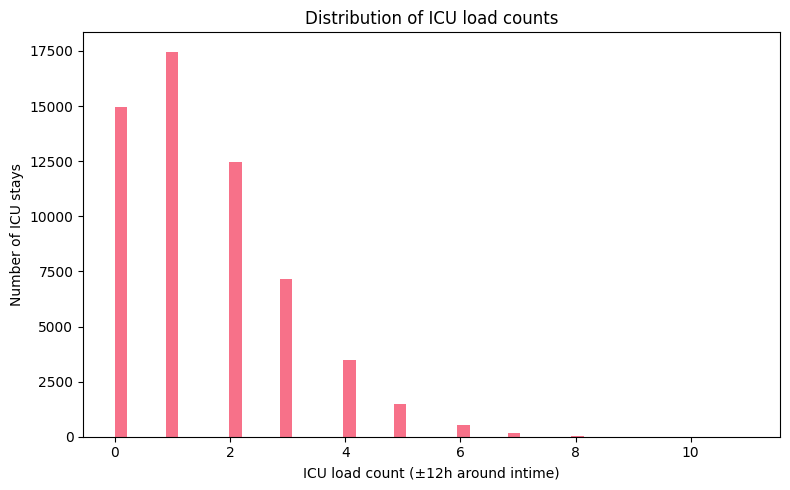

In [ ]:
occ = occ_cl

# Basic descriptive stats
print(occ["concurrent_count"].describe())

# Frequency table (trim as you like)
print(occ["concurrent_count"].value_counts().sort_index().head(30))

# Histogram
plt.figure(figsize=(8,5))
plt.hist(occ["concurrent_count"], bins=50)
plt.xlabel("ICU load count (±12h around intime)")
plt.ylabel("Number of ICU stays")
plt.title("Distribution of ICU load counts")
plt.tight_layout()
plt.show()

count    57776.000000
mean         9.802063
std          3.176827
min          0.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         24.000000
Name: concurrent_count, dtype: float64
concurrent_count
0      135
1      112
2      216
3      494
4     1206
5     2142
6     3900
7     5319
8     6684
9     7465
10    7404
11    6464
12    5236
13    4029
14    2744
15    1777
16    1098
17     613
18     343
19     180
20     116
21      56
22      25
23      11
24       7
Name: count, dtype: int64


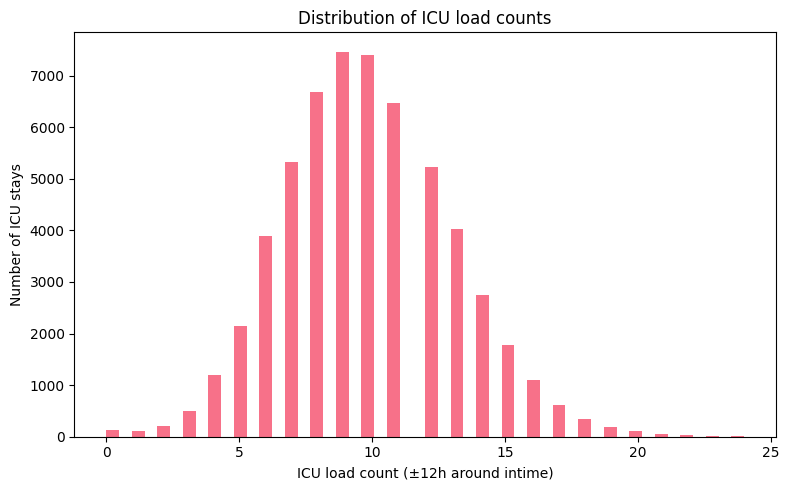

In [ ]:
occ = occ_12h_lw

# Basic descriptive stats
print(occ["concurrent_count"].describe())

# Frequency table (trim as you like)
print(occ["concurrent_count"].value_counts().sort_index().head(30))

# Histogram
plt.figure(figsize=(8,5))
plt.hist(occ["concurrent_count"], bins=50)
plt.xlabel("ICU load count (±12h around intime)")
plt.ylabel("Number of ICU stays")
plt.title("Distribution of ICU load counts")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

def extract_global_icu_occupancy(con, window_hours=12, *,
                                 level='per_patient',      # 'per_patient' or 'per_admission'
                                 same_unit=False,          # overlap within same first_careunit only
                                 instantaneous=False):     # count at exact intime (no ±window)
    """
    Global ICU occupancy: for each index ICU stay (based on `level`),
    count how many *other* ICU stays overlap around its intime.

    Returns columns:
      ['icustay_id','subject_id','hadm_id','intime','first_careunit','concurrent_count']
    """

    # choose partition for "first" index stay
    if level == 'per_admission':
        partition = "subject_id, hadm_id"
    elif level == 'per_patient':
        partition = "subject_id"
    else:
        raise ValueError("level must be 'per_patient' or 'per_admission'")

    # overlap semantics
    if instantaneous:
        overlap_clause = (
            "s2.intime <= s1.intime "
            "AND s2.outtime > s1.intime"
        )
    else:
        overlap_clause = (
            f"s2.intime  <= s1.intime + INTERVAL '{window_hours} hours' "
            f"AND s2.outtime >  s1.intime - INTERVAL '{window_hours} hours'"
        )

    unit_clause = "AND s2.first_careunit = s1.first_careunit" if same_unit else ""

    query = f"""
    WITH stays AS (
      SELECT
        CAST(icustay_id AS INTEGER)   AS icustay_id,
        CAST(subject_id AS INTEGER)   AS subject_id,
        CAST(hadm_id    AS INTEGER)   AS hadm_id,
        CAST(intime     AS TIMESTAMP) AS intime,
        CAST(outtime    AS TIMESTAMP) AS outtime,
        first_careunit,
        ROW_NUMBER() OVER (PARTITION BY {partition} ORDER BY intime) AS rn
      FROM icustays
      WHERE intime IS NOT NULL AND outtime IS NOT NULL
    ),
    index_stays AS (
      SELECT * FROM stays WHERE rn = 1
    ),
    counts AS (
      SELECT
        s1.icustay_id,
        s1.subject_id,
        s1.hadm_id,
        s1.intime,
        s1.first_careunit,
        COUNT(*) FILTER (WHERE s2.icustay_id IS NOT NULL) AS concurrent_count
      FROM index_stays s1
      LEFT JOIN stays s2
        ON s2.icustay_id <> s1.icustay_id
       AND {overlap_clause}
       {unit_clause}
      GROUP BY s1.icustay_id, s1.subject_id, s1.hadm_id, s1.intime, s1.first_careunit
    )
    SELECT *
    FROM counts
    ORDER BY subject_id, hadm_id, intime
    """

    df = (con.execute(query).fetchdf()
            .rename(str.lower, axis="columns"))
    return df


import numpy as np

def build_cutoff_mapping(cutoffs, ascending=True):
    cuts = sorted(cutoffs)
    labels = list(range(1, len(cuts) + 2))
    if not ascending:
        labels = labels[::-1]
    # list of (upper_bound, score)
    return list(zip(cuts + [float('inf')], labels))

def score_value(x, mapping):
    for ub, sc in mapping:
        if x <= ub:
            return sc

def gen_cutoffs(occ_concurrent_counts, num_of_bins: int = 10):
    lo, hi = occ_concurrent_counts.min(), occ_concurrent_counts.max()
    edges = np.linspace(lo, hi, num=num_of_bins+1)
    cutoffs = edges[1:-1].tolist()  # inner cutoffs
    return cutoffs



def get_mapping_by_window(con, window_hours=12):
    occ = extract_global_icu_occupancy(con, window_hours=window_hours,
                                       level='per_admission',
                                       same_unit=False,
                                       instantaneous=False)
    cutoffs = gen_cutoffs(occ["concurrent_count"], num_of_bins=10)
    mapping = build_cutoff_mapping(cutoffs, ascending=True)
    return occ, mapping

occ_12h, mapping_12h = get_mapping_by_window(con, window_hours=12)
occ_12h['icu_occupancy_score'] = occ_12h['concurrent_count'].apply(lambda v: score_value(v, mapping_12h)).astype(int)

occ_24h, mapping_24h = get_mapping_by_window(con, window_hours=24)
occ_24h['icu_occupancy_score'] = occ_24h['concurrent_count'].apply(lambda v: score_value(v, mapping_24h)).astype(int)


In [ ]:
occ_12h.head()

,icustay_id,subject_id,hadm_id,intime,first_careunit,concurrent_count,icu_occupancy_score
0,243653,2,163353,2138-07-17 21:20:07,NICU,11,5
1,211552,3,145834,2101-10-20 19:10:11,MICU,8,4
2,294638,4,185777,2191-03-16 00:29:31,MICU,13,6
3,214757,5,178980,2103-02-02 06:04:24,NICU,7,3
4,228232,6,107064,2175-05-30 21:30:54,SICU,8,4


In [ ]:
occ_24h.head()

,icustay_id,subject_id,hadm_id,intime,first_careunit,concurrent_count,icu_occupancy_score
0,243653,2,163353,2138-07-17 21:20:07,NICU,14,6
1,211552,3,145834,2101-10-20 19:10:11,MICU,10,4
2,294638,4,185777,2191-03-16 00:29:31,MICU,15,6
3,214757,5,178980,2103-02-02 06:04:24,NICU,11,5
4,228232,6,107064,2175-05-30 21:30:54,SICU,9,4


count    57776.000000
mean        11.429884
std          3.454284
min          0.000000
25%          9.000000
50%         11.000000
75%         14.000000
max         26.000000
Name: concurrent_count, dtype: float64
concurrent_count
0      114
1       90
2      108
3      160
4      441
5     1012
6     1798
7     3112
8     4309
9     5751
10    6582
11    6861
12    6461
13    5871
14    4695
15    3637
16    2490
17    1705
18    1129
19     618
20     345
21     217
22     143
23      48
24      50
25      21
26       8
Name: count, dtype: int64


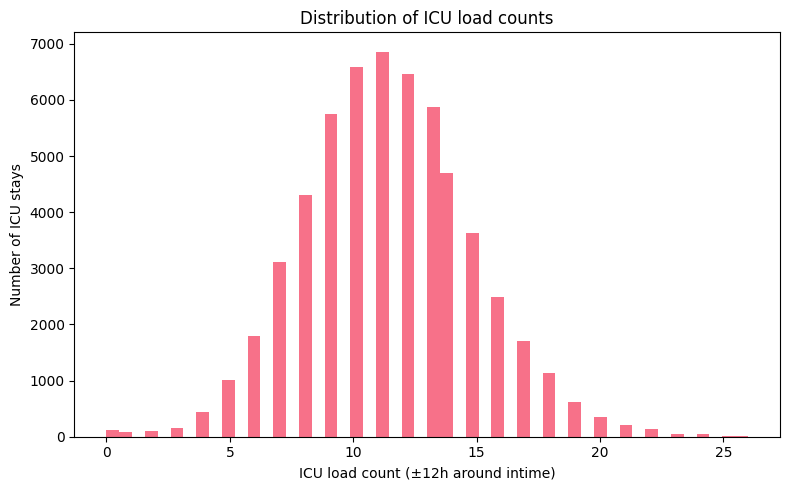

In [ ]:
occ = occ_24h

# Basic descriptive stats
print(occ["concurrent_count"].describe())

# Frequency table (trim as you like)
print(occ["concurrent_count"].value_counts().sort_index().head(30))

# Histogram
plt.figure(figsize=(8,5))
plt.hist(occ["concurrent_count"], bins=50)
plt.xlabel("ICU load count (±12h around intime)")
plt.ylabel("Number of ICU stays")
plt.title("Distribution of ICU load counts")
plt.tight_layout()
plt.show()

In [ ]:
WINDOW_HOURS = 12

occ_query = f"""
WITH stays AS (
  SELECT
    CAST(icustay_id AS INTEGER)  AS icustay_id,
    CAST(intime     AS TIMESTAMP) AS intime,
    CAST(outtime    AS TIMESTAMP) AS outtime
  FROM icustays
  WHERE intime IS NOT NULL AND outtime IS NOT NULL
),
counts AS (
  SELECT
    s1.icustay_id,
    COUNT(*) FILTER (WHERE s2.icustay_id IS NOT NULL) AS icu_occupancy_count
  FROM stays s1
  LEFT JOIN stays s2
    ON s2.icustay_id <> s1.icustay_id
   AND s2.intime <= s1.intime + INTERVAL {WINDOW_HOURS} HOUR
   AND s2.outtime  > s1.intime - INTERVAL {WINDOW_HOURS} HOUR
  GROUP BY s1.icustay_id
)
SELECT icustay_id, icu_occupancy_count
FROM counts
ORDER BY icustay_id;
"""
occ_ex = con.execute(occ_query).fetchdf()
occ_ex.head()

,icustay_id,icu_occupancy_count
0,200001,13
1,200003,15
2,200006,11
3,200007,9
4,200009,13


count    61522.000000
mean         9.801941
std          3.177481
min          0.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         24.000000
Name: icu_occupancy_count, dtype: float64
icu_occupancy_count
0      151
1      125
2      224
3      526
4     1276
5     2295
6     4131
7     5670
8     7115
9     7950
10    7855
11    6896
12    5616
13    4262
14    2938
15    1893
16    1157
17     654
18     371
19     193
20     122
21      58
22      25
23      11
24       8
Name: count, dtype: int64


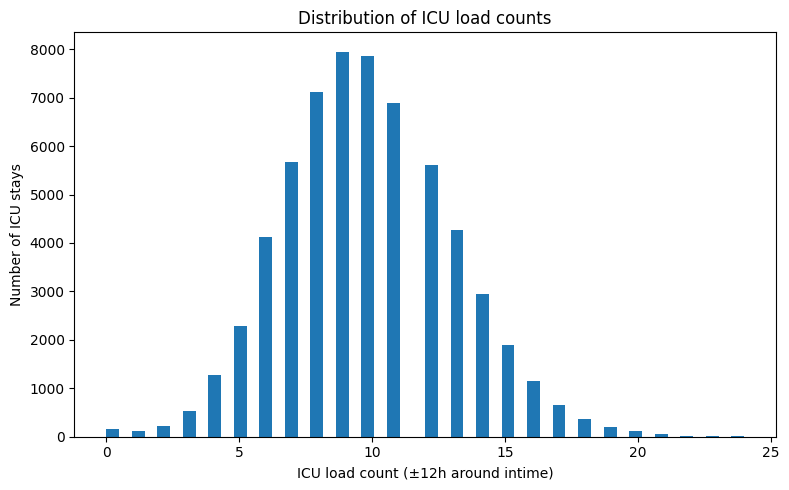

In [ ]:
# Basic descriptive stats
print(occ_ex["icu_occupancy_count"].describe())

# Frequency table (trim as you like)
print(occ_ex["icu_occupancy_count"].value_counts().sort_index().head(30))

# Histogram
plt.figure(figsize=(8,5))
plt.hist(occ_ex["icu_occupancy_count"], bins=50)
plt.xlabel("ICU load count (±12h around intime)")
plt.ylabel("Number of ICU stays")
plt.title("Distribution of ICU load counts")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

def equal_width_score(
    s: pd.Series,
    n_bins: int = 5,
    min_val: float | None = None,
    max_val: float | None = None,
    ascending: bool = True,
):
    """
    Equal-width binning: split [min, max] into n_bins bins of equal size.
    Returns:
      scores: pd.Series[Int64] with labels 1..K
      info:   dict with edges and inner cutoffs
    """
    s_num = pd.to_numeric(s, errors="coerce")
    s_clean = s_num.dropna()

    if s_clean.empty:
        return pd.Series(pd.array([pd.NA]*len(s), dtype="Int64"), index=s.index), {
            "edges": [], "cutoffs_used": [], "actual_bins": 0
        }

    lo = s_clean.min() if min_val is None else float(min_val)
    hi = s_clean.max() if max_val is None else float(max_val)

    if hi <= lo:
        # Degenerate case: all values equal → single bin
        labels = [1]
        edges = [lo, lo]  # pd.cut will NA; handle explicitly:
        scores = pd.Series(1, index=s.index, dtype="Int64")
        return scores, {"edges": edges, "cutoffs_used": [], "actual_bins": 1}

    # Evenly spaced edges from lo to hi (inclusive)
    edges = np.linspace(lo, hi, num=n_bins+1)
    inner = edges[1:-1].tolist()  # the “cutoffs” you’d print

    labels = list(range(1, n_bins+1))
    if not ascending:
        labels = labels[::-1]

    # Bin (include_lowest + right-closed ⇒ max value included)
    scores = pd.cut(
        s_num, bins=edges, labels=labels, include_lowest=True, right=True
    ).astype("Int64")

    info = {
        "edges": edges.tolist(),
        "cutoffs_used": inner,
        "actual_bins": n_bins,
    }
    return scores, info


occ_ex["icu_occupancy_score"], info = equal_width_score(
    occ_ex["icu_occupancy_count"],
    n_bins=10,      # produces 4 cutoffs
    ascending=True # higher occupancy → higher score
)
print("Edges:", info["edges"])
print("Cutoffs:", info["cutoffs_used"])


Edges: [0.0, 2.4, 4.8, 7.199999999999999, 9.6, 12.0, 14.399999999999999, 16.8, 19.2, 21.599999999999998, 24.0]
Cutoffs: [2.4, 4.8, 7.199999999999999, 9.6, 12.0, 14.399999999999999, 16.8, 19.2, 21.599999999999998]


In [ ]:
occ_ex.head()

,icustay_id,icu_occupancy_count,icu_occupancy_score
0,200001,13,6
1,200003,15,7
2,200006,11,5
3,200007,9,4
4,200009,13,6


In [ ]:
import numpy as np

def score_array(values, cutoffs, ascending=True):
    cuts = np.array(sorted(cutoffs), dtype=float)
    labels = np.arange(1, cuts.size + 2, dtype=int)
    if not ascending:
        labels = labels[::-1]
    idx = np.digitize(values, cuts, right=True)  # ≤ cutoff goes to that bin
    return labels[idx]


def build_cutoff_mapping(cutoffs, ascending=True):
    cuts = sorted(cutoffs)
    labels = list(range(1, len(cuts) + 2))
    if not ascending:
        labels = labels[::-1]
    # list of (upper_bound, score); semantics: value <= upper_bound → score
    return list(zip(cuts + [float('inf')], labels))

def score_value(x, mapping):
    for ub, sc in mapping:   # mapping from build_cutoff_mapping
        if x <= ub:
            return sc

cutoffs = info["cutoffs_used"]
mapping = build_cutoff_mapping(cutoffs, ascending=True)
print("Cutoff mapping:", mapping)
res_t1 = score_value(10, mapping)
res_t2 = score_value(2, mapping)
res_t3 = score_value(20, mapping)
print(res_t1, res_t2, res_t3)

Cutoff mapping: [(2.4, 1), (4.8, 2), (7.199999999999999, 3), (9.6, 4), (12.0, 5), (14.399999999999999, 6), (16.8, 7), (19.2, 8), (21.599999999999998, 9), (inf, 10)]
5 1 9


In [ ]:
# Compute cutoffs
q20, q40, q60, q80 = occ_ex["icu_occupancy_count"].quantile([0.2, 0.4, 0.6, 0.8]).to_list()
print("Quantile cutoffs:", {"q20": q20, "q40": q40, "q60": q60, "q80": q80})

# Map count -> score 1..5
def to_score(x):
    if x <= q20: return 1
    elif x <= q40: return 2
    elif x <= q60: return 3
    elif x <= q80: return 4
    else: return 5

occ_ex["icu_occupancy_score"] = occ_ex["icu_occupancy_count"].apply(to_score).astype(int)

# Quick sanity check on scores
print(occ_ex["icu_occupancy_score"].value_counts().sort_index())


Quantile cutoffs: {'q20': 7.0, 'q40': 9.0, 'q60': 10.0, 'q80': 12.0}
icu_occupancy_score
1    14398
2    15065
3     7855
4    12512
5    11692
Name: count, dtype: int64


In [ ]:
tr_query = "SELECT COUNT(*) FROM icustays;"
tr_ex = con.execute(tr_query)
tr_ex.fetchall()

[(61532,)]

In [ ]:
icu_load = (
    con.execute(ICU_LOAD_SQL)
      .fetchdf()
      .rename(str.lower, axis='columns')  # -> ['icustay_id','icu_load_count']
)

count    61532.000000
mean         1.672138
std          1.317240
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: icu_load_count, dtype: float64
icu_load_count
0    11963
1    19024
2    16046
3     8848
4     3770
5     1322
6      399
7      137
8       20
9        3
Name: count, dtype: int64


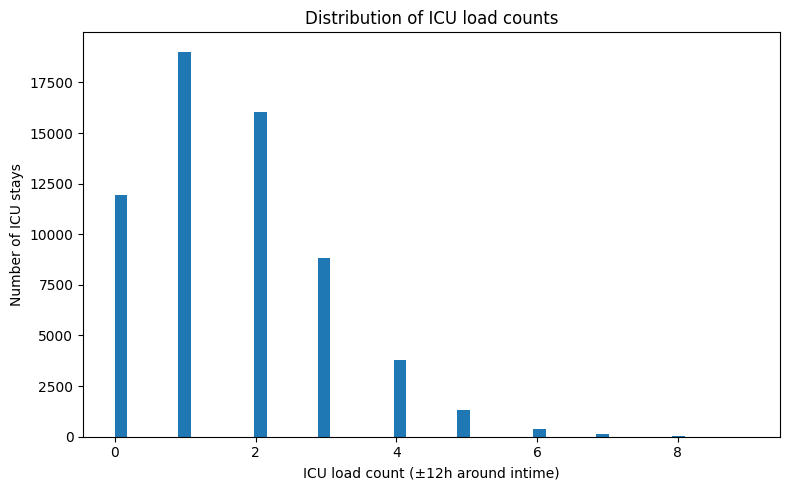

In [ ]:
# Basic descriptive stats
print(icu_load["icu_load_count"].describe())

# Frequency table (trim as you like)
print(icu_load["icu_load_count"].value_counts().sort_index().head(30))

# Histogram
plt.figure(figsize=(8,5))
plt.hist(icu_load["icu_load_count"], bins=50)
plt.xlabel("ICU load count (±12h around intime)")
plt.ylabel("Number of ICU stays")
plt.title("Distribution of ICU load counts")
plt.tight_layout()
plt.show()

In [ ]:
# Compute cutoffs
q20, q40, q60, q80 = icu_load["icu_load_count"].quantile([0.2, 0.4, 0.6, 0.8]).to_list()
print("Quantile cutoffs:", {"q20": q20, "q40": q40, "q60": q60, "q80": q80})

# Map count -> score 1..5
def to_score(x):
    if x <= q20: return 1
    elif x <= q40: return 2
    elif x <= q60: return 3
    elif x <= q80: return 4
    else: return 5

icu_load["icu_load_score"] = icu_load["icu_load_count"].apply(to_score).astype(int)

# Quick sanity check on scores
print(icu_load["icu_load_score"].value_counts().sort_index())


Quantile cutoffs: {'q20': 1.0, 'q40': 1.0, 'q60': 2.0, 'q80': 3.0}
icu_load_score
1    30987
3    16046
4     8848
5     5651
Name: count, dtype: int64


## Generate Final Cohort
- use first admission per patient
- filter 18 <= age < 90
- filter patients by data availability (at least 48h)

In [ ]:
# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

print("="*70)
print("DATA ANALYSIS WITH PRECISE TIMESTAMPS")
print("="*70)

print(f"Initial data loaded:")
print(f"✓ ICU data: {len(icu):,} rows")
print(f"✓ Lab data: {len(lab):,} rows")
print(f"✓ Vital data: {len(vit):,} rows")

# =============================================================================
# COHORT FILTERING
# =============================================================================

def analyze_multiple_admissions(icu):
    """Analyze patients with multiple admissions"""
    print("\n" + "="*60)
    print("MULTIPLE ADMISSIONS ANALYSIS")
    print("="*60)

    # Count admissions per patient
    admissions_per_patient = icu.groupby('subject_id')['hadm_id'].nunique().reset_index()
    admissions_per_patient.columns = ['subject_id', 'num_admissions']

    # Statistics
    print(f"Total unique patients: {len(admissions_per_patient):,}")
    print(f"Patients with 1 admission: {(admissions_per_patient['num_admissions'] == 1).sum():,}")
    print(f"Patients with >1 admission: {(admissions_per_patient['num_admissions'] > 1).sum():,}")
    print(f"Max admissions per patient: {admissions_per_patient['num_admissions'].max()}")

    # Distribution of number of admissions
    admission_dist = admissions_per_patient['num_admissions'].value_counts().sort_index()
    print(f"\nDistribution of admissions per patient:")
    for num_adm, count in admission_dist.head(10).items():
        print(f"  {num_adm} admission(s): {count:,} patients")

    return admissions_per_patient

def filter_age(cohort):
    # Age calculation
    cohort = cohort.copy()
    cohort['admittime'] = pd.to_datetime(cohort['admittime'])
    cohort['dob'] = pd.to_datetime(cohort['dob'])
    cohort['age_at_admission'] = (
        cohort['admittime'] - cohort['dob']
    ).dt.days / 365.25

    # Filter for patients under 18 OR over 90
    age_filter = (cohort['age_at_admission'] >= 18) & (cohort['age_at_admission'] < 90)
    return cohort[age_filter]

def filter_first_admissions(icu):
    """Filter to keep only first hospital admissions per patient"""
    print("\n" + "="*60)
    print("FILTERING FOR FIRST ADMISSIONS")
    print("="*60)

    # Sort by patient and admission time to get first admission
    icu_sorted = icu.sort_values(['subject_id', 'admittime'])
    first_admissions = icu_sorted.groupby('subject_id').first().reset_index()

    print(f"Original ICU records: {len(icu):,}")
    print(f"After filtering to first admissions: {len(first_admissions):,}")
    print(f"Unique patients: {first_admissions['subject_id'].nunique():,}")

    return first_admissions

def calculate_precise_los_and_filter(first_admissions):
    """Calculate precise length of stay and apply 54-hour filter"""
    print("\n" + "="*60)
    print("PRECISE LENGTH OF STAY CALCULATION AND 54-HOUR FILTER")
    print("="*60)

    # Convert to datetime for calculation
    first_admissions = first_admissions.copy()
    first_admissions['admittime'] = pd.to_datetime(first_admissions['admittime'])
    first_admissions['dischtime'] = pd.to_datetime(first_admissions['dischtime'])

    # Calculate length of stay
    time_diff = first_admissions['dischtime'] - first_admissions['admittime']
    first_admissions['los_hours'] = time_diff.dt.total_seconds() / 3600
    first_admissions['los_days'] = first_admissions['los_hours'] / 24
    first_admissions['los_minutes'] = time_diff.dt.total_seconds() / 60

    # Show example calculations
    print("Example precise calculations (first 5 patients):")
    sample = first_admissions[['subject_id', 'admittime', 'dischtime', 'los_hours', 'los_days']].head(5)
    for idx, row in sample.iterrows():
        print(f"  Patient {row['subject_id']}:")
        print(f"    {row['admittime']} → {row['dischtime']}")
        print(f"    LOS: {row['los_hours']:.2f} hours ({row['los_days']:.2f} days)")

    # Statistics with precise timestamps
    print(f"\nPrecise LOS Statistics:")
    print(f"  Mean: {first_admissions['los_hours'].mean():.2f} hours ({first_admissions['los_days'].mean():.2f} days)")
    print(f"  Median: {first_admissions['los_hours'].median():.2f} hours ({first_admissions['los_days'].median():.2f} days)")
    print(f"  Min: {first_admissions['los_hours'].min():.2f} hours ({first_admissions['los_days'].min():.2f} days)")
    print(f"  Max: {first_admissions['los_hours'].max():.2f} hours ({first_admissions['los_days'].max():.2f} days)")

    # Apply 54-hour filter
    los_54h_filter = first_admissions['los_hours'] >= 54
    filtered_cohort = first_admissions[los_54h_filter].copy()

    meets_54h = len(filtered_cohort)
    total = len(first_admissions)

    print(f"\n54-Hour Filter Results:")
    print(f"  Before ≥54h filter: {total:,} patients")
    print(f"  After ≥54h filter: {meets_54h:,} patients")
    print(f"  Excluded: {total - meets_54h:,} patients ({(total - meets_54h)/total*100:.1f}%)")

    # Show distribution around the 54-hour cutoff
    print(f"\nLOS distribution around 54-hour cutoff:")
    ranges = [
        (0, 24, "0-24 hours"),
        (24, 48, "24-48 hours"),
        (48, 54, "48-54 hours (excluded)"),
        (54, 72, "54-72 hours (included)"),
        (72, 168, "72-168 hours (3-7 days)"),
        (168, float('inf'), "> 168 hours (> 7 days)")
    ]

    for min_h, max_h, label in ranges:
        if max_h == float('inf'):
            count = (first_admissions['los_hours'] >= min_h).sum()
        else:
            count = ((first_admissions['los_hours'] >= min_h) & (first_admissions['los_hours'] < max_h)).sum()
        percentage = count / total * 100
        print(f"  {label}: {count:,} patients ({percentage:.1f}%)")

    return filtered_cohort

def check_48h_data_availability(filtered_cohort, lab, vit):
    """Check which patients have data available in first 48 hours"""
    print("\n" + "="*60)
    print("48-HOUR DATA AVAILABILITY CHECK")
    print("="*60)

    # Get admission IDs from filtered cohort
    valid_hadm_ids = set(filtered_cohort['hadm_id'].unique())

    # Filter lab and vital data to only include valid admissions
    lab_filtered = lab[lab['hadm_id'].isin(valid_hadm_ids)].copy()
    vit_filtered = vit[vit['hadm_id'].isin(valid_hadm_ids)].copy()

    # Check patients with lab data in first 48h
    lab_patients_48h = set(lab_filtered['subject_id'].unique())
    vit_patients_48h = set(vit_filtered['subject_id'].unique())

    # Patients in filtered cohort
    cohort_patients = set(filtered_cohort['subject_id'].unique())

    print(f"Filtered cohort patients: {len(cohort_patients):,}")
    print(f"Patients with lab data in 48h: {len(lab_patients_48h):,}")
    print(f"Patients with vital data in 48h: {len(vit_patients_48h):,}")
    print(f"Patients with both lab & vital data: {len(lab_patients_48h & vit_patients_48h):,}")

    # Final cohort: patients with at least some data in first 48h
    patients_with_data = lab_patients_48h | vit_patients_48h
    final_cohort_patients = cohort_patients & patients_with_data

    print(f"Final cohort with 48h data: {len(final_cohort_patients):,}")

    # Filter final cohort
    final_cohort = filtered_cohort[
        filtered_cohort['subject_id'].isin(final_cohort_patients)
    ].copy()

    return final_cohort, lab_filtered, vit_filtered


def analyze_final_cohort_characteristics(final_cohort):
    """Analyze characteristics of the final cohort"""
    print("\n" + "="*60)
    print("FINAL COHORT CHARACTERISTICS")
    print("="*60)

    # Basic demographics
    print(f"Final cohort size: {len(final_cohort):,} patients")
    print(f"Gender distribution:")
    gender_dist = final_cohort['gender'].value_counts()
    for gender, count in gender_dist.items():
        print(f"  {gender}: {count:,} ({count/len(final_cohort)*100:.1f}%)")

    # Age calculation
    final_cohort = final_cohort.copy()
    final_cohort['admittime'] = pd.to_datetime(final_cohort['admittime'])
    final_cohort['dob'] = pd.to_datetime(final_cohort['dob'])
    final_cohort['age_at_admission'] = (
        final_cohort['admittime'] - final_cohort['dob']
    ).dt.days / 365.25

    print(f"\nAge statistics:")
    print(f"  Mean age: {final_cohort['age_at_admission'].mean():.1f} years")
    print(f"  Median age: {final_cohort['age_at_admission'].median():.1f} years")
    print(f"  Age range: {final_cohort['age_at_admission'].min():.1f} - {final_cohort['age_at_admission'].max():.1f} years")

    # Length of stay statistics
    print(f"\nLength of stay (final cohort):")
    print(f"  Mean: {final_cohort['los_hours'].mean():.1f} hours ({final_cohort['los_days'].mean():.1f} days)")
    print(f"  Median: {final_cohort['los_hours'].median():.1f} hours ({final_cohort['los_days'].median():.1f} days)")
    print(f"  Range: {final_cohort['los_hours'].min():.1f} - {final_cohort['los_hours'].max():.1f} hours")

    # Death information
    deaths_during_hosp = final_cohort['deathtime'].notna().sum()
    deaths_total = final_cohort['dod'].notna().sum()
    print(f"\nMortality information:")
    print(f"  Deaths during hospitalization: {deaths_during_hosp:,} ({deaths_during_hosp/len(final_cohort)*100:.1f}%)")
    print(f"  Total deaths (any time): {deaths_total:,} ({deaths_total/len(final_cohort)*100:.1f}%)")

    return final_cohort

def create_cohort_flowchart(initial_count, first_adm_count, los_54h_count, final_count):
    """Create a visual flowchart of cohort selection"""
    print("\n" + "="*60)
    print("COHORT SELECTION FLOWCHART")
    print("="*60)

    print("Cohort Selection Process:")
    print(f"\n1. Initial Cohort: {initial_count:,} patients")
    print(f"   ↓ Excluded multiple admissions: {initial_count - first_adm_count:,}")
    print(f"\n2. First Admissions Only: {first_adm_count:,} patients")
    print(f"   ↓ Excluded <54.0 hours LOS: {first_adm_count - los_54h_count:,}")
    print(f"\n3. ≥54 Hours LOS: {los_54h_count:,} patients")
    print(f"   ↓ Excluded no 48h data: {los_54h_count - final_count:,}")
    print(f"\n4. Final Cohort with 48h Data: {final_count:,} patients")

# =============================================================================
# MAIN EXECUTION FUNCTION
# =============================================================================

def execute_complete_analysis(icu, lab, vit):
    """Execute complete cohort analysis with precise timestamps"""

    print("\nEXECUTING COMPLETE COHORT ANALYSIS")
    # Step 1: Filter age < 18 and > 90
    cohort = filter_age(icu)
    # Step 2: Analyze multiple admissions
    initial_count = len(set(cohort['subject_id'].unique()))
    admissions_analysis = analyze_multiple_admissions(cohort)

    # Step 3: Filter for first admissions
    first_admissions = filter_first_admissions(cohort)
    first_adm_count = len(first_admissions)

    # Step 4: Calculate precise LOS and filter for ≥54 hours
    filtered_cohort = calculate_precise_los_and_filter(first_admissions)
    los_54h_count = len(filtered_cohort)

    # Step 5: Check 48-hour data availability
    final_cohort, lab_filtered, vit_filtered = check_48h_data_availability(
        filtered_cohort, lab, vit
    )
    final_count = len(final_cohort)

    # Step 6: Create flowchart
    create_cohort_flowchart(initial_count, first_adm_count, los_54h_count, final_count)

    # Step 7: Analyze final cohort
    final_cohort = analyze_final_cohort_characteristics(final_cohort)

    print(f"\n{'='*70}")
    print("ANALYSIS COMPLETE!")
    print(f"{'='*70}")
    print(f"✅ Final cohort: {len(final_cohort):,} patients")
    print(f"✅ Lab data: {len(lab_filtered):,} records")
    print(f"✅ Vital data: {len(vit_filtered):,} records")
    print(f"✅ Using precise 54.0-hour threshold")
    print(f"✅ Ready for Step 3: Target definition and additional modalities")

    return final_cohort, lab_filtered, vit_filtered

# =============================================================================
# EXECUTE THE ANALYSIS
# =============================================================================

print("\nExecuting complete analysis...")
final_cohort, lab_filtered, vit_filtered = execute_complete_analysis(icu, lab, vit)

DATA ANALYSIS WITH PRECISE TIMESTAMPS
Initial data loaded:
✓ ICU data: 42,765 rows
✓ Lab data: 2,831,401 rows
✓ Vital data: 12,403,873 rows

Executing complete analysis...

EXECUTING COMPLETE COHORT ANALYSIS

MULTIPLE ADMISSIONS ANALYSIS
Total unique patients: 25,550
Patients with 1 admission: 21,265
Patients with >1 admission: 4,285
Max admissions per patient: 41

Distribution of admissions per patient:
  1 admission(s): 21,265 patients
  2 admission(s): 2,932 patients
  3 admission(s): 749 patients
  4 admission(s): 283 patients
  5 admission(s): 162 patients
  6 admission(s): 55 patients
  7 admission(s): 32 patients
  8 admission(s): 23 patients
  9 admission(s): 11 patients
  10 admission(s): 11 patients

FILTERING FOR FIRST ADMISSIONS
Original ICU records: 35,124
After filtering to first admissions: 25,550
Unique patients: 25,550

PRECISE LENGTH OF STAY CALCULATION AND 54-HOUR FILTER
Example precise calculations (first 5 patients):
  Patient 3:
    2101-10-20 19:08:00 → 2101-10-3

## Generate Clinical Targets sets
- mortality within 30d
- prolonged stay (> 7d)
- readmission within 30d

PHASE 2: SEPARATE TARGET DATASETS CREATION
CREATING SEPARATE TARGET DATASETS
Step 1: Creating mortality dataset...

CREATING MORTALITY PREDICTION DATASET

FILTERING EARLY DEATHS (<54 HOURS)
Total patients before filtering: 22,906
Patients dying before 54 hours: 4
Patients after filtering: 22,902
Excluded: 4 (0.0%)
Mortality Dataset Summary:
  Total patients: 22,902
  Mortality events: 3,565
  Mortality rate: 15.6%
  Deaths during hospitalization: 2,847
  Deaths within 30d post-discharge: 2,762
  ✅ Mortality rate is within expected range
Step 2: Creating prolonged stay dataset...

CREATING PROLONGED STAY PREDICTION DATASET
Prolonged Stay Dataset Summary:
  Total patients: 20,055
  Prolonged stays (>7 days): 10,795
  Prolonged stay rate: 53.8%
  
  LOS Statistics:
    Non-prolonged: mean=111.9h, max=168.0h
    Prolonged: mean=374.3h, min=168.0h
  ⚠️  WARNING: High prolonged stay rate (53.8%)
Step 3: Creating readmission dataset...

CREATING READMISSION PREDICTION DATASET
Processing 22,90

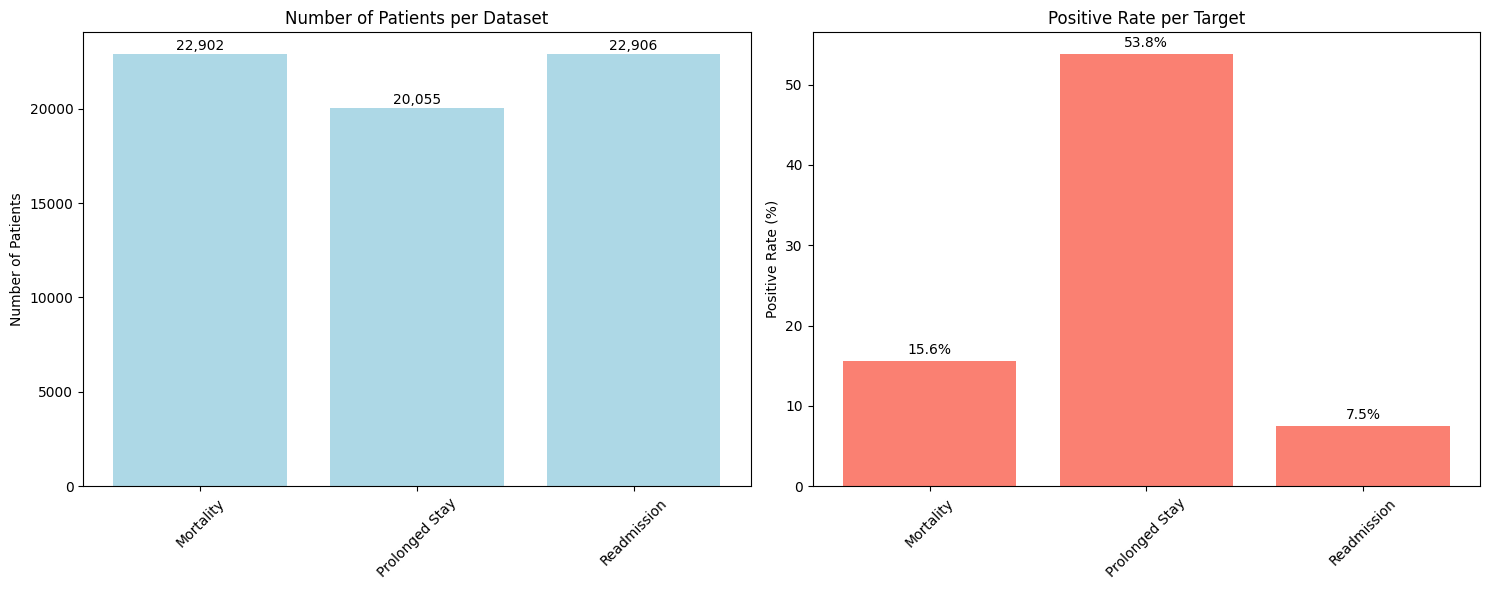

Step 5: Creating detailed summaries...

DATASET SUMMARIES

MORTALITY PREDICTION DATASET:
  Description: Death during hospitalization OR within 30 days post-discharge
  Total patients: 22,902
  Positive cases: 3,565 (15.6%)
  Negative cases: 19,337 (84.4%)
  Age statistics: mean=62.9, std=16.5
  LOS statistics: mean=264.1h, median=185.0h

PROLONGED STAY PREDICTION DATASET:
  Description: Length of stay > 7 days (168 hours)
  Total patients: 20,055
  Positive cases: 10,795 (53.8%)
  Negative cases: 9,260 (46.2%)
  Age statistics: mean=62.2, std=16.6
  LOS statistics: mean=253.1h, median=179.7h

READMISSION PREDICTION DATASET:
  Description: Hospital readmission within 30 days after discharge
  Total patients: 22,906
  Positive cases: 1,711 (7.5%)
  Negative cases: 21,195 (92.5%)
  Age statistics: mean=62.9, std=16.5
  LOS statistics: mean=264.1h, median=185.0h

SEPARATE TARGET DATASETS CREATION COMPLETED!
You now have three separate datasets ready for model training:
1. mortality_dataset

In [ ]:
# =============================================================================
# PHASE 2: SEPARATE TARGET DATASETS CREATION
# Create separate datasets for mortality, prolonged stay, and readmission
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

print("="*70)
print("PHASE 2: SEPARATE TARGET DATASETS CREATION")
print("="*70)

# =============================================================================
# DATASET 1: MORTALITY PREDICTION DATASET
# =============================================================================

def filter_early_deaths(cohort):
    """
    Filters out patients who died before 54 hours from admission.
    """
    print("\n" + "="*50)
    print("FILTERING EARLY DEATHS (<54 HOURS)")
    print("="*50)

    cohort = cohort.copy()

    # Ensure datetime types and calculate prediction gap end
    cohort['admittime'] = pd.to_datetime(cohort['admittime'])
    cohort['deathtime'] = pd.to_datetime(cohort['deathtime'])
    cohort['prediction_gap_end'] = cohort['admittime'] + pd.Timedelta(hours=54)

    # Identify patients who died before the prediction gap ended
    early_deaths_filter = (
        cohort['deathtime'].notna() &
        (cohort['deathtime'] < cohort['prediction_gap_end'])
    )

    # Filter out these patients
    filtered_cohort = cohort[~early_deaths_filter].copy()

    # Analysis
    total_patients = len(cohort)
    early_deaths_count = early_deaths_filter.sum()

    print(f"Total patients before filtering: {total_patients:,}")
    print(f"Patients dying before 54 hours: {early_deaths_count:,}")
    print(f"Patients after filtering: {len(filtered_cohort):,}")
    print(f"Excluded: {early_deaths_count:,} ({(early_deaths_count/total_patients)*100:.1f}%)")

    return filtered_cohort


def create_mortality_dataset(final_cohort):
    """
    Create mortality prediction dataset
    Target: Death during hospitalization OR within 30 days after discharge
    """
    print("\n" + "="*50)
    print("CREATING MORTALITY PREDICTION DATASET")
    print("="*50)

    # filtering death before prediction gap ends (<54)
    cohort = filter_early_deaths(final_cohort)

    # Ensure datetime types
    cohort['admittime'] = pd.to_datetime(cohort['admittime'])
    cohort['dischtime'] = pd.to_datetime(cohort['dischtime'])
    cohort['deathtime'] = pd.to_datetime(cohort['deathtime'])
    cohort['dod'] = pd.to_datetime(cohort['dod'])

    # Calculate 54-hour mark (end of prediction gap)
    cohort['prediction_gap_end'] = cohort['admittime'] + pd.Timedelta(hours=54)

    # Mortality during hospitalization
    death_during_hosp = (
        cohort['deathtime'].notna() &
        (cohort['deathtime'] >= cohort['prediction_gap_end'])
    )

    # Mortality within 30 days after discharge
    cohort['death_cutoff_30d'] = cohort['dischtime'] + pd.Timedelta(days=30)
    death_within_30d_post_discharge = (
        cohort['dod'].notna() &
        (cohort['dod'] <= cohort['death_cutoff_30d']) &
        (cohort['dod'] >= cohort['prediction_gap_end'])
    )

    # Create mortality target
    cohort['mortality'] = (death_during_hosp | death_within_30d_post_discharge).astype(int)

    # Dataset-specific columns for mortality prediction
    mortality_specific_cols = [
        'prediction_gap_end',
        'death_cutoff_30d',
        'mortality'
    ]

    # Create mortality dataset
    mortality_dataset = cohort.copy()

    # Analysis
    total_patients = len(mortality_dataset)
    mortality_count = mortality_dataset['mortality'].sum()
    mortality_rate = mortality_count / total_patients * 100

    print(f"Mortality Dataset Summary:")
    print(f"  Total patients: {total_patients:,}")
    print(f"  Mortality events: {mortality_count:,}")
    print(f"  Mortality rate: {mortality_rate:.1f}%")
    print(f"  Deaths during hospitalization: {death_during_hosp.sum():,}")
    print(f"  Deaths within 30d post-discharge: {death_within_30d_post_discharge.sum():,}")

    if mortality_rate < 5:
        print(f"  ⚠️  WARNING: Low mortality rate ({mortality_rate:.1f}%)")
    elif mortality_rate > 30:
        print(f"  ⚠️  WARNING: High mortality rate ({mortality_rate:.1f}%)")
    else:
        print(f"  ✅ Mortality rate is within expected range")

    return mortality_dataset

# =============================================================================
# DATASET 2: PROLONGED STAY PREDICTION DATASET
# =============================================================================

def create_prolonged_stay_dataset(final_cohort):
    """
    Create prolonged stay prediction dataset
    Target: Length of stay > 7 days (168 hours)
    """
    print("\n" + "="*50)
    print("CREATING PROLONGED STAY PREDICTION DATASET")
    print("="*50)

    cohort = final_cohort.copy()
    # Keep only patients who survived the hospitalization (survivors)
    survivors_filter = cohort['deathtime'].isna()
    cohort = cohort[survivors_filter]
    # Create prolonged stay target
    cohort['prolonged_stay'] = (cohort['los_hours'] > 168).astype(int)

    # Additional features specific to LOS prediction
    cohort['los_days'] = cohort['los_hours'] / 24
    cohort['is_weekend_admission'] = pd.to_datetime(cohort['admittime']).dt.dayofweek >= 5

    # Create prolonged stay dataset
    prolonged_stay_dataset = cohort.copy()

    # Analysis
    total_patients = len(prolonged_stay_dataset)
    prolonged_count = prolonged_stay_dataset['prolonged_stay'].sum()
    prolonged_rate = prolonged_count / total_patients * 100

    # LOS statistics
    prolonged_patients = prolonged_stay_dataset[prolonged_stay_dataset['prolonged_stay'] == 1]
    non_prolonged_patients = prolonged_stay_dataset[prolonged_stay_dataset['prolonged_stay'] == 0]

    print(f"Prolonged Stay Dataset Summary:")
    print(f"  Total patients: {total_patients:,}")
    print(f"  Prolonged stays (>7 days): {prolonged_count:,}")
    print(f"  Prolonged stay rate: {prolonged_rate:.1f}%")
    print(f"  ")
    print(f"  LOS Statistics:")
    print(f"    Non-prolonged: mean={non_prolonged_patients['los_hours'].mean():.1f}h, max={non_prolonged_patients['los_hours'].max():.1f}h")
    print(f"    Prolonged: mean={prolonged_patients['los_hours'].mean():.1f}h, min={prolonged_patients['los_hours'].min():.1f}h")

    if prolonged_rate < 10:
        print(f"  ⚠️  WARNING: Low prolonged stay rate ({prolonged_rate:.1f}%)")
    elif prolonged_rate > 50:
        print(f"  ⚠️  WARNING: High prolonged stay rate ({prolonged_rate:.1f}%)")
    else:
        print(f"  ✅ Prolonged stay rate is within expected range")

    return prolonged_stay_dataset

# =============================================================================
# DATASET 3: READMISSION PREDICTION DATASET
# =============================================================================
def create_readmission_dataset(
    final_cohort: pd.DataFrame,
    all_cohort_admissions: pd.DataFrame,
    min_gap_hours: int = 12,                # treat <12h as transfers (not readmissions)
    max_gap_days: int = 30,                 # 30-day hospital readmission window
    death_post_discharge_as_readdmition: bool = False  # count death ≥54h post-admit & ≤30d post-discharge as "missed readmission"
) -> pd.DataFrame:
    """
    Target: Hospital readmission within 30 days after discharge
    (not to be confused with ICU readmission within the same hospital admission).

    Returns:
        DataFrame = final_cohort with:
          - readmission_30d (bool): next hospital admission within window
          - days_to_readmission (int or None): days to first qualifying readmission
          - readmission (bool): readmission_30d OR (optional death-based proxy)
          - plus helper columns: hours_to_next, next_hadm, next_admit (for audit)
    """
    print("\n" + "="*50)
    print("CREATING READMISSION PREDICTION DATASET")
    print("="*50)

    cohort = final_cohort.copy()
    admits_src = all_cohort_admissions.copy()

    print(f"Processing {len(cohort):,} patients for readmission analysis...")

    # --- Collapse to ONE ROW per hospital admission (avoid ICU-duplication within hadm) ---
    admits = (
        admits_src
        .groupby(["subject_id", "hadm_id"], as_index=False)
        .agg(admittime=("admittime", "min"), dischtime=("dischtime", "max"))
        .sort_values(["subject_id", "admittime"])
    )

    # --- Next admission per subject (vectorized) ---
    admits["next_admit"] = admits.groupby("subject_id")["admittime"].shift(-1)
    admits["next_hadm"]  = admits.groupby("subject_id")["hadm_id"].shift(-1)

    # --- Gap from this discharge to next admit (hours) ---
    admits["hours_to_next"] = (
        (admits["next_admit"] - admits["dischtime"]).dt.total_seconds() / 3600.0
    )

    max_gap_hours = max_gap_days * 24

    # --- Readmission within window (policy: after discharge, >= min_gap, <=30d) ---
    admits["readmission_30d"] = (
        admits["hours_to_next"].ge(min_gap_hours) &
        admits["hours_to_next"].le(max_gap_hours)
    ).fillna(False)

    # --- Merge back to cohort (bring helper cols too) ---
    out = cohort.merge(
    admits[["hadm_id", "readmission_30d", "hours_to_next", "next_hadm", "next_admit"]],
    on="hadm_id",
    how="left"
    )
    # out = cohort.merge(
    #     admits[["hadm_id", "admittime", "dischtime", "readmission_30d",
    #             "hours_to_next", "next_hadm", "next_admit"]],
    #     on="hadm_id",
    #     how="left"
    # )
    out["readmission_30d"] = out["readmission_30d"].fillna(False)

    # # --- days_to_readmission: only for true hospital readmissions (like your original stats) ---
    # # Use integer day difference; None if not readmitted via next_hadm in window
    # mask_true_readmit = out["readmission_30d"] & out["next_admit"].notna()
    # out["days_to_readmission"] = np.where(
    #     mask_true_readmit,
    #     (out.loc[mask_true_readmit, "next_admit"] - out.loc[mask_true_readmit, "dischtime"]).dt.days,
    #     None
    # )

    # --- Optional: death-based "missed readmission" augmentation ---
    if death_post_discharge_as_readdmition:
        death_ts = pd.to_datetime(out.get("dod"), errors="coerce")
        out["hours_to_death_after_discharge"] = (
            (death_ts - out["dischtime"]).dt.total_seconds() / 3600.0
        )
        out["hours_from_admit_to_death"] = (
            (death_ts - out["admittime"]).dt.total_seconds() / 3600.0
        )
        out["death_post_discharge"] = (
            out["next_hadm"].isna() &                                  # no captured readmit
            out["hours_to_death_after_discharge"].gt(0) &              # death after discharge
            out["hours_from_admit_to_death"].ge(54) &                  # ≥54h post-index admit
            out["hours_to_death_after_discharge"].le(max_gap_hours)    # within 30 days post-discharge
        ).fillna(False)
        out["readmission"] = out["readmission_30d"] | out["death_post_discharge"]
        real_readmissions = int(out["readmission_30d"].fillna(False).astype(bool).sum())
        print(f"Real readmissions count: {real_readmissions}")
        missed_readmissions = int(out["death_post_discharge"].fillna(False).astype(bool).sum())
        print(f"Death readmissions count: {missed_readmissions}")
    else:
        out["readmission"] = out["readmission_30d"]

    # ----------------------- Stats prints (like your original) -----------------------
    total_patients = len(out)
    readmission_count = int(out["readmission"].sum())
    readmission_rate = readmission_count / total_patients * 100

    print("Readmission Dataset Summary:")
    print(f"  Total patients: {total_patients:,}")
    print(f"  Readmission events: {readmission_count:,}")
    print(f"  Readmission rate: {readmission_rate:.1f}%")

    # # Days-to-readmission stats (true hospital readmissions only, like original)
    # readmitted_days = [d for d in out["days_to_readmission"].tolist() if d is not None]
    # if len(readmitted_days) > 0:
    #     print(f"  Days to readmission: mean={np.mean(readmitted_days):.1f}, median={np.median(readmitted_days):.1f}")

    # if readmission_rate < 5:
    #     print(f"  ⚠️  WARNING: Low readmission rate ({readmission_rate:.1f}%)")
    # elif readmission_rate > 25:
    #     print(f"  ⚠️  WARNING: High readmission rate ({readmission_rate:.1f}%)")
    # else:
    #     print(f"  ✅ Readmission rate is within expected range")

    # === Return ONLY original final_cohort columns + 'readmission' ===
    labels = (
        out[["hadm_id", "readmission"]]
        .drop_duplicates("hadm_id")          # ensure 1 row per admission
    )
    result = final_cohort.copy()
    result = result.merge(labels, on="hadm_id", how="left")
    result["readmission"] = result["readmission"].fillna(False)
    return result

# =============================================================================
# DATASET COMPARISON AND VALIDATION
# =============================================================================

def compare_datasets(mortality_ds, prolonged_stay_ds, readmission_ds):
    """
    Compare the three datasets and provide summary statistics
    """
    print("\n" + "="*50)
    print("DATASET COMPARISON SUMMARY")
    print("="*50)

    # Fixed: Use correct target column names that actually exist in the datasets
    datasets = {
        'Mortality': {
            'data': mortality_ds,
            'target': 'mortality'  # This column exists
        },
        'Prolonged Stay': {
            'data': prolonged_stay_ds,
            'target': 'prolonged_stay'  # This column exists
        },
        'Readmission': {
            'data': readmission_ds,
            'target': 'readmission'  # This is the actual column name created
        }
    }

    comparison_data = []

    for name, info in datasets.items():
        ds = info['data']
        target_col = info['target']

        # Check if target column exists before accessing it
        if target_col not in ds.columns:
            print(f"⚠️ WARNING: Target column '{target_col}' not found in {name} dataset")
            print(f"Available columns: {list(ds.columns)}")
            continue

        n_patients = len(ds)
        n_positive = ds[target_col].sum()
        positive_rate = (n_positive / n_patients * 100) if n_patients > 0 else 0

        comparison_data.append({
            'Dataset': name,
            'N Patients': n_patients,
            'Positive Cases': n_positive,
            'Positive Rate (%)': positive_rate
        })

    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Patient counts
    ax1.bar(comparison_df['Dataset'], comparison_df['N Patients'], color='lightblue')
    ax1.set_title('Number of Patients per Dataset')
    ax1.set_ylabel('Number of Patients')
    ax1.tick_params(axis='x', rotation=45)

    for i, v in enumerate(comparison_df['N Patients']):
        ax1.text(i, v + 50, f'{v:,}', ha='center', va='bottom')

    # Positive rates
    ax2.bar(comparison_df['Dataset'], comparison_df['Positive Rate (%)'], color='salmon')
    ax2.set_title('Positive Rate per Target')
    ax2.set_ylabel('Positive Rate (%)')
    ax2.tick_params(axis='x', rotation=45)

    for i, v in enumerate(comparison_df['Positive Rate (%)']):
        ax2.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return comparison_df

# =============================================================================
# DATASET EXPORT FUNCTIONS
# =============================================================================

def create_dataset_summaries(mortality_ds, prolonged_stay_ds, readmission_ds):
    """
    Create detailed summaries for each dataset
    """
    print("\n" + "="*50)
    print("DATASET SUMMARIES")
    print("="*50)

    datasets = {
        'MORTALITY PREDICTION': {
            'data': mortality_ds,
            'target': 'mortality',
            'description': 'Death during hospitalization OR within 30 days post-discharge'
        },
        'PROLONGED STAY PREDICTION': {
            'data': prolonged_stay_ds,
            'target': 'prolonged_stay',
            'description': 'Length of stay > 7 days (168 hours)'
        },
        'READMISSION PREDICTION': {
            'data': readmission_ds,
            'target': 'readmission',
            'description': 'Hospital readmission within 30 days after discharge'
        }
    }

    summaries = {}

    for name, info in datasets.items():
        print(f"\n{name} DATASET:")
        print(f"  Description: {info['description']}")
        print(f"  Total patients: {len(info['data']):,}")

        target_col = info['target']
        positive_cases = info['data'][target_col].sum()
        positive_rate = positive_cases / len(info['data']) * 100

        print(f"  Positive cases: {positive_cases:,} ({positive_rate:.1f}%)")
        print(f"  Negative cases: {len(info['data']) - positive_cases:,} ({100-positive_rate:.1f}%)")

        # Age statistics
        age_stats = info['data']['age_at_admission'].describe()
        print(f"  Age statistics: mean={age_stats['mean']:.1f}, std={age_stats['std']:.1f}")

        # LOS statistics
        los_stats = info['data']['los_hours'].describe()
        print(f"  LOS statistics: mean={los_stats['mean']:.1f}h, median={los_stats['50%']:.1f}h")

        summaries[name] = {
            'n_patients': len(info['data']),
            'positive_cases': positive_cases,
            'positive_rate': positive_rate,
            'mean_age': age_stats['mean'],
            'mean_los': los_stats['mean']
        }

    return summaries

# =============================================================================
# MAIN EXECUTION FUNCTION
# =============================================================================

def create_separate_target_datasets(final_cohort, all_admissions_for_cohort):
    """
    Execute complete process to create separate target datasets
    """
    print("CREATING SEPARATE TARGET DATASETS")

    # Create individual datasets
    print("Step 1: Creating mortality dataset...")
    mortality_dataset = create_mortality_dataset(final_cohort)

    print("Step 2: Creating prolonged stay dataset...")
    prolonged_stay_dataset = create_prolonged_stay_dataset(final_cohort)

    print("Step 3: Creating readmission dataset...")
    readmission_dataset = create_readmission_dataset(final_cohort, all_admissions_for_cohort, death_post_discharge_as_readdmition=True)

    # Compare and analyze datasets
    print("Step 4: Comparing datasets...")
    comparison_summary = compare_datasets(mortality_dataset, prolonged_stay_dataset, readmission_dataset)

    # Create detailed summaries
    print("Step 5: Creating detailed summaries...")
    dataset_summaries = create_dataset_summaries(mortality_dataset, prolonged_stay_dataset, readmission_dataset)

    print(f"\n{'='*70}")
    print("SEPARATE TARGET DATASETS CREATION COMPLETED!")
    print(f"{'='*70}")
    print("You now have three separate datasets ready for model training:")
    print("1. mortality_dataset - for mortality prediction")
    print("2. prolonged_stay_dataset - for prolonged stay prediction")
    print("3. readmission_dataset - for readmission prediction")

    return {
        'mortality': mortality_dataset,
        'prolonged_stay': prolonged_stay_dataset,
        'readmission': readmission_dataset,
        'comparison_summary': comparison_summary,
        'dataset_summaries': dataset_summaries
    }

# Execute the process
datasets = create_separate_target_datasets(final_cohort, all_admissions_for_cohort)

# Access individual datasets
mortality_dataset = datasets['mortality']
prolonged_stay_dataset = datasets['prolonged_stay']
readmission_dataset = datasets['readmission']

## Modalities Data

In [ ]:
# =============================================================================
# CONSOLIDATED DATA EXTRACTION (BEFORE DATASET SPLITS) - MODULAR VERSION
# Extract all modality data once from the unified final_cohort
# =============================================================================

print("="*70)
print("CONSOLIDATED DATA EXTRACTION (BEFORE DATASET SPLITS)")
print("="*70)

# =============================================================================
# ICU OCCUPANCY DATA EXTRACTION
# =============================================================================

def extract_icu_occupancy_data(final_cohort, con, clause="load_window", window_hours=12, same_unit=False):
    """
    Extract ICU occupancy data

    For each (subject_id, hadm_id) in the cohort, compute concurrent ICU stays
    around the *earliest ICU stay* of that admission.

    Returns: one row per (subject_id, hadm_id)
             ['icustay_id','subject_id','hadm_id','intime','first_careunit','icu_occupancy_count']
    """
    cohort_hadm_ids = final_cohort['hadm_id'].tolist()
    cohort_subject_ids = final_cohort['subject_id'].tolist()
    print(f"Extracting occupancy for {len(cohort_hadm_ids):,} admissions...")


    # overlap semantics
    if clause == "load_window":
        overlap_clause = (
            f"s2.intime  <= s1.intime + INTERVAL '{window_hours} hours' "
            f"AND s2.outtime >  s1.intime - INTERVAL '{window_hours} hours'"
        )
    elif clause == "current_load":
        overlap_clause = (
            "s2.intime <= s1.intime "
            "AND s2.outtime > s1.intime"
        )
    elif clause == "new_arrivals_window":
        overlap_clause = (
            f"s2.intime >= s1.intime - INTERVAL '{window_hours} hours' "
            f"AND s2.intime <= s1.intime + INTERVAL '{window_hours} hours'"
        )
    else:
        raise ValueError("clause must be 'load_window' or 'current_load' or 'new_arrivals_window'")

    unit_clause = "AND s2.first_careunit = s1.first_careunit" if same_unit else ""

    query = f"""
    WITH stays AS (
      SELECT
        CAST(icustay_id AS INTEGER)   AS icustay_id,
        CAST(subject_id AS INTEGER)   AS subject_id,
        CAST(hadm_id    AS INTEGER)   AS hadm_id,
        CAST(intime     AS TIMESTAMP) AS intime,
        CAST(outtime    AS TIMESTAMP) AS outtime,
        first_careunit,
        ROW_NUMBER() OVER (PARTITION BY subject_id, hadm_id ORDER BY intime) AS rn
      FROM icustays
      WHERE intime IS NOT NULL AND outtime IS NOT NULL
    ),
    cohort_first AS (
      SELECT *
      FROM stays
      WHERE rn = 1
        AND hadm_id IN ?
        AND subject_id IN ?
    ),
    counts AS (
      SELECT
        s1.icustay_id,
        s1.subject_id,
        s1.hadm_id,
        s1.intime,
        s1.first_careunit,
        COUNT(*) FILTER (WHERE s2.icustay_id IS NOT NULL) AS icu_occupancy_count
      FROM cohort_first s1
      LEFT JOIN stays s2
        ON s2.icustay_id <> s1.icustay_id
       AND {overlap_clause}
       {unit_clause}
      GROUP BY s1.icustay_id, s1.subject_id, s1.hadm_id, s1.intime, s1.first_careunit
    )
    SELECT *
    FROM counts
    ORDER BY subject_id, hadm_id, intime
    """

    return (con.execute(query, [cohort_hadm_ids, cohort_subject_ids])
              .fetchdf()
              .rename(str.lower, axis="columns"))

def extract_all_icu_occupancy_data(final_cohort, con):
    """
    Extract all ICU occupancy variants from the unified cohort
    """
    print("\n--- Extracting ICU Occupancy Data ---")

    # Extract all ICU occupancy variants
    icu_lw_12h = extract_icu_occupancy_data(final_cohort, con, clause="load_window", window_hours=12)
    print(f"✓ ICU load window 12h: {len(icu_lw_12h)} records")

    icu_naw_12h = extract_icu_occupancy_data(final_cohort, con, clause="new_arrivals_window", window_hours=12)
    print(f"✓ ICU new arrivals window 12h: {len(icu_naw_12h)} records")

    icu_naw_24h = extract_icu_occupancy_data(final_cohort, con, clause="new_arrivals_window", window_hours=24)
    print(f"✓ ICU new arrivals window 24h: {len(icu_naw_24h)} records")

    icu_cl = extract_icu_occupancy_data(final_cohort, con, clause="current_load")
    print(f"✓ ICU current load: {len(icu_cl)} records")

    # Extract all ICU occupancy variants considering same unit
    icu_lw_12h_same_unit = extract_icu_occupancy_data(final_cohort, con, clause="load_window", same_unit=True, window_hours=12)
    print(f"✓ ICU load window 12h same_unit: {len(icu_lw_12h)} records")

    icu_naw_12h_same_unit = extract_icu_occupancy_data(final_cohort, con, clause="new_arrivals_window", same_unit=True, window_hours=12)
    print(f"✓ ICU new arrivals window 12h same_unit: {len(icu_naw_12h)} records")

    icu_naw_24h_same_unit = extract_icu_occupancy_data(final_cohort, con, clause="new_arrivals_window", same_unit=True, window_hours=24)
    print(f"✓ ICU new arrivals window 24h same_unit: {len(icu_naw_24h)} records")

    icu_cl_same_unit = extract_icu_occupancy_data(final_cohort, con, clause="current_load", same_unit=True)
    print(f"✓ ICU current load same_unit: {len(icu_cl)} records")

    return {
        "icu_lw_12h": icu_lw_12h,
        "icu_lw_12h_same_unit": icu_lw_12h_same_unit,
        "icu_naw_12h": icu_naw_12h,
        "icu_naw_12h_same_unit": icu_naw_12h_same_unit,
        "icu_naw_24h": icu_naw_24h,
        "icu_naw_24h_same_unit": icu_naw_24h_same_unit,
        "icu_cl": icu_cl,
        "icu_cl_same_unit": icu_cl_same_unit
    }

# =============================================================================
# NOTES DATA EXTRACTION
# =============================================================================

def extract_notes_data(final_cohort, con, hours=48, categories=None):
    """
    Extract notes data for the unified cohort
    """
    print("\n--- Extracting Notes Data ---")

    cohort_hadm_ids = final_cohort['hadm_id'].tolist()
    cohort_subject_ids = final_cohort['subject_id'].tolist()
    print(f"Extracting notes for {len(cohort_hadm_ids):,} admissions...")

    notes_query = f"""
    WITH notes_cast AS (
      SELECT
          CAST(n.subject_id AS INTEGER)   AS subject_id,
          CAST(n.hadm_id    AS INTEGER)   AS hadm_id,
          n.category,
          n.description,
          CAST(n.charttime  AS TIMESTAMP) AS charttime,
          CAST(a.admittime  AS TIMESTAMP) AS admittime
      FROM noteevents n
      INNER JOIN admissions a
        ON CAST(n.hadm_id AS INTEGER) = CAST(a.hadm_id AS INTEGER)
      WHERE CAST(n.hadm_id    AS INTEGER) IN ?
        AND CAST(n.subject_id AS INTEGER) IN ?
    )
    SELECT
        subject_id,
        hadm_id,
        category,
        description
    FROM notes_cast
    WHERE charttime IS NOT NULL
      AND charttime <= admittime + INTERVAL '{hours} hours'
      {("AND category IN ?" if categories else "")}
    ORDER BY subject_id, hadm_id, charttime
    """

    bind = [cohort_hadm_ids, cohort_subject_ids]
    if categories:
        bind.append(categories)

    notes_data = (
        con.execute(notes_query, bind)
          .fetchdf()
          .rename(str.lower, axis='columns')
    )

    # Ensure description is a string, no NaNs
    notes_data['description'] = notes_data['description'].fillna('').astype(str)

    print(f"✓ Notes data: {len(notes_data)} records")
    print(f"✓ Patients with notes: {notes_data['subject_id'].nunique()}")

    return notes_data

# =============================================================================
# MEDICATIONS DATA EXTRACTION
# =============================================================================

def extract_medications_data(final_cohort, con):
    """
    Extract medications data for the unified cohort
    """
    print("\n--- Extracting Medications Data ---")

    cohort_hadm_ids = final_cohort['hadm_id'].tolist()
    cohort_subject_ids = final_cohort['subject_id'].tolist()
    print(f"Extracting medications for {len(cohort_hadm_ids):,} admissions...")

    medications_query = """
    SELECT
        p.subject_id::INTEGER AS subject_id,
        p.hadm_id::INTEGER AS hadm_id,
        p.startdate::TIMESTAMP AS startdate,
        p.enddate::TIMESTAMP AS enddate,
        p.drug AS drug,
        p.drug_type AS drug_type,
        p.formulary_drug_cd,
        p.route,
        p.dose_val_rx,
        p.dose_unit_rx,
        a.admittime::TIMESTAMP AS admittime
    FROM prescriptions p
    INNER JOIN admissions a ON p.hadm_id = a.hadm_id
    WHERE p.hadm_id::INTEGER IN ?
    AND p.subject_id::INTEGER IN ?
    AND p.startdate::TIMESTAMP <= a.admittime::TIMESTAMP + interval '48 hours'
    ORDER BY p.subject_id, p.hadm_id, p.startdate
    """

    medications_data = con.execute(
        medications_query,
        [cohort_hadm_ids, cohort_subject_ids]
    ).fetchdf().rename(str.lower, axis='columns')

    print(f"✓ Medications data: {len(medications_data)} prescription records")
    print(f"✓ Patients with medication data: {medications_data['subject_id'].nunique()}")

    return medications_data

# =============================================================================
# MAIN EXECUTION FUNCTIONS
# =============================================================================

def extract_all_modalities_data(final_cohort, con):
    """
    Extract all modality data once from the unified cohort
    """
    print("EXTRACTING ALL MODALITY DATA FROM UNIFIED COHORT")
    print("="*60)

    print(f"Processing {len(final_cohort)} patients ({len(set(final_cohort['hadm_id']))} unique admissions)")

    # Extract all modalities
    icu_load_data = extract_all_icu_occupancy_data(final_cohort, con)
    notes_data = extract_notes_data(final_cohort, con)
    medications_data = extract_medications_data(final_cohort, con)

    print(f"\n{'='*70}")
    print("CONSOLIDATED DATA EXTRACTION COMPLETED!")
    print(f"{'='*70}")
    print(f"✅ ICU Load Data: {len(icu_load_data)} variants extracted")
    print(f"✅ Notes Data: {len(notes_data):,} records")
    print(f"✅ Medications Data: {len(medications_data):,} records")

    return {
        'icu_load_data': icu_load_data,
        'notes_data': notes_data,
        'medications_data': medications_data
    }


# Extract all modality data once from unified cohort
modalities_data = extract_all_modalities_data(final_cohort, con)

CONSOLIDATED DATA EXTRACTION (BEFORE DATASET SPLITS)
EXTRACTING ALL MODALITY DATA FROM UNIFIED COHORT
Processing 22906 patients (22906 unique admissions)

--- Extracting ICU Occupancy Data ---
Extracting occupancy for 22,906 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ ICU load window 12h: 22895 records
Extracting occupancy for 22,906 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ ICU new arrivals window 12h: 22895 records
Extracting occupancy for 22,906 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ ICU new arrivals window 24h: 22895 records
Extracting occupancy for 22,906 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ ICU current load: 22895 records
Extracting occupancy for 22,906 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ ICU load window 12h same_unit: 22895 records
Extracting occupancy for 22,906 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ ICU new arrivals window 12h same_unit: 22895 records
Extracting occupancy for 22,906 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ ICU new arrivals window 24h same_unit: 22895 records
Extracting occupancy for 22,906 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ ICU current load same_unit: 22895 records

--- Extracting Notes Data ---
Extracting notes for 22,906 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Notes data: 182543 records
✓ Patients with notes: 21280

--- Extracting Medications Data ---
Extracting medications for 22,906 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Medications data: 922128 prescription records
✓ Patients with medication data: 20801

CONSOLIDATED DATA EXTRACTION COMPLETED!
✅ ICU Load Data: 8 variants extracted
✅ Notes Data: 182,543 records
✅ Medications Data: 922,128 records

READY FOR FEATURE ENGINEERING!


## Modalities Per Target
Here we create target specific data for the modalities we got:
- icu load
- notes metadata
- medications

In [ ]:
# =============================================================================
# TARGET-SPECIFIC DATA FILTERING
# =============================================================================

def filter_modality_data_for_target(modalities_data, target_dataset, target_name):
    """
    Filter consolidated modality data for a specific target dataset
    """
    print(f"\n--- Filtering data for {target_name.upper()} ---")

    # Get target-specific patient identifiers
    target_ids = target_dataset[['subject_id', 'hadm_id']].drop_duplicates()
    print(f"Target dataset size: {len(target_ids)} patients")

    # Filter each modality to this target's patients
    target_data = {}

    # ICU Load Data
    target_icu_load = {}
    for icu_type, icu_df in modalities_data['icu_load_data'].items():
        target_icu_load[icu_type] = icu_df.merge(
            target_ids, on=['subject_id', 'hadm_id'], how='inner'
        )
        print(f"  {icu_type}: {len(target_icu_load[icu_type])} records")

    target_data['icu_load_data'] = target_icu_load

    # Notes Data
    target_data['notes_data'] = modalities_data['notes_data'].merge(
        target_ids, on=['subject_id', 'hadm_id'], how='inner'
    )
    print(f"  Notes: {len(target_data['notes_data'])} records")

    # Medications Data
    target_data['medications_data'] = modalities_data['medications_data'].merge(
        target_ids, on=['subject_id', 'hadm_id'], how='inner'
    )
    print(f"  Medications: {len(target_data['medications_data'])} records")
    return target_data


def create_all_target_specific_data(datasets_dict, consolidated_modality_data):
    """
    Create target-specific modality data for all targets from consolidated extractions
    """
    print("\n" + "="*70)
    print("CREATING TARGET-SPECIFIC MODALITY DATA")
    print("="*70)

    target_modality_data = {}

    for target_name, target_dataset in datasets_dict.items():
        target_data = filter_modality_data_for_target(
            consolidated_modality_data, target_dataset, target_name
        )
        target_modality_data[target_name] = target_data

    print(f"\n{'='*70}")
    print("TARGET-SPECIFIC MODALITY DATA CREATION COMPLETED!")
    print(f"{'='*70}")

    return target_modality_data


target_modality_data = create_all_target_specific_data(
    {
        'mortality': datasets['mortality'],
        'prolonged_stay': datasets['prolonged_stay'],
        'readmission': datasets['readmission']
    },
    modalities_data
)

# Extract target-specific data for easy access
mortality_icu_load = target_modality_data['mortality']['icu_load_data']
mortality_notes = target_modality_data['mortality']['notes_data']
mortality_medications = target_modality_data['mortality']['medications_data']

prolonged_stay_icu_load = target_modality_data['prolonged_stay']['icu_load_data']
prolonged_stay_notes = target_modality_data['prolonged_stay']['notes_data']
prolonged_stay_medications = target_modality_data['prolonged_stay']['medications_data']

readmission_icu_load = target_modality_data['readmission']['icu_load_data']
readmission_notes = target_modality_data['readmission']['notes_data']
readmission_medications = target_modality_data['readmission']['medications_data']

print(f"\n{'='*70}")
print("READY FOR FEATURE ENGINEERING!")
print(f"{'='*70}")


CREATING TARGET-SPECIFIC MODALITY DATA

--- Filtering data for MORTALITY ---
Target dataset size: 22902 patients
  icu_lw_12h: 22891 records
  icu_lw_12h_same_unit: 22891 records
  icu_naw_12h: 22891 records
  icu_naw_12h_same_unit: 22891 records
  icu_naw_24h: 22891 records
  icu_naw_24h_same_unit: 22891 records
  icu_cl: 22891 records
  icu_cl_same_unit: 22891 records
  Notes: 182515 records
  Medications: 922063 records

--- Filtering data for PROLONGED_STAY ---
Target dataset size: 20055 patients
  icu_lw_12h: 20047 records
  icu_lw_12h_same_unit: 20047 records
  icu_naw_12h: 20047 records
  icu_naw_12h_same_unit: 20047 records
  icu_naw_24h: 20047 records
  icu_naw_24h_same_unit: 20047 records
  icu_cl: 20047 records
  icu_cl_same_unit: 20047 records
  Notes: 157347 records
  Medications: 804641 records

--- Filtering data for READMISSION ---
Target dataset size: 22906 patients
  icu_lw_12h: 22895 records
  icu_lw_12h_same_unit: 22895 records
  icu_naw_12h: 22895 records
  icu_na

### ICU load - test




In [ ]:
# =====================================================
# MODALITY: ICU OCCUPANCY (cohort-level extraction)
# =====================================================
def extract_icu_occupancy_data(final_cohort_with_targets, con, window_hours=12, clause="load_window", same_unit=False):
    """
    For each (subject_id, hadm_id) in the cohort, compute concurrent ICU stays
    around the *earliest ICU stay* of that admission.

    Returns: one row per (subject_id, hadm_id)
             ['icustay_id','subject_id','hadm_id','intime','first_careunit','icu_occupancy_count']
    """
    print("\n" + "="*50)
    print(f"EXTRACTING ICU OCCUPANCY FOR COHORT (±{window_hours}h)")
    print("="*50)

    cohort_hadm_ids = final_cohort_with_targets['hadm_id'].tolist()
    cohort_subject_ids = final_cohort_with_targets['subject_id'].tolist()
    print(f"Computing occupancy for {len(cohort_hadm_ids):,} admissions...")

    # overlap semantics
    if clause == "load_window":
        overlap_clause = (
            f"s2.intime  <= s1.intime + INTERVAL '{window_hours} hours' "
            f"AND s2.outtime >  s1.intime - INTERVAL '{window_hours} hours'"
        )
    elif clause == "current_load":
        overlap_clause = (
            "s2.intime <= s1.intime "
            "AND s2.outtime > s1.intime"
        )
    elif clause == "new_arrivals_window":
        overlap_clause = (
            f"s2.intime >= s1.intime - INTERVAL '{window_hours} hours' "
            f"AND s2.intime <= s1.intime + INTERVAL '{window_hours} hours'"
        )
    else:
        raise ValueError("clause must be 'load_window' or 'current_load' or 'new_arrivals_window'")

    unit_clause = "AND s2.first_careunit = s1.first_careunit" if same_unit else ""

    query = f"""
    WITH stays AS (
      SELECT
        CAST(icustay_id AS INTEGER)   AS icustay_id,
        CAST(subject_id AS INTEGER)   AS subject_id,
        CAST(hadm_id    AS INTEGER)   AS hadm_id,
        CAST(intime     AS TIMESTAMP) AS intime,
        CAST(outtime    AS TIMESTAMP) AS outtime,
        first_careunit,
        ROW_NUMBER() OVER (PARTITION BY subject_id, hadm_id ORDER BY intime) AS rn
      FROM icustays
      WHERE intime IS NOT NULL AND outtime IS NOT NULL
    ),
    cohort_first AS (
      SELECT *
      FROM stays
      WHERE rn = 1
        AND hadm_id IN ?
        AND subject_id IN ?
    ),
    counts AS (
      SELECT
        s1.icustay_id,
        s1.subject_id,
        s1.hadm_id,
        s1.intime,
        s1.first_careunit,
        COUNT(*) FILTER (WHERE s2.icustay_id IS NOT NULL) AS icu_occupancy_count
      FROM cohort_first s1
      LEFT JOIN stays s2
        ON s2.icustay_id <> s1.icustay_id
       AND {overlap_clause}
       {unit_clause}
      GROUP BY s1.icustay_id, s1.subject_id, s1.hadm_id, s1.intime, s1.first_careunit
    )
    SELECT *
    FROM counts
    ORDER BY subject_id, hadm_id, intime
    """

    occ = (con.execute(query, [cohort_hadm_ids, cohort_subject_ids])
             .fetchdf()
             .rename(str.lower, axis="columns"))

    print(f"✓ ICU occupancy rows: {len(occ):,} (one per admission's earliest ICU stay)")
    return occ



# mort_icu_load = extract_icu_occupancy_data(mortality_dataset, con)
# mort_icu_load.head()

icu_lw_12h = extract_icu_occupancy_data(mortality_dataset, con, window_hours=12, clause="load_window")
icu_naw_12h = extract_icu_occupancy_data(mortality_dataset, con, window_hours=12, clause="new_arrivals_window")
icu_naw_24h = extract_icu_occupancy_data(mortality_dataset, con, window_hours=24, clause="new_arrivals_window")
icu_cl = extract_icu_occupancy_data(mortality_dataset, con, window_hours=12, clause="current_load")

icu_load = {"icu_lw_12h": icu_lw_12h,
            "icu_naw_12h": icu_naw_12h,
            "icu_naw_24h": icu_naw_24h,
            "icu_cl": icu_cl}


EXTRACTING ICU OCCUPANCY FOR COHORT (±12h)
Computing occupancy for 22,902 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ ICU occupancy rows: 22,891 (one per admission's earliest ICU stay)

EXTRACTING ICU OCCUPANCY FOR COHORT (±12h)
Computing occupancy for 22,902 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ ICU occupancy rows: 22,891 (one per admission's earliest ICU stay)

EXTRACTING ICU OCCUPANCY FOR COHORT (±24h)
Computing occupancy for 22,902 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ ICU occupancy rows: 22,891 (one per admission's earliest ICU stay)

EXTRACTING ICU OCCUPANCY FOR COHORT (±12h)
Computing occupancy for 22,902 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ ICU occupancy rows: 22,891 (one per admission's earliest ICU stay)


In [ ]:
def create_icu_occupancy_features(final_cohort_with_targets, icu_load_dict, mapping_dict):
    """
    Build ICU occupancy score features from multiple occupancy types.

    Parameters:
    - final_cohort_with_targets: base cohort dataframe
    - icu_load_dict: dict with keys like {'icu_lw_12h': df, 'icu_naw_12h': df, ...}
    - mapping_dict: dict with same keys containing score mappings

    Returns:
    - DataFrame with columns: ['subject_id', 'hadm_id', 'icu_lw_12h_score', 'icu_naw_12h_score', ...]
    """
    print("\n" + "="*50)
    print("CREATING ICU OCCUPANCY FEATURES")
    print("="*50)

    # Start with base cohort
    features = final_cohort_with_targets[['subject_id','hadm_id']].drop_duplicates().copy()

    # Process each occupancy type
    for occ_type, occ_df in icu_load_dict.items():
        print(f"Processing {occ_type}...")

        # Get corresponding mapping
        if occ_type not in mapping_dict:
            print(f"Warning: No mapping found for {occ_type}, skipping...")
            continue

        mapping = mapping_dict[occ_type]

        # Prepare occupancy data with scores
        occ_data = occ_df[['subject_id','hadm_id','icu_occupancy_count']].copy()
        occ_data[f'{occ_type}_score'] = occ_data['icu_occupancy_count'].apply(
            lambda v: score_value(v, mapping)
        ).astype(int)

        # Keep only the score column for merging
        occ_scores = occ_data[['subject_id', 'hadm_id', f'{occ_type}_score']]

        # Merge with features
        features = features.merge(occ_scores, on=['subject_id','hadm_id'], how='left')

        # Fill missing values with score 1 (lowest score)
        features[f'{occ_type}_score'] = features[f'{occ_type}_score'].fillna(1).astype(int)

        print(f"  ✓ Added {occ_type}_score column")

    total_features = features.shape[1] - 2  # subtract subject_id and hadm_id
    print(f"✓ Features shape: {features.shape[0]:,} rows × {total_features} features")
    print(f"✓ Feature columns: {[col for col in features.columns if col.endswith('_score')]}")

    return features

icu_load_mapping = pickle.load(open("all_mappings.pkl", "rb"))
icu_load_features = create_icu_occupancy_features(mortality_dataset, icu_load, icu_load_mapping)
icu_load_features.head()



CREATING ICU OCCUPANCY FEATURES
Processing icu_lw_12h...
  ✓ Added icu_lw_12h_score column
Processing icu_naw_12h...
  ✓ Added icu_naw_12h_score column
Processing icu_naw_24h...
  ✓ Added icu_naw_24h_score column
Processing icu_cl...
  ✓ Added icu_cl_score column
✓ Features shape: 22,902 rows × 4 features
✓ Feature columns: ['icu_lw_12h_score', 'icu_naw_12h_score', 'icu_naw_24h_score', 'icu_cl_score']


,subject_id,hadm_id,icu_lw_12h_score,icu_naw_12h_score,icu_naw_24h_score,icu_cl_score
0,3,145834,4,1,1,3
1,4,185777,6,1,2,5
2,9,150750,4,1,2,4
3,11,194540,5,1,1,5
4,12,112213,3,1,1,2


### Free Notes - test

In [ ]:
# first 5 patients from your mortality dataset
sample_subjects = (
    mortality_dataset["subject_id"]
    .dropna().astype(int).drop_duplicates().head(10).tolist()
)
print("Subjects:", sample_subjects)

NOTES_48H_CATDESC_SQL = """--sql
SELECT
  n.subject_id::INTEGER   AS subject_id,
  n.hadm_id::INTEGER      AS hadm_id,
  n.charttime::TIMESTAMP  AS charttime,
  n.category,
  n.description
FROM noteevents n
JOIN admissions a
  ON n.hadm_id = a.hadm_id
WHERE (n.iserror IS NULL OR n.iserror = 0)
  AND n.subject_id::INTEGER IN ?
  AND n.charttime::TIMESTAMP >= a.admittime::TIMESTAMP
  AND n.charttime::TIMESTAMP <  a.admittime::TIMESTAMP + INTERVAL '48 hour'  -- Postgres
-- If you're on DuckDB, use: + INTERVAL 48 HOUR
ORDER BY n.subject_id, n.hadm_id, n.charttime;
"""

notes_48h_catdesc = (
    con.execute(NOTES_48H_CATDESC_SQL, [sample_subjects])
      .fetchdf()
      .rename(str.lower, axis="columns")
)

print(f"Fetched {len(notes_48h_catdesc)} rows")
notes_48h_catdesc.to_csv("notes_48h_catdesc.csv", index=False)


Subjects: [3, 4, 9, 11, 12, 20, 21, 24, 26, 28]
Fetched 70 rows


In [ ]:
# 1) All distinct categories with counts (entire NOTEEVENTS)
CATEGORIES_SQL = """--sql
SELECT
  category,
  COUNT(*) AS n_notes
FROM noteevents
WHERE (iserror IS NULL OR iserror = 0)
GROUP BY category
ORDER BY n_notes DESC, category;
"""
categories = con.execute(CATEGORIES_SQL).fetchdf().rename(str.lower, axis="columns")
print(categories)

# 2) All (category, description) pairs with counts
CAT_DESC_SQL = """--sql
SELECT
  category,
  description,
  COUNT(*) AS n_notes
FROM noteevents
WHERE (iserror IS NULL OR iserror = 0)
GROUP BY category, description
ORDER BY category, n_notes DESC, description;
"""
cat_desc = con.execute(CAT_DESC_SQL).fetchdf().rename(str.lower, axis="columns")
print(cat_desc.head(50))   # show first 50 rows
print(f"Unique pairs: {len(cat_desc):,}")


             category  n_notes
0       Nursing/other   822497
1           Radiology   522279
2             Nursing   223182
3                 ECG   209051
4          Physician    141281
5   Discharge summary    59652
6                Echo    45794
7        Respiratory     31701
8           Nutrition     9400
9             General     8236
10     Rehab Services     5408
11        Social Work     2661
12   Case Management       953
13           Pharmacy      101
14            Consult       98
            category                                        description  \
0   Case Management           Case Managment Initial Patient Assessment   
1   Case Management               Case Management Continued Stay Review   
2   Case Management                             Discharge Planning Note   
3   Case Management                                         DC Planning   
4   Case Management                                      Discharge Plan   
5   Case Management                      Case Manageme

In [ ]:
cat_desc.to_csv("cat_desc.csv", index=False)

In [ ]:
import pandas as pd

def extract_notes_data(final_cohort_with_targets, con, hours=48, categories=None):
    """
    Extract notes for the first `hours` of admission, returning only:
      subject_id, hadm_id, category, description
    (No free text. Safely casts date/time fields to TIMESTAMP.)
    """
    print("\n" + "="*50)
    print("EXTRACTING NOTES DATA (no free text)")
    print("="*50)

    cohort_hadm_ids = final_cohort_with_targets['hadm_id'].tolist()
    cohort_subject_ids = final_cohort_with_targets['subject_id'].tolist()
    print(f"Extracting notes for {len(cohort_hadm_ids):,} admissions...")

    # Use CAST(... AS TIMESTAMP) for both charttime and admittime
    # Keep ORDER BY on the cast charttime to be deterministic
    notes_query = f"""
    WITH notes_cast AS (
      SELECT
          CAST(n.subject_id AS INTEGER)   AS subject_id,
          CAST(n.hadm_id    AS INTEGER)   AS hadm_id,
          n.category,
          n.description,
          CAST(n.charttime  AS TIMESTAMP) AS charttime,
          CAST(a.admittime  AS TIMESTAMP) AS admittime
      FROM noteevents n
      INNER JOIN admissions a
        ON CAST(n.hadm_id AS INTEGER) = CAST(a.hadm_id AS INTEGER)
      WHERE CAST(n.hadm_id    AS INTEGER) IN ?
        AND CAST(n.subject_id AS INTEGER) IN ?
    )
    SELECT
        subject_id,
        hadm_id,
        category,
        description
    FROM notes_cast
    WHERE charttime IS NOT NULL
      AND charttime <= admittime + INTERVAL '{hours} hours'
      {("AND category IN ?" if categories else "")}
    ORDER BY subject_id, hadm_id, charttime
    """

    bind = [cohort_hadm_ids, cohort_subject_ids]
    if categories:
        bind.append(categories)

    notes = (
        con.execute(notes_query, bind)
          .fetchdf()
          .rename(str.lower, axis='columns')
    )

    print(f"✓ Notes extracted (no text): {len(notes):,}")
    print(f"✓ Patients with notes: {notes['subject_id'].nunique():,}")
    print(f"✓ Admissions with notes: {notes['hadm_id'].nunique():,}")

    # Ensure description is a string, no NaNs
    notes['description'] = notes['description'].fillna('').astype(str)
    return notes



mortality_notes = extract_notes_data(mortality_dataset, con)
# prolonged_stay_notes = extract_notes_data(prolonged_stay_dataset, con, hours=48)
# readmission_notes = extract_notes_data(readmission_dataset, con, hours=48)



EXTRACTING NOTES DATA (no free text)
Extracting notes for 22,902 admissions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Notes extracted (no text): 182,515
✓ Patients with notes: 21,276
✓ Admissions with notes: 21,276


## Feature Engineering
Here we combine all the data we got so far to generate the features per patient:  
- lab features
- vital signs features
- demographic features
- los (length of stay) features
- icu load features
- notes based features
- medication features


In [ ]:
# =============================================================================
# PHASE 4: FEATURE ENGINEERING PIPELINE
# Combine all modalities into unified feature matrix for modeling
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("PHASE 4: FEATURE ENGINEERING PIPELINE")
print("="*70)

# =============================================================================
# STEP 1: TEMPORAL AGGREGATION OF LAB AND VITAL SIGNS
# Convert time-series data to fixed-length feature vectors
# =============================================================================

def aggregate_temporal_features(data, groupby_cols, value_col='valuenum', prefix=''):
    """
    Aggregate time-series data into statistical features

    Args:
        data: DataFrame with temporal measurements
        groupby_cols: List of columns to group by (usually ['subject_id', 'hadm_id', 'itemid'])
        value_col: Column containing values to aggregate
        prefix: Prefix for feature names
    """
    print(f"  Aggregating {len(data):,} {prefix} measurements...")

    # Aggregate features for each patient-item combination
    agg_features = data.groupby(groupby_cols)[value_col].agg([
        'count',    # Number of measurements
        'mean',     # Average value
        'std',      # Variability
        'min',      # Minimum value
        'max',      # Maximum value
        'first',    # First measurement
        'last',     # Last measurement
    ]).reset_index()

    agg_features['count'] = agg_features['count'].fillna(0).astype(int)

    # Add derived features
    agg_features['range'] = agg_features['max'] - agg_features['min']
    agg_features['cv'] = agg_features['std'] / agg_features['mean']  # Coefficient of variation
    agg_features['t_range'] = (agg_features['last'] - agg_features['first'])

    # Handle infinite/NaN values from division
    agg_features = agg_features.replace([np.inf, -np.inf], np.nan)

    print(f"  ✓ Created {len(agg_features):,} aggregated measurements")

    return agg_features

def create_lab_features(lab_filtered, final_cohort_with_targets):
    """
    Create features from lab data
    """
    print("\n" + "="*50)
    print("CREATING LAB FEATURES")
    print("="*50)

    # Aggregate lab measurements
    lab_agg = aggregate_temporal_features(
        lab_filtered,
        ['subject_id', 'hadm_id', 'itemid'],
        'valuenum',
        'lab'
    )

    # Pivot to create one column per lab test per statistic
    lab_pivot = lab_agg.pivot_table(
        index=['subject_id', 'hadm_id'],
        columns='itemid',
        values=['count', 'mean', 'std', 'min', 'max', 'range', 'cv', 't_range'],
        fill_value=0
    )

    # Flatten column names
    lab_pivot.columns = [f'lab_{stat}_{itemid}' for stat, itemid in lab_pivot.columns]
    lab_pivot = lab_pivot.reset_index()

    # Create summary features across all labs
    value_cols = [col for col in lab_pivot.columns if col.startswith('lab_')]
    lab_pivot['total_lab_measurements'] = lab_pivot[[col for col in value_cols if 'count' in col]].sum(axis=1)
    lab_pivot['unique_lab_types'] = (lab_pivot[[col for col in value_cols if 'count' in col]] > 0).sum(axis=1)

    print(f"✓ Created {len(lab_pivot.columns)-2} lab features")

    return lab_pivot

def create_vital_features(vit_filtered, final_cohort_with_targets):
    """
    Create features from vital signs data
    """
    print("\n" + "="*50)
    print("CREATING VITAL SIGNS FEATURES")
    print("="*50)

    # Aggregate vital measurements
    vital_agg = aggregate_temporal_features(
        vit_filtered,
        ['subject_id', 'hadm_id', 'itemid'],
        'valuenum',
        'vital'
    )

    # Pivot to create one column per vital sign per statistic
    vital_pivot = vital_agg.pivot_table(
        index=['subject_id', 'hadm_id'],
        columns='itemid',
        values=['count', 'mean', 'std', 'min', 'max', 'range', 'cv', 't_range'],
        fill_value=0
    )

    # Flatten column names
    vital_pivot.columns = [f'vital_{stat}_{itemid}' for stat, itemid in vital_pivot.columns]
    vital_pivot = vital_pivot.reset_index()

    # Create summary features across all vitals
    value_cols = [col for col in vital_pivot.columns if col.startswith('vital_')]
    vital_pivot['total_vital_measurements'] = vital_pivot[[col for col in value_cols if 'count' in col]].sum(axis=1)
    vital_pivot['unique_vital_types'] = (vital_pivot[[col for col in value_cols if 'count' in col]] > 0).sum(axis=1)

    print(f"✓ Created {len(vital_pivot.columns)-2} vital features")

    return vital_pivot

# =============================================================================
# STEP 2: DEMOGRAPHIC FEATURES
# Extract age, gender, and other demographic information
# =============================================================================

def create_demographic_features(final_cohort_with_targets):
    """
    Create demographic features from cohort data
    """
    print("\n" + "="*50)
    print("CREATING DEMOGRAPHIC FEATURES")
    print("="*50)

    demo_features = final_cohort_with_targets[['subject_id', 'hadm_id']].copy()

    # Age at admission (already calculated)
    demo_features['age'] = final_cohort_with_targets['age_at_admission']

    # Age categories
    demo_features['age_group_young'] = (demo_features['age'] < 45).astype(int)
    demo_features['age_group_middle'] = ((demo_features['age'] >= 45) & (demo_features['age'] < 65)).astype(int)
    demo_features['age_group_elderly'] = ((demo_features['age'] >= 65) & (demo_features['age'] < 80)).astype(int)
    demo_features['age_group_very_elderly'] = (demo_features['age'] >= 80).astype(int)

    # Gender
    demo_features['gender_male'] = (final_cohort_with_targets['gender'] == 'M').astype(int)
    demo_features['gender_female'] = (final_cohort_with_targets['gender'] == 'F').astype(int)

    # Ethnicity (simplified categories)
    ethnicity_map = {
        'WHITE': 'white',
        'BLACK': 'black',
        'HISPANIC': 'hispanic',
        'ASIAN': 'asian'
    }

    demo_features['ethnicity_white'] = 0
    demo_features['ethnicity_black'] = 0
    demo_features['ethnicity_hispanic'] = 0
    demo_features['ethnicity_asian'] = 0
    demo_features['ethnicity_other'] = 0

    for _, row in final_cohort_with_targets.iterrows():
        ethnicity = str(row['ethnicity']).upper()
        found = False
        for key, value in ethnicity_map.items():
            if key in ethnicity:
                demo_features.loc[demo_features['subject_id'] == row['subject_id'], f'ethnicity_{value}'] = 1
                found = True
                break
        if not found:
            demo_features.loc[demo_features['subject_id'] == row['subject_id'], 'ethnicity_other'] = 1

    print(f"✓ Created {len(demo_features.columns)-2} demographic features")

    return demo_features


# =============================================================================
# STEP 3: MEDICATION FEATURES
# =============================================================================

def create_medication_features(final_cohort_with_targets, medications_data):
    """
    Create medication features from medications data using vectorized pandas operations
    """
    print("\n" + "="*50)
    print("CREATING MEDICATION FEATURES")
    print("="*50)

    # Start with base cohort structure
    med_features = final_cohort_with_targets[['subject_id', 'hadm_id']].copy()

    # Define core medication categories
    vasopressors = [
        'norepinephrine', 'noradrenaline', 'levophed',
        'epinephrine', 'adrenaline',
        'dopamine', 'intropin',
        'vasopressin', 'pitressin'
    ]

    sedatives = [
        'propofol', 'diprivan',
        'midazolam', 'versed', 'dormicum',
        'dexmedetomidine', 'precedex'
    ]

    # Helper function to check if drug contains any target drugs
    def contains_any_drug(drug_series, drug_list):
        """Vectorized function to check if drugs contain any target drugs"""
        drug_series_clean = drug_series.fillna('').str.lower()
        return drug_series_clean.str.contains('|'.join(drug_list), regex=True, na=False)

    # Create drug indicator columns in medications data
    medications_work = medications_data.copy()
    medications_work['is_vasopressor'] = contains_any_drug(medications_work['drug'], vasopressors)
    medications_work['is_norepinephrine'] = contains_any_drug(medications_work['drug'],
                                                            ['norepinephrine', 'noradrenaline', 'levophed'])
    medications_work['is_sedative'] = contains_any_drug(medications_work['drug'], sedatives)
    medications_work['is_vancomycin'] = contains_any_drug(medications_work['drug'],
                                                        ['vancomycin', 'vancocin'])

    # FEATURE 1: Total medications count
    total_meds = medications_work.groupby(['subject_id', 'hadm_id']).size().reset_index(name='total_medications')

    # FEATURE 2-5: Binary indicators (any occurrence)
    binary_features = medications_work.groupby(['subject_id', 'hadm_id']).agg({
        'is_vasopressor': 'any',
        'is_norepinephrine': 'any',
        'is_sedative': 'any',
        'is_vancomycin': 'any'
    }).reset_index()

    # Rename columns
    binary_features = binary_features.rename(columns={
        'is_vasopressor': 'has_vasopressors',
        'is_norepinephrine': 'has_norepinephrine',
        'is_sedative': 'has_sedatives',
        'is_vancomycin': 'has_vancomycin'
    })

    # FEATURE 6: Multiple vasopressors (count unique vasopressor drugs)
    vasopressor_variety = (medications_work[medications_work['is_vasopressor']]
                          .groupby(['subject_id', 'hadm_id'])['drug']
                          .nunique()
                          .reset_index(name='vasopressor_count'))
    vasopressor_variety['multiple_vasopressors'] = (vasopressor_variety['vasopressor_count'] > 1).astype(int)

    # Merge all features
    med_features = med_features.merge(total_meds, on=['subject_id', 'hadm_id'], how='left')
    med_features = med_features.merge(binary_features, on=['subject_id', 'hadm_id'], how='left')
    med_features = med_features.merge(vasopressor_variety[['subject_id', 'hadm_id', 'multiple_vasopressors']],
                                    on=['subject_id', 'hadm_id'], how='left')

    # Fill missing values with 0 (patients with no medications)
    feature_cols = ['total_medications', 'has_vasopressors', 'has_norepinephrine',
                   'has_sedatives', 'has_vancomycin', 'multiple_vasopressors']
    med_features[feature_cols] = med_features[feature_cols].fillna(0).astype(int)

    # FEATURE 7: Critical Care Triad (vectorized)
    med_features['critical_care_triad'] = (
        (med_features['has_vasopressors'] +
         med_features['has_sedatives'] +
         med_features['has_vancomycin']) >= 2
    ).astype(int)

    # FEATURE 8: Septic Shock Syndrome (vectorized)
    med_features['septic_shock_syndrome'] = (
        med_features['has_vasopressors'] & med_features['has_vancomycin']
    ).astype(int)

    # Print summary
    print(f"✓ Created {len(med_features.columns)-2} medication features")

    # Show prevalence for key features
    key_features = ['has_vasopressors', 'has_norepinephrine', 'has_sedatives',
                   'has_vancomycin', 'multiple_vasopressors', 'critical_care_triad']

    print(f"Feature prevalences:")
    for feature in key_features:
        count = med_features[feature].sum()
        prevalence = count / len(med_features) * 100
        print(f"  {feature}: {count} patients ({prevalence:.1f}%)")

    return med_features


# =============================================================================
# STEP 4: ICU Load FEATURES
# =============================================================================
def create_icu_load_features(final_cohort_with_targets, icu_load_dict, mapping_dict):
    """
    Build ICU occupancy score features from multiple occupancy types.

    Parameters:
    - final_cohort_with_targets: base cohort dataframe
    - icu_load_dict: dict with keys like {'icu_lw_12h': df, 'icu_naw_12h': df, ...}
    - mapping_dict: dict with same keys containing score mappings

    Returns:
    - DataFrame with columns: ['subject_id', 'hadm_id', 'icu_lw_12h_score', 'icu_naw_12h_score', ...]
    """
    print("\n" + "="*50)
    print("CREATING ICU OCCUPANCY FEATURES")
    print("="*50)

    # Start with base cohort
    features = final_cohort_with_targets[['subject_id','hadm_id']].drop_duplicates().copy()

    # Process each occupancy type
    for occ_type, occ_df in icu_load_dict.items():
        print(f"Processing {occ_type}...")

        # Get corresponding mapping
        if occ_type not in mapping_dict:
            print(f"Warning: No mapping found for {occ_type}, skipping...")
            continue

        mapping = mapping_dict[occ_type]

        # Prepare occupancy data with scores
        occ_data = occ_df[['subject_id','hadm_id','icu_occupancy_count']].copy()
        occ_data[f'{occ_type}_score'] = occ_data['icu_occupancy_count'].apply(
            lambda v: score_value(v, mapping)
        ).astype(int)

        # Keep only the score column for merging
        occ_scores = occ_data[['subject_id', 'hadm_id', f'{occ_type}_score']]

        # Merge with features
        features = features.merge(occ_scores, on=['subject_id','hadm_id'], how='left')

        # Fill missing values with score 1 (lowest score)
        features[f'{occ_type}_score'] = features[f'{occ_type}_score'].fillna(1).astype(int)

        print(f"  ✓ Added {occ_type}_score column")

    total_features = features.shape[1] - 2  # subtract subject_id and hadm_id
    print(f"✓ Features shape: {features.shape[0]:,} rows × {total_features} features")
    print(f"✓ Feature columns: {[col for col in features.columns if col.endswith('_score')]}")

    return features


# =============================================================================
# STEP 5: Notes based FEATURES
# Extract type of notes and Radiology type descriptions
# =============================================================================
def create_notes_based_features(
    final_cohort_with_targets,
    notes_df,
    radiology_map_df,
    note_categories,
    radiology_category_label="Radiology",
    description_col_in_notes="description",   # column in notes_df to join on
    description_col_in_map="description",     # column in radiology_map_df to join on
    anatomy_col_in_map="class",               # anatomy/system column in your mapping
    invasive_col_in_map="is_invasive"         # 'Yes'/'No' column in your mapping
):
    """
    Build features:
      - Per-patient/per-admission counts of notes by category (for the categories you list)
      - Radiology anatomy presence flags (0/1) via mapping table
      - had_invasive flag (0/1) if any mapped radiology exam is invasive
    Returns a DataFrame keyed by (subject_id, hadm_id)
    """
    print("\n" + "="*50)
    print("CREATING NOTES-BASED FEATURES")
    print("="*50)

    # Base key
    base = final_cohort_with_targets[["subject_id", "hadm_id"]].drop_duplicates().copy()

    # --------------------------
    # A) Counts by note category
    # --------------------------
    notes = notes_df.copy()
    notes["category"] = notes["category"].astype(str)

    # Keep only categories you care about (stable set of columns)
    notes_for_counts = notes[notes["category"].isin(note_categories)].copy()

    note_counts = (
        notes_for_counts
        .groupby(["subject_id", "hadm_id", "category"])
        .size()
        .unstack("category", fill_value=0)
        .reindex(columns=note_categories, fill_value=0)
    )
    note_counts.columns = [f"notes_cnt__{c.lower().replace(' ','_')}" for c in note_counts.columns]
    print(f"✓ Note-category features: {len(note_counts.columns)} columns")

    # -----------------------------------------------------
    # B) Radiology anatomy flags + had_invasive using map DF
    # -----------------------------------------------------
    # 1) Filter notes to radiology category
    rad_notes = notes[notes["category"] == radiology_category_label].copy()

    # 2) Normalize description in both dataframes to join robustly
    def _norm_desc(s):
        if pd.isna(s):
            return np.nan
        s = str(s).strip().upper()
        s = re.sub(r"\s+", " ", s)
        return s

    rad_notes["_desc_key"] = rad_notes[description_col_in_notes].map(_norm_desc)
    radiology_map_df = radiology_map_df.copy()
    radiology_map_df["_desc_key"] = radiology_map_df[description_col_in_map].map(_norm_desc)

    # 3) Join to get anatomy and invasiveness
    rad_join = rad_notes.merge(
        radiology_map_df[["_desc_key", anatomy_col_in_map, invasive_col_in_map]],
        on="_desc_key",
        how="left",
        validate="m:1"
    )

    # ---- 4) COUNTS per anatomy (integers), excluding Irrelevant ----
    rad_clean = rad_join[
        rad_join[anatomy_col_in_map].notna() &
        ~rad_join[anatomy_col_in_map].astype(str).str.strip().str.upper().eq("IRRELEVANT")
    ].copy()

    rad_counts = (
        rad_clean
        .groupby(["subject_id", "hadm_id", anatomy_col_in_map])
        .size()
        .unstack(anatomy_col_in_map, fill_value=0)
    )

    rad_counts.columns = [
        f"notes_rad_cnt__{str(c).lower().replace('/','_').replace(' ','_')}"
        for c in rad_counts.columns
    ]
    print(f"✓ Radiology anatomy counts: {len(rad_counts.columns)} columns")

    # invasive counts
    rad_clean["_inv"] = rad_clean[invasive_col_in_map].astype(str).str.upper().eq("YES").astype(int)
    had_invasive = (
        rad_clean.groupby(["subject_id","hadm_id"])["_inv"].max()
                 .to_frame("notes_rad_has__invasive")
    )

    inv_total = (
        rad_clean.groupby(["subject_id","hadm_id"])["_inv"].sum()
                 .to_frame("notes_rad_cnt__invasive")
    )
    print(f"✓ Radiology invasive counts added")

    # invasive counts per anatomy
    inv_by_anat = (
        rad_clean.groupby(["subject_id","hadm_id", anatomy_col_in_map])["_inv"].sum()
                 .unstack(anatomy_col_in_map, fill_value=0)
    )
    inv_by_anat.columns = [
        f"notes_rad_cnt_invasive__{str(c).lower().replace('/','_').replace(' ','_')}"
        for c in inv_by_anat.columns
    ]
    print(f"✓ Radiology anatomy invasive counts: {len(inv_by_anat.columns)} columns")


    # -------------------
    # C) Combine features
    # -------------------
    features = (
        base
        .merge(note_counts, on=["subject_id","hadm_id"], how="left")
        # .merge(rad_presence, on=["subject_id","hadm_id"], how="left")
        .merge(rad_counts, on=["subject_id","hadm_id"], how="left")
        # .merge(had_invasive, on=["subject_id","hadm_id"], how="left")
        .merge(inv_total, on=["subject_id","hadm_id"], how="left")
        .merge(inv_by_anat, on=["subject_id","hadm_id"], how="left")
        .fillna(0)
    )

    # Ensure integer type for 0/1/counts
    int_cols = [c for c in features.columns if c not in ["subject_id","hadm_id"]]
    features[int_cols] = features[int_cols].astype(int)

    print(f"✓ Final notes-based feature matrix: {features.shape[0]:,} rows × {features.shape[1]-2} features")
    return features


# =============================================================================
# STEP 6: COMBINE ALL FEATURES
# Merge all feature sets into unified matrix
# =============================================================================

def combine_all_features(final_cohort_with_targets, target: str, lab_features, vital_features,
                        medication_features, demographic_features, notes_based_features,
                        icu_load_features):
    """
    Combine all feature sets into a unified feature matrix
    """
    print("\n" + "="*50)
    print("COMBINING ALL FEATURES")
    print("="*50)

    # Start with targets
    feature_matrix = final_cohort_with_targets[['subject_id', 'hadm_id', target]].copy()

    print(f"Starting with {len(feature_matrix)} patients")

    # Merge demographic features
    feature_matrix = feature_matrix.merge(demographic_features, on=['subject_id', 'hadm_id'], how='left')
    print(f"After demographics: {len(feature_matrix.columns)} columns")

    # Merge lab features
    feature_matrix = feature_matrix.merge(lab_features, on=['subject_id', 'hadm_id'], how='left')
    print(f"After lab features: {len(feature_matrix.columns)} columns")

    # Merge vital features
    feature_matrix = feature_matrix.merge(vital_features, on=['subject_id', 'hadm_id'], how='left')
    print(f"After vital features: {len(feature_matrix.columns)} columns")

    # Merge medication features
    feature_matrix = feature_matrix.merge(medication_features, on=['subject_id', 'hadm_id'], how='left')
    print(f"After medication features: {len(feature_matrix.columns)} columns")

    # Merge notes features
    feature_matrix = feature_matrix.merge(notes_based_features, on=['subject_id', 'hadm_id'], how='left')
    print(f"After notes based features: {len(feature_matrix.columns)} columns")

    # Merge icu load features
    feature_matrix = feature_matrix.merge(icu_load_features, on=['subject_id', 'hadm_id'], how='left')
    print(f"After icu load features: {len(feature_matrix.columns)} columns")

    total_features = len(feature_matrix.columns) - 3  # Subtract ID columns and target
    print(f"✓ Total features created: {total_features}")

    return feature_matrix


# =============================================================================
# MAIN EXECUTION FUNCTION
# =============================================================================

def execute_feature_engineering(final_cohort_with_targets, target: str, lab_filtered, vit_filtered,
                               medication_data, notes_data, icu_load_data: dict,
                               features_missing_threshold=0.2, patients_missing_threshold=0.5):
    """
    Execute complete feature engineering pipeline
    """
    print("EXECUTING FEATURE ENGINEERING PIPELINE")

    # Step 1: Create temporal features
    lab_features = create_lab_features(lab_filtered, final_cohort_with_targets)
    vital_features = create_vital_features(vit_filtered, final_cohort_with_targets)

    # Step 2: Create demographic features
    demographic_features = create_demographic_features(final_cohort_with_targets)

    # Step 3: Create medications features
    medication_features = create_medication_features(final_cohort_with_targets, medication_data)

    # Step 4: Create ICU Load features
    icu_load_mapping = pickle.load(open("icu_load_mapping.pkl", "rb"))
    icu_load_features = create_icu_load_features(final_cohort_with_targets, icu_load_data, icu_load_mapping)

    # Step 5: Create Notes based features
    NOTE_CATEGORIES = ["Nursing/other", "Radiology", "Nursing", "ECG", "Physician", "Discharge summary", "Echo", "Respiratory", "Nutrition", "General", "Rehab Services", "Social Work", "Case Management", "Pharmacy", "Consult"]
    radiology_map_df = pd.read_csv("radiology_descriptions_classified_new_fixed.csv")
    notes_features = create_notes_based_features(
        final_cohort_with_targets=final_cohort_with_targets,
        notes_df=notes_data,
        radiology_map_df=radiology_map_df,
        note_categories=NOTE_CATEGORIES,
        radiology_category_label="Radiology",    # change if your label differs
        description_col_in_notes="description",  # change if your column differs
        description_col_in_map="description",
        anatomy_col_in_map="class",
        invasive_col_in_map="is_invasive"
    )

    # Step 6: Combine all features
    feature_matrix = combine_all_features(
        final_cohort_with_targets, target, lab_features, vital_features,
        medication_features, demographic_features, notes_features, icu_load_features)

    return feature_matrix


mortality_feature_matrix = execute_feature_engineering(mortality_dataset, "mortality", lab_filtered, vit_filtered, mortality_medications, mortality_notes, mortality_icu_load)
prolonged_stay_feature_matrix = execute_feature_engineering(prolonged_stay_dataset, "prolonged_stay", lab_filtered, vit_filtered, prolonged_stay_medications, prolonged_stay_notes, prolonged_stay_icu_load)
readmission_feature_matrix = execute_feature_engineering(readmission_dataset, "readmission", lab_filtered, vit_filtered, readmission_medications, readmission_notes, readmission_icu_load)

PHASE 4: FEATURE ENGINEERING PIPELINE
EXECUTING FEATURE ENGINEERING PIPELINE

CREATING LAB FEATURES
  Aggregating 1,356,293 lab measurements...
  ✓ Created 447,199 aggregated measurements
✓ Created 218 lab features

CREATING VITAL SIGNS FEATURES
  Aggregating 5,856,256 vital measurements...
  ✓ Created 244,186 aggregated measurements
✓ Created 330 vital features

CREATING DEMOGRAPHIC FEATURES
✓ Created 12 demographic features

CREATING MEDICATION FEATURES
✓ Created 8 medication features
Feature prevalences:
  has_vasopressors: 2930 patients (12.8%)
  has_norepinephrine: 1883 patients (8.2%)
  has_sedatives: 8872 patients (38.7%)
  has_vancomycin: 6098 patients (26.6%)
  multiple_vasopressors: 780 patients (3.4%)
  critical_care_triad: 4710 patients (20.6%)

CREATING ICU OCCUPANCY FEATURES
Processing icu_lw_12h...
  ✓ Added icu_lw_12h_score column
Processing icu_lw_12h_same_unit...
  ✓ Added icu_lw_12h_same_unit_score column
Processing icu_naw_12h...
  ✓ Added icu_naw_12h_score column
P

## Features Processing
A few steps here:
- remove features with missing values > 20%
- remove subject with missing features > 20%
- Impute feature values

In the end we will get our final feature matrix

### Feature Analysis for Imputation
We will analyze the features we have with missing values so we can impute properly each type of feature.

- Count Features: impute with 0.
- Binary features: impute with most frequent value.
- Physio features: impute with mean values.
- Derived features: impute with mean values.

After a more thourogh analysis of our features we only need this imputation:
1. count features in lab and vital -> 0
2. other measurs in lab and vital -> median

all the others cannot be missing

#### Analysis

In [ ]:
def analyze_missing_values_by_feature_type(feature_matrix, target_col):
    """
    Analyze missing values by feature type
    """
    print("\n" + "="*60)
    print(f"MISSING VALUES ANALYSIS BY FEATURE TYPE - {target_col.upper()}")
    print("="*60)

    # Get feature columns
    id_cols = ['subject_id', 'hadm_id']
    target_cols = [target_col]
    feature_cols = [col for col in feature_matrix.columns if col not in id_cols + target_cols]

    X = feature_matrix[feature_cols]
    total_patients = len(X)

    # Categorize features (same logic as smart imputation)
    count_features = [col for col in feature_cols if any(x in col.lower() for x in
                     ['count', 'total_', '_cnt_', 'unique_', 'measurements'])]

    binary_features = [col for col in feature_cols if any(x in col.lower() for x in
                      ['has_', 'is_', 'gender_', 'ethnicity_', 'age_group_', '_missing'])]

    eth_features = [col for col in feature_cols if any(x in col.lower() for x in
                      ['gender_'])]

    physio_features = [col for col in feature_cols if any(x in col for x in
                      ['lab_mean_', 'lab_std_', 'lab_min_', 'lab_max_', 'lab_first_', 'lab_last_',
                       'vital_mean_', 'vital_std_', 'vital_min_', 'vital_max_', 'vital_first_', 'vital_last_'])]

    derived_features = [col for col in feature_cols if any(x in col for x in
                       ['_range', '_cv', '_t_range'])]

    icu_features = [col for col in feature_cols if col.startswith('icu_') and col.endswith('_score')]

    age_features = [col for col in feature_cols if col == 'age']

    notes_features = [col for col in feature_cols if col.startswith('notes_')]

    other_features = [col for col in feature_cols if col not in
                     count_features + binary_features + physio_features +
                     derived_features + icu_features + age_features + notes_features]

    feature_categories = {
        'Count Features': count_features,
        'Binary Features': binary_features,
        'eth features': eth_features,
        'Physiological Features (Labs/Vitals)': physio_features,
        'Derived Features (Range/CV/t_range)': derived_features,
        'ICU Load Scores': icu_features,
        'Age Features': age_features,
        'Notes Features': notes_features,
        'Other Features': other_features
    }

    print(f"Total patients: {total_patients:,}")
    print(f"Total features: {len(feature_cols):,}")
    print()

    # Analyze each category
    for category_name, category_features in feature_categories.items():
        if len(category_features) == 0:
            continue

        print(f"{category_name}:")
        print(f"  Total features: {len(category_features)}")

        # Show example features from this category
        example_features = category_features[:5] if len(category_features) >= 5 else category_features
        print(f"  Example features: {example_features}")

        # Get missing value stats for this category
        category_data = X[category_features]
        missing_counts = category_data.isnull().sum()
        features_with_missing = missing_counts[missing_counts > 0]

        print(f"  Features with missing values: {len(features_with_missing)} ({len(features_with_missing)/len(category_features)*100:.1f}%)")

        if len(features_with_missing) > 0:
            # Overall missing stats
            total_missing = missing_counts.sum()
            total_possible = len(category_data) * len(category_features)
            missing_rate = total_missing / total_possible * 100

            print(f"  Total missing values: {total_missing:,} ({missing_rate:.2f}% of all values)")
            print(f"  Missing rate per feature: {missing_counts.mean():.1f} (avg), {missing_counts.median():.1f} (median)")

            # Distribution of missing values
            missing_pct_category = (missing_counts / total_patients * 100)
            print(f"  Missing % distribution: min={missing_pct_category.min():.1f}%, max={missing_pct_category.max():.1f}%, mean={missing_pct_category.mean():.1f}%")

            # Show worst features
            worst_features = features_with_missing.sort_values(ascending=False).head(5)
            print(f"  Top 5 features with most missing values:")
            for feature, missing_count in worst_features.items():
                missing_pct_feature = missing_count / total_patients * 100
                print(f"    {feature}: {missing_count:,} ({missing_pct_feature:.1f}%)")

            # Show features that would be removed at different thresholds
            thresholds = [0.1, 0.2, 0.3, 0.5]
            print(f"  Features that would be removed at different thresholds:")
            for threshold in thresholds:
                features_to_remove = missing_pct_category[missing_pct_category > threshold*100]
                print(f"    >{threshold*100:.0f}% missing: {len(features_to_remove)} features")
        else:
            print(f"  No missing values in this category")

        print()

    # Overall summary
    print("="*60)
    print("OVERALL MISSING VALUES SUMMARY")
    print("="*60)

    total_missing = X.isnull().sum().sum()
    total_possible = len(X) * len(X.columns)
    overall_missing_rate = total_missing / total_possible * 100

    print(f"Total missing values: {total_missing:,} ({overall_missing_rate:.2f}% of all values)")

    # Features by missing value percentage
    feature_missing_pct = (X.isnull().sum() / total_patients * 100)

    missing_ranges = [
        (0, 1, "0-1%"),
        (1, 5, "1-5%"),
        (5, 10, "5-10%"),
        (10, 20, "10-20%"),
        (20, 50, "20-50%"),
        (50, 100, ">50%")
    ]

    print(f"\nFeatures by missing value percentage:")
    for min_pct, max_pct, label in missing_ranges:
        if min_pct == 0:
            count = ((feature_missing_pct >= min_pct) & (feature_missing_pct <= max_pct)).sum()
        elif max_pct == 100:
            count = (feature_missing_pct > min_pct).sum()
        else:
            count = ((feature_missing_pct > min_pct) & (feature_missing_pct <= max_pct)).sum()
        print(f"  {label} missing: {count} features")

# Run analysis for each target
print("="*70)
print("MISSING VALUES ANALYSIS")
print("="*70)

analyze_missing_values_by_feature_type(mortality_feature_matrix, "mortality")
analyze_missing_values_by_feature_type(prolonged_stay_feature_matrix, "prolonged_stay")
analyze_missing_values_by_feature_type(readmission_feature_matrix, "readmission")

MISSING VALUES ANALYSIS

MISSING VALUES ANALYSIS BY FEATURE TYPE - MORTALITY
Total patients: 22,902
Total features: 622

Count Features:
  Total features: 119
  Example features: ['lab_count_50806', 'lab_count_50809', 'lab_count_50810', 'lab_count_50811', 'lab_count_50813']
  Features with missing values: 72 (60.5%)
  Total missing values: 152,040 (5.58% of all values)
  Missing rate per feature: 1277.6 (avg), 62.0 (median)
  Missing % distribution: min=0.0%, max=15.3%, mean=5.6%
  Top 5 features with most missing values:
    vital_count_646: 3,494 (15.3%)
    vital_count_618: 3,494 (15.3%)
    vital_count_676: 3,494 (15.3%)
    vital_count_615: 3,494 (15.3%)
    vital_count_456: 3,494 (15.3%)
  Features that would be removed at different thresholds:
    >10% missing: 43 features
    >20% missing: 0 features
    >30% missing: 0 features
    >50% missing: 0 features

Binary Features:
  Total features: 15
  Example features: ['age_group_young', 'age_group_middle', 'age_group_elderly', 'a

#### Imputation and Scaling

In [ ]:
# =============================================================================
# STEP 7: DATA PREPROCESSING
# Handle missing values, scaling, and final preparation
# =============================================================================

def preprocess_features(feature_matrix, target_col: str, features_missing_threshold=0.2, patients_missing_threshold=0.2):
    """
    Preprocess the feature matrix for modeling with missing value filtering
    """
    print("\n" + "="*50)
    print(f"PREPROCESSING FEATURES - {target_col}")
    print("="*50)

    # Separate features and targets
    id_cols = ['subject_id', 'hadm_id']
    target_cols = [target_col]
    feature_cols = [col for col in feature_matrix.columns if col not in id_cols + target_cols]

    print(f"Features to process: {len(feature_cols)}")

    # Create feature matrix
    X = feature_matrix[feature_cols].copy()
    y = feature_matrix[target_cols].copy()
    ids = feature_matrix[id_cols].copy()

    # Check missing values
    missing_summary = X.isnull().sum()
    missing_cols = missing_summary[missing_summary > 0]

    print(f"Columns with missing values: {len(missing_cols)}")
    if len(missing_cols) > 0:
        print(f"  Max missing values in any column: {missing_cols.max():,} ({missing_cols.max()/len(X)*100:.1f}%)")

    # FILTER FEATURES WITH >20% MISSING VALUES
    print(f"\nFiltering features with >{features_missing_threshold*100}% missing values...")
    feature_missing_pct = X.isnull().sum() / len(X)
    features_to_keep = feature_missing_pct[feature_missing_pct <= features_missing_threshold].index.tolist()
    features_to_remove = feature_missing_pct[feature_missing_pct > features_missing_threshold].index.tolist()

    print(f"  Removing {len(features_to_remove)} features with >{features_missing_threshold*100}% missing")
    X_filtered = X[features_to_keep].copy()

    # FILTER PATIENTS WITH >20% MISSING VALUES
    print(f"\nFiltering patients with >{patients_missing_threshold*100}% missing values...")
    patient_missing_pct = X_filtered.isnull().sum(axis=1) / len(X_filtered.columns)
    patients_to_keep = patient_missing_pct[patient_missing_pct <= patients_missing_threshold].index
    patients_to_remove = patient_missing_pct[patient_missing_pct > patients_missing_threshold].index

    print(f"  Removing {len(patients_to_remove)} patients with >{patients_missing_threshold*100}% missing")
    X_filtered = X_filtered.loc[patients_to_keep].copy()
    y_filtered = y.loc[patients_to_keep].copy()
    ids_filtered = ids.loc[patients_to_keep].copy()

    # Handle remaining missing values
    print("Handling remaining missing values...")
    remaining_missing = X_filtered.isnull().sum()
    remaining_missing_cols = remaining_missing[remaining_missing > 0]

    print(f"Remaining columns with missing values: {len(remaining_missing_cols)}")

    # Create missingness indicators for columns with substantial missing data
    high_missing_threshold = 0.1  # 10%
    high_missing_cols = remaining_missing_cols[remaining_missing_cols > len(X_filtered) * high_missing_threshold].index

    for col in high_missing_cols:
        X_filtered[f'{col}_missing'] = X_filtered[col].isnull().astype(int)


    filtered_matrix = pd.concat([ids_filtered, X_filtered, y_filtered], axis=1)
    print(f"✓ Filtered feature matrix: {len(filtered_matrix)} patients, {len(X_filtered.columns)} features")
    return filtered_matrix


import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

def apply_imputation(filtered_matrix, target_col):
    """
    Apply refined imputation based on actual missing value patterns

    Only handles:
    1. Count features (vital/lab counts) -> 0
    2. Physiological features (mean, std, min, max, range, cv, t_range) -> median
    """
    print(f"\nApplying refined imputation for {target_col}...")

    # Separate components
    id_cols = ['subject_id', 'hadm_id']
    target_cols = [target_col]
    feature_cols = [col for col in filtered_matrix.columns if col not in id_cols + target_cols]

    X = filtered_matrix[feature_cols].copy()
    y = filtered_matrix[target_cols].copy()
    ids = filtered_matrix[id_cols].copy()

    # Check initial missing values
    initial_missing = X.isnull().sum().sum()
    print(f"Initial missing values: {initial_missing:,}")

    if initial_missing == 0:
        print("No missing values found - returning original data")
        return filtered_matrix, {}

    imputers = {}

    # 1. Count features (vital_count_*, lab_count_*) -> Fill with 0
    count_features = [col for col in feature_cols if
                     (('count' in col.lower() or 'total' in col.lower() or 'unique' in col.lower()) and any(x in col for x in ['vital_', 'lab_']))]

    if len(count_features) > 0:
        missing_before = X[count_features].isnull().sum().sum()
        if missing_before > 0:
            zero_imputer = SimpleImputer(strategy='constant', fill_value=0)
            X[count_features] = zero_imputer.fit_transform(X[count_features])
            print(f"Count features ({len(count_features)}): {missing_before:,} missing values filled with 0")
            imputers['count'] = zero_imputer

    # 2. Physiological features (mean, std, min, max, range, cv, slope) -> Fill with median
    physio_keywords = ['_mean', '_std', '_min', '_max', '_range', '_cv', '_t_range', '_first', '_last']
    physio_features = [col for col in feature_cols if
                      any(keyword in col for keyword in physio_keywords) and
                      any(prefix in col for prefix in ['lab_', 'vital_'])]

    if len(physio_features) > 0:
        missing_before = X[physio_features].isnull().sum().sum()
        if missing_before > 0:
            physio_imputer = SimpleImputer(strategy='median')
            X[physio_features] = physio_imputer.fit_transform(X[physio_features])
            print(f"Physiological features ({len(physio_features)}): {missing_before:,} missing values filled with median")
            imputers['physiological'] = physio_imputer

    print(f"Imputation completed: {initial_missing:,} -> {X.isnull().sum().sum()} missing values")

    remaining_missing = X.isnull().sum()
    cols_with_missing = remaining_missing[remaining_missing > 0]

    if len(cols_with_missing) > 0:
        print(f"\nWARNING: {len(cols_with_missing)} columns still have missing values:")
        for col, missing_count in cols_with_missing.items():
            missing_pct = missing_count / len(X) * 100
            print(f"  {col}: {missing_count} ({missing_pct:.2f}%)")
    else:
        print("All missing values successfully imputed!")


    # Reconstruct the matrix
    imputed_matrix = pd.concat([ids, X, y], axis=1)

    return imputed_matrix, imputers

def apply_feature_scaling(imputed_matrix, target_col):
    """
    Apply standard scaling to features
    """
    print(f"\nApplying feature scaling for {target_col}...")

    from sklearn.preprocessing import StandardScaler

    # Separate components
    id_cols = ['subject_id', 'hadm_id']
    target_cols = [target_col]
    feature_cols = [col for col in imputed_matrix.columns if col not in id_cols + target_cols]

    X = imputed_matrix[feature_cols].copy()
    y = imputed_matrix[target_cols].copy()
    ids = imputed_matrix[id_cols].copy()

    # Scale features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    print(f"Scaled {len(feature_cols)} features")

    # Reconstruct matrix
    scaled_matrix = pd.concat([ids, X_scaled, y], axis=1)
    return scaled_matrix, scaler

# =============================================================================
# STEP 8: FEATURE ANALYSIS
# Analyze the final feature set
# =============================================================================

def analyze_feature_matrix(feature_matrix, target_col: str):
    """
    Analyze the final feature matrix
    """
    print("\n" + "="*50)
    print("FEATURE MATRIX ANALYSIS")
    print("="*50)

    # Separate components
    id_cols = ['subject_id', 'hadm_id']
    target_cols = [target_col]
    feature_cols = [col for col in feature_matrix.columns if col not in id_cols + target_cols]

    # Feature categories
    lab_features = [col for col in feature_cols if col.startswith('lab_')]
    vital_features = [col for col in feature_cols if col.startswith('vital_')]
    demo_features = [col for col in feature_cols if col.startswith(('age', 'gender', 'ethnicity'))]
    icu_load_features = [col for col in feature_cols if col.startswith('icu_')]
    notes_based_features = [col for col in feature_cols if col.startswith('notes_')]
    med_features = [col for col in feature_cols if any(x in col for x in ['medication', 'drug', 'has_', 'route'])]
    other_features = [col for col in feature_cols if col not in lab_features + vital_features + demo_features + icu_load_features + notes_based_features + med_features]

    print(f"Feature breakdown:")
    print(f"  Lab features: {len(lab_features)}")
    print(f"  Vital features: {len(vital_features)}")
    print(f"  Demographic features: {len(demo_features)}")
    print(f"  ICU load features: {len(icu_load_features)}")
    print(f"  Notes-based features: {len(notes_based_features)}")
    print(f"  Medication features: {len(med_features)}")
    print(f"  Other features: {len(other_features)}")
    print(f"  Total features: {len(feature_cols)}")
    print(other_features)

    # Data quality check
    print(f"\nData quality:")
    print(f"  Total patients: {len(feature_matrix):,}")
    print(f"  Missing values: {feature_matrix[feature_cols].isnull().sum().sum():,}")
    print(f"  Infinite values: {np.isinf(feature_matrix[feature_cols].select_dtypes(include=[np.number])).sum().sum()}")

    # Target distribution
    print(f"\nTarget distributions:")
    print(f"\nTarget distribution:")
    count = feature_matrix[target_col].sum()
    rate = count / len(feature_matrix) * 100
    print(f"  {target_col}: {count:,} ({rate:.1f}%)")

    return {
        'lab_features': lab_features,
        'vital_features': vital_features,
        'demo_features': demo_features,
        'icu_load_features': icu_load_features,
        'notes_based_features': notes_based_features,
        'med_features': med_features
    }


def process_features(feature_matrix, target, features_missing_threshold=0.2, patients_missing_threshold=0.5):
    """
    Execute complete feature engineering pipeline
    """
    print("EXECUTING FEATURE ENGINEERING PIPELINE")

    # Preprocess features WITH MISSING VALUE FILTERING
    filtered_feature_matrix = preprocess_features(feature_matrix, target, features_missing_threshold, patients_missing_threshold)

    # Impute features
    imputed_feature_matrix, imputers = apply_imputation(filtered_feature_matrix, target)

    # Perform scaling
    final_feature_matrix, scaler = apply_feature_scaling(imputed_feature_matrix, target)

    # Analyze feature matrix
    feature_breakdown = analyze_feature_matrix(final_feature_matrix, target)

    return final_feature_matrix, scaler, imputers, feature_breakdown


mortality_final_feature_matrix, mortality_scaler, mortality_imputer, mortality_feature_breakdown = process_features(mortality_feature_matrix, "mortality")
prolonged_stay_final_feature_matrix, prolonged_stay_scaler, prolonged_stay_imputer, prolonged_stay_feature_breakdown = process_features(prolonged_stay_feature_matrix, "prolonged_stay")
readmission_final_feature_matrix, readmission_scaler, readmission_imputer, readmission_feature_breakdown = process_features(readmission_feature_matrix, "readmission")

EXECUTING FEATURE ENGINEERING PIPELINE

PREPROCESSING FEATURES - mortality
Features to process: 622
Columns with missing values: 548
  Max missing values in any column: 3,494 (15.3%)

Filtering features with >20.0% missing values...
  Removing 0 features with >20.0% missing

Filtering patients with >50.0% missing values...
  Removing 3494 patients with >50.0% missing
Handling remaining missing values...
Remaining columns with missing values: 218
✓ Filtered feature matrix: 19408 patients, 622 features

Applying refined imputation for mortality...
Initial missing values: 13,516
Count features (72): 1,798 missing values filled with 0
Physiological features (476): 11,718 missing values filled with median
Imputation completed: 13,516 -> 0 missing values
All missing values successfully imputed!

Applying feature scaling for mortality...
Scaled 622 features

FEATURE MATRIX ANALYSIS
Feature breakdown:
  Lab features: 216
  Vital features: 328
  Demographic features: 12
  ICU load features: 8
 

### notes based features check

In [ ]:
import re

# -------------------------------------------------------
# 2) Create notes-based features (counts + radiology map)
# -------------------------------------------------------
def create_notes_based_features(
    final_cohort_with_targets,
    notes_df,
    radiology_map_df,
    note_categories,
    radiology_category_label="Radiology",
    description_col_in_notes="description",   # column in notes_df to join on
    description_col_in_map="description",     # column in radiology_map_df to join on
    anatomy_col_in_map="class",               # anatomy/system column in your mapping
    invasive_col_in_map="is_invasive"         # 'Yes'/'No' column in your mapping
):
    """
    Build features:
      - Per-patient/per-admission counts of notes by category (for the categories you list)
      - Radiology anatomy presence flags (0/1) via mapping table
      - had_invasive flag (0/1) if any mapped radiology exam is invasive
    Returns a DataFrame keyed by (subject_id, hadm_id)
    """
    print("\n" + "="*50)
    print("CREATING NOTES-BASED FEATURES")
    print("="*50)

    # Base key
    base = final_cohort_with_targets[["subject_id", "hadm_id"]].drop_duplicates().copy()

    # --------------------------
    # A) Counts by note category
    # --------------------------
    notes = notes_df.copy()
    notes["category"] = notes["category"].astype(str)

    # Keep only categories you care about (stable set of columns)
    notes_for_counts = notes[notes["category"].isin(note_categories)].copy()

    note_counts = (
        notes_for_counts
        .groupby(["subject_id", "hadm_id", "category"])
        .size()
        .unstack("category", fill_value=0)
        .reindex(columns=note_categories, fill_value=0)
    )
    note_counts.columns = [f"notes_cnt__{c.lower().replace(' ','_')}" for c in note_counts.columns]
    print(f"✓ Note-category features: {len(note_counts.columns)} columns")

    # -----------------------------------------------------
    # B) Radiology anatomy flags + had_invasive using map DF
    # -----------------------------------------------------
    # 1) Filter notes to radiology category
    rad_notes = notes[notes["category"] == radiology_category_label].copy()

    # 2) Normalize description in both dataframes to join robustly
    def _norm_desc(s):
        if pd.isna(s):
            return np.nan
        s = str(s).strip().upper()
        s = re.sub(r"\s+", " ", s)
        return s

    rad_notes["_desc_key"] = rad_notes[description_col_in_notes].map(_norm_desc)
    radiology_map_df = radiology_map_df.copy()
    radiology_map_df["_desc_key"] = radiology_map_df[description_col_in_map].map(_norm_desc)

    # 3) Join to get anatomy and invasiveness
    rad_join = rad_notes.merge(
        radiology_map_df[["_desc_key", anatomy_col_in_map, invasive_col_in_map]],
        on="_desc_key",
        how="left",
        validate="m:1"
    )

    # # 4) Presence flags per anatomy (0/1)
    # rad_presence = (
    #     rad_join.dropna(subset=[anatomy_col_in_map])
    #             .assign(value=1)
    #             .drop_duplicates(["subject_id", "hadm_id", anatomy_col_in_map])
    #             .pivot_table(index=["subject_id", "hadm_id"],
    #                          columns=anatomy_col_in_map,
    #                          values="value",
    #                          aggfunc="max",
    #                          fill_value=0)
    # )
    # # Clean column names
    # rad_presence.columns = [f"notes_rad_has__{str(c).lower().replace('/','_').replace(' ','_')}" for c in rad_presence.columns]
    # print(f"✓ Radiology anatomy flags: {len(rad_presence.columns)} columns")


    # ---- 4) COUNTS per anatomy (integers), excluding Irrelevant ----
    rad_clean = rad_join[
        rad_join[anatomy_col_in_map].notna() &
        ~rad_join[anatomy_col_in_map].astype(str).str.strip().str.upper().eq("IRRELEVANT")
    ].copy()

    rad_counts = (
        rad_clean
        .groupby(["subject_id", "hadm_id", anatomy_col_in_map])
        .size()
        .unstack(anatomy_col_in_map, fill_value=0)
    )

    rad_counts.columns = [
        f"notes_rad_cnt__{str(c).lower().replace('/','_').replace(' ','_')}"
        for c in rad_counts.columns
    ]
    print(f"✓ Radiology anatomy counts: {len(rad_counts.columns)} columns")


    # # 5) had_invasive flag (0/1)
    # inv_series = (
    #     rad_join.assign(_inv = rad_join[invasive_col_in_map].astype(str).str.upper().eq("YES").astype(int))
    #             .groupby(["subject_id","hadm_id"])["_inv"]
    #             .max()
    # )
    # had_invasive = inv_series.to_frame("notes_rad_has__invasive")
    # print("✓ Radiology had_invasive flag added")

    rad_clean["_inv"] = rad_clean[invasive_col_in_map].astype(str).str.upper().eq("YES").astype(int)
    had_invasive = (
        rad_clean.groupby(["subject_id","hadm_id"])["_inv"].max()
                 .to_frame("notes_rad_has__invasive")
    )

    inv_total = (
        rad_clean.groupby(["subject_id","hadm_id"])["_inv"].sum()
                 .to_frame("notes_rad_cnt__invasive")
    )
    print(f"✓ Radiology invasive counts added")


    inv_by_anat = (
        rad_clean.groupby(["subject_id","hadm_id", anatomy_col_in_map])["_inv"].sum()
                 .unstack(anatomy_col_in_map, fill_value=0)
    )
    inv_by_anat.columns = [
        f"notes_rad_cnt_invasive__{str(c).lower().replace('/','_').replace(' ','_')}"
        for c in inv_by_anat.columns
    ]
    print(f"✓ Radiology anatomy invasive counts: {len(inv_by_anat.columns)} columns")


    # -------------------
    # C) Combine features
    # -------------------
    features = (
        base
        .merge(note_counts, on=["subject_id","hadm_id"], how="left")
        # .merge(rad_presence, on=["subject_id","hadm_id"], how="left")
        .merge(rad_counts, on=["subject_id","hadm_id"], how="left")
        # .merge(had_invasive, on=["subject_id","hadm_id"], how="left")
        .merge(inv_total, on=["subject_id","hadm_id"], how="left")
        .merge(inv_by_anat, on=["subject_id","hadm_id"], how="left")
        .fillna(0)
    )

    # Ensure integer type for 0/1/counts
    int_cols = [c for c in features.columns if c not in ["subject_id","hadm_id"]]
    features[int_cols] = features[int_cols].astype(int)

    # remove un-classified descriptions
    # features = features.drop(columns=["notes_rad_has__irrelevant"], errors="ignore")

    print(f"✓ Final notes-based feature matrix: {features.shape[0]:,} rows × {features.shape[1]-2} features")
    return features


NOTE_CATEGORIES = ["Nursing/other", "Radiology", "Nursing", "ECG", "Physician", "Discharge summary", "Echo", "Respiratory", "Nutrition", "General", "Rehab Services", "Social Work", "Case Management", "Pharmacy", "Consult"]
radiology_map_df = pd.read_csv("radiology_descriptions_classified_fixed.csv")
notes_features = create_notes_based_features(
    final_cohort_with_targets=mortality_dataset,
    notes_df=mortality_notes,
    radiology_map_df=radiology_map_df,
    note_categories=NOTE_CATEGORIES,
    radiology_category_label="Radiology",    # change if your label differs
    description_col_in_notes="description",  # change if your column differs
    description_col_in_map="description",
    anatomy_col_in_map="class",
    invasive_col_in_map="is_invasive"
)




CREATING NOTES-BASED FEATURES
✓ Note-category features: 15 columns
✓ Radiology anatomy counts: 14 columns
✓ Radiology invasive counts added
✓ Radiology anatomy invasive counts: 14 columns
✓ Final notes-based feature matrix: 22,902 rows × 44 features


In [ ]:
notes_features.loc[18]

,18
subject_id,43
hadm_id,146828
notes_cnt__nursing/other,4
notes_cnt__radiology,9
notes_cnt__nursing,0
notes_cnt__ecg,0
notes_cnt__physician,0
notes_cnt__discharge_summary,0
notes_cnt__echo,0
notes_cnt__respiratory,0


In [ ]:
mortality_notes[mortality_notes["hadm_id"] == 146828]

,subject_id,hadm_id,category,description
114,43,146828,Radiology,TRAUMA #2 (AP CXR & PELVIS PORT)
115,43,146828,Radiology,CT C-SPINE W/O CONTRAST
116,43,146828,Radiology,CT HEAD W/O CONTRAST
117,43,146828,Radiology,CT T-SPINE W/O CONTRAST
118,43,146828,Radiology,CT L-SPINE W/O CONTRAST
119,43,146828,Radiology,MR THORACIC SPINE W/O CONTRAST
120,43,146828,Nursing/other,Report
121,43,146828,Radiology,CT ABDOMEN W/CONTRAST
122,43,146828,Nursing/other,Report
123,43,146828,Nursing/other,Report


## Save Feature Matrixes

In [ ]:
import pickle

# Save the complete feature matrix (this is the key file)
mortality_feature_matrix.to_pickle('mortality_feature_matrix.pkl')
mortality_feature_matrix.to_csv('mortality_feature_matrix.csv', index=False)  # Backup format

prolonged_stay_feature_matrix.to_pickle('prolonged_stay_feature_matrix.pkl')
prolonged_stay_feature_matrix.to_csv('prolonged_stay_feature_matrix.csv', index=False)

readmission_feature_matrix.to_pickle('readmission_feature_matrix.pkl')
readmission_feature_matrix.to_csv('readmission_feature_matrix.csv', index=False)

# Save preprocessing objects
with open('mortality_scaler.pkl', 'wb') as f:
    pickle.dump(mortality_scaler, f)

with open('prolonged_stay_scaler.pkl', 'wb') as f:
    pickle.dump(prolonged_stay_scaler, f)

with open('readmission_scaler.pkl', 'wb') as f:
    pickle.dump(readmission_scaler, f)

with open('mortality_imputer.pkl', 'wb') as f:
    pickle.dump(mortality_imputer, f)

with open('prolonged_stay_imputer.pkl', 'wb') as f:
    pickle.dump(prolonged_stay_imputer, f)

with open('readmission_imputer.pkl', 'wb') as f:
    pickle.dump(readmission_imputer, f)

# Save feature metadata
with open('mortality_feature_breakdown.pkl', 'wb') as f:
    pickle.dump(mortality_feature_breakdown, f)

with open('prolonged_stay_feature_breakdown.pkl', 'wb') as f:
    pickle.dump(prolonged_stay_feature_breakdown, f)

with open('readmission_feature_breakdown.pkl', 'wb') as f:
    pickle.dump(readmission_feature_breakdown, f)


print("Files saved for cluster transfer:")
print(f"- mortality Feature matrix: {mortality_feature_matrix.shape}")
print(f"- File size: ~{mortality_feature_matrix.memory_usage(deep=True).sum() / 1e6:.1f} MB")

print(f"- prolonged_stay Feature matrix: {prolonged_stay_feature_matrix.shape}")
print(f"- File size: ~{prolonged_stay_feature_matrix.memory_usage(deep=True).sum() / 1e6:.1f} MB")

print(f"- readmission Feature matrix: {readmission_feature_matrix.shape}")
print(f"- File size: ~{readmission_feature_matrix.memory_usage(deep=True).sum() / 1e6:.1f} MB")

Files saved for cluster transfer:
- mortality Feature matrix: (22902, 625)
- File size: ~114.3 MB
- prolonged_stay Feature matrix: (20055, 625)
- File size: ~100.1 MB
- readmission Feature matrix: (22906, 625)
- File size: ~114.2 MB


In [ ]:
# Save the complete feature matrix (this is the key file)
mortality_final_feature_matrix.to_pickle('mortality_final_feature_matrix.pkl')
prolonged_stay_final_feature_matrix.to_pickle('prolonged_stay_final_feature_matrix.pkl')
readmission_final_feature_matrix.to_pickle('readmission_final_feature_matrix.pkl')

## Models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import pickle
import os

def apply_resampling(X_train, y_train, method='none', ratio=1):
    """Apply different resampling techniques"""
    if method == 'none':
        return X_train, y_train

    majority_class = (y_train == 0)
    minority_class = (y_train == 1)

    X_majority = X_train[majority_class]
    X_minority = X_train[minority_class]
    y_majority = y_train[majority_class]
    y_minority = y_train[minority_class]

    print(f"    Original: {len(X_minority)} positive, {len(X_majority)} negative")

    if method == 'downsample':
        target_majority_size = len(X_minority) * ratio
        X_majority_downsampled, y_majority_downsampled = resample(
            X_majority, y_majority,
            n_samples=min(target_majority_size, len(X_majority)),
            random_state=42
        )
        X_resampled = pd.concat([X_minority, X_majority_downsampled])
        y_resampled = pd.concat([y_minority, y_majority_downsampled])
        print(f"    After downsampling: {len(X_minority)} positive, {len(X_majority_downsampled)} negative")

    elif method == 'smote':
        smote = SMOTE(random_state=42, k_neighbors=min(5, len(X_minority)-1))
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        pos_count = (y_resampled == 1).sum()
        neg_count = (y_resampled == 0).sum()
        print(f"    After SMOTE: {pos_count} positive, {neg_count} negative")

    return X_resampled, y_resampled

def choose_calibration_method(y_val, y_val_proba):
    """
    Choose calibration method based on data characteristics

    - Platt scaling (sigmoid): Good for small datasets, assumes sigmoid-shaped calibration curve
    - Isotonic regression: More flexible, better for larger datasets, non-parametric
    """
    n_samples = len(y_val)
    n_positive = y_val.sum()

    # Use Platt for small datasets or very imbalanced data
    if n_samples < 1000 or n_positive < 50:
        return 'sigmoid'
    else:
        return 'isotonic'

def run_enhanced_model_corrected(final_feature_matrix, target: str):
    print("="*60)
    print(f"CORRECTED MODEL TRAINING - {target}")
    print("="*60)

    # Prepare data splits
    id_cols = ['subject_id', 'hadm_id']
    target_cols = [target]
    feature_cols = [col for col in final_feature_matrix.columns if col not in id_cols + target_cols]

    X = final_feature_matrix[feature_cols]
    y_all_targets = final_feature_matrix[target_cols]
    ids = final_feature_matrix[id_cols]

    # Single split for all models
    X_temp, X_test, y_temp, y_test, ids_temp, ids_test = train_test_split(
        X, y_all_targets, ids,
        test_size=0.2,
        stratify=y_all_targets[target],
        random_state=42
    )

    X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(
        X_temp, y_temp, ids_temp,
        test_size=0.2,
        stratify=y_temp[target],
        random_state=42
    )

    print(f"Training: {len(X_train):,} | Validation: {len(X_val):,} | Test: {len(X_test):,}")
    print(f"Features: {len(feature_cols)}")

    enhanced_models = {}
    enhanced_performance = {}

    for target in target_cols:
        print(f"\nTraining models for {target.upper()}:")

        y_train_target = y_train[target]
        y_val_target = y_val[target]

        target_prevalence = y_train_target.mean() * 100
        print(f"  Training prevalence: {target_prevalence:.1f}%")

        enhanced_models[target] = {}
        enhanced_performance[target] = {}

        # Define resampling strategies
        if target_prevalence < 20:
            resampling_strategies = [
                ('baseline', 'none', 1),
                ('downsample_1_1', 'downsample', 1),
                ('downsample_1_2', 'downsample', 2),
                ('downsample_1_3', 'downsample', 3),
                ('smote', 'smote', 1)
            ]
        else:
            resampling_strategies = [('baseline', 'none', 1)]

        best_score = 0
        best_config = None
        use_pr_metric = target_prevalence < 20

        print(f"  Model selection metric: {'AUC-PR' if use_pr_metric else 'AUC-ROC'}")

        # Test each resampling strategy
        for strategy_name, method, ratio in resampling_strategies:
            print(f"\n  Testing {strategy_name}:")

            # Apply resampling to training data only
            X_train_resampled, y_train_resampled = apply_resampling(
                X_train, y_train_target, method, ratio
            )

            # Calculate class weight for XGBoost
            pos_weight = (len(y_train_resampled[y_train_resampled == 0]) /
                         len(y_train_resampled[y_train_resampled == 1])) if len(y_train_resampled[y_train_resampled == 1]) > 0 else 1

            # Test Random Forest - NO CALIBRATION YET
            print("    Training Random Forest...")
            rf = RandomForestClassifier(
                n_estimators=200,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                max_features='sqrt',
                class_weight='balanced' if method == 'none' else None,
                random_state=42,
                n_jobs=-1
            )

            rf.fit(X_train_resampled, y_train_resampled)

            # Evaluate RF on validation set (uncalibrated)
            rf_val_proba = rf.predict_proba(X_val)[:, 1]
            rf_auc = roc_auc_score(y_val_target, rf_val_proba)
            rf_ap = average_precision_score(y_val_target, rf_val_proba)

            print(f"      RF (uncalibrated) - AUC-ROC: {rf_auc:.3f}, AUC-PR: {rf_ap:.3f}")

            # Test XGBoost - NO CALIBRATION YET
            print("    Training XGBoost...")
            xgb_model = xgb.XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                scale_pos_weight=pos_weight if method == 'none' else 1,
                random_state=42,
                eval_metric='logloss',
                n_jobs=-1
            )

            xgb_model.fit(X_train_resampled, y_train_resampled)

            # Evaluate XGB on validation set (uncalibrated)
            xgb_val_proba = xgb_model.predict_proba(X_val)[:, 1]
            xgb_auc = roc_auc_score(y_val_target, xgb_val_proba)
            xgb_ap = average_precision_score(y_val_target, xgb_val_proba)

            print(f"      XGB (uncalibrated) - AUC-ROC: {xgb_auc:.3f}, AUC-PR: {xgb_ap:.3f}")

            # Select best model for this strategy
            if use_pr_metric:
                best_strategy_score = max(rf_ap, xgb_ap)
                is_rf_better = rf_ap > xgb_ap
            else:
                best_strategy_score = max(rf_auc, xgb_auc)
                is_rf_better = rf_auc > xgb_auc

            print(f"      Best this round: {'RF' if is_rf_better else 'XGB'} (score: {best_strategy_score:.3f})")

            # Store best model for this strategy (uncalibrated)
            if best_strategy_score > best_score:
                best_score = best_strategy_score
                if is_rf_better:
                    best_config = {
                        'strategy': strategy_name,
                        'method': method,
                        'ratio': ratio,
                        'algorithm': 'random_forest',
                        'model': rf,  # Store uncalibrated model
                        'auc': rf_auc,
                        'ap': rf_ap,
                        'X_train_resampled': X_train_resampled,  # Store for calibration
                        'y_train_resampled': y_train_resampled
                    }
                else:
                    best_config = {
                        'strategy': strategy_name,
                        'method': method,
                        'ratio': ratio,
                        'algorithm': 'xgboost',
                        'model': xgb_model,  # Store uncalibrated model
                        'auc': xgb_auc,
                        'ap': xgb_ap,
                        'X_train_resampled': X_train_resampled,
                        'y_train_resampled': y_train_resampled
                    }

            # Store results
            enhanced_performance[target][strategy_name] = {
                'rf_auc': rf_auc, 'rf_ap': rf_ap,
                'xgb_auc': xgb_auc, 'xgb_ap': xgb_ap
            }

        # NOW CALIBRATE THE BEST MODEL ON VALIDATION SET
        print(f"\n  BEST MODEL SELECTED: {best_config['algorithm']} with {best_config['strategy']}")
        print("  Applying calibration on validation set...")

        # Choose calibration method
        val_proba_uncalibrated = best_config['model'].predict_proba(X_val)[:, 1]
        calibration_method = choose_calibration_method(y_val_target, val_proba_uncalibrated)
        print(f"  Using {calibration_method} calibration")

        # Calibrate the best model on validation set
        calibrated_model = CalibratedClassifierCV(
            best_config['model'],
            method=calibration_method,
            cv='prefit'  # Use prefit since we want to calibrate on validation set
        )

        # Fit calibration on validation set
        calibrated_model.fit(X_val, y_val_target)

        # Update best config with calibrated model
        best_config['calibrated_model'] = calibrated_model
        best_config['calibration_method'] = calibration_method

        # Store calibrated model as the final model
        enhanced_models[target]['best'] = best_config

        print(f"\n  FINAL CONFIGURATION:")
        print(f"    Strategy: {best_config['strategy']}")
        print(f"    Algorithm: {best_config['algorithm']}")
        print(f"    Calibration: {calibration_method}")
        print(f"    Uncalibrated - AUC-ROC: {best_config['auc']:.3f}, AUC-PR: {best_config['ap']:.3f}")

    # Summary results
    print(f"\n{'='*60}")
    print("ENHANCED TRAINING SUMMARY")
    print(f"{'='*60}")

    for target in target_cols:
        best = enhanced_models[target]['best']
        prevalence = (y_train[target].mean() * 100)
        selection_metric = 'AUC-PR' if prevalence < 20 else 'AUC-ROC'

        print(f"\n{target.upper()} (prevalence: {prevalence:.1f}%):")
        print(f"  BEST: {best['strategy']} + {best['algorithm']} + {best['calibration_method']} (selected by {selection_metric})")
        print(f"  Uncalibrated performance - AUC-ROC: {best['auc']:.3f}, AUC-PR: {best['ap']:.3f}")

    # Save models
    if not os.path.exists('enhanced_models'):
        os.makedirs('enhanced_models')

    for target in target_cols:
        best_model = enhanced_models[target]['best']['calibrated_model']
        with open(f'enhanced_models/{target}_best_calibrated_model.pkl', 'wb') as f:
            pickle.dump(best_model, f)
        print(f"Saved: enhanced_models/{target}_best_calibrated_model.pkl")

    print(f"\n{'='*60}")
    print("ENHANCED TRAINING COMPLETED!")
    print(f"{'='*60}")

    # Store splits for later evaluation
    splits = {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'ids_train': ids_train, 'ids_val': ids_val, 'ids_test': ids_test,
        'feature_cols': feature_cols
    }

    return enhanced_models, splits

# Run the corrected training
enhanced_mortality, mortality_splits = run_enhanced_model_corrected(mortality_final_feature_matrix, "mortality")
enhanced_prolonged_stay, prolonged_splits = run_enhanced_model_corrected(prolonged_stay_final_feature_matrix, "prolonged_stay")
enhanced_readmission, readmission_splits = run_enhanced_model_corrected(readmission_final_feature_matrix, "readmission")

CORRECTED MODEL TRAINING - mortality
Training: 12,420 | Validation: 3,106 | Test: 3,882
Features: 622

Training models for MORTALITY:
  Training prevalence: 14.5%
  Model selection metric: AUC-PR

  Testing baseline:
    Training Random Forest...
      RF (uncalibrated) - AUC-ROC: 0.812, AUC-PR: 0.429
    Training XGBoost...
      XGB (uncalibrated) - AUC-ROC: 0.819, AUC-PR: 0.442
      Best this round: XGB (score: 0.442)

  Testing downsample_1_1:
    Original: 1795 positive, 10625 negative
    After downsampling: 1795 positive, 1795 negative
    Training Random Forest...
      RF (uncalibrated) - AUC-ROC: 0.811, AUC-PR: 0.420
    Training XGBoost...
      XGB (uncalibrated) - AUC-ROC: 0.826, AUC-PR: 0.468
      Best this round: XGB (score: 0.468)

  Testing downsample_1_2:
    Original: 1795 positive, 10625 negative
    After downsampling: 1795 positive, 3590 negative
    Training Random Forest...
      RF (uncalibrated) - AUC-ROC: 0.813, AUC-PR: 0.439
    Training XGBoost...
      X

## Final Train using Hyper Params

In [5]:
def load_final_features():
  with open("mortality_final_feature_matrix.pkl", 'rb') as f:
      mortality_features = pickle.load(f)

  with open("prolonged_stay_final_feature_matrix.pkl", 'rb') as f:
      prolonged_stay_features = pickle.load(f)

  with open("readmission_final_feature_matrix.pkl", 'rb') as f:
      readmission_features = pickle.load(f)

  return mortality_features, prolonged_stay_features, readmission_features

# Load final features
mortality_final_feature_matrix, prolonged_stay_final_feature_matrix, readmission_final_feature_matrix = load_final_features()

In [6]:
import pandas as pd
import numpy as np
import json
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import xgboost as xgb

def load_best_params(params_file):
    """Load best hyperparameters from JSON file"""
    with open(params_file, 'r') as f:
        return json.load(f)

def apply_downsampling(X_train, y_train):
    """Apply 1:1 downsampling"""
    majority_class = (y_train == 0)
    minority_class = (y_train == 1)

    X_majority = X_train[majority_class]
    X_minority = X_train[minority_class]
    y_majority = y_train[majority_class]
    y_minority = y_train[minority_class]

    X_majority_downsampled, y_majority_downsampled = resample(
        X_majority, y_majority, n_samples=len(X_minority), random_state=42
    )

    X_resampled = pd.concat([X_minority, X_majority_downsampled])
    y_resampled = pd.concat([y_minority, y_majority_downsampled])

    print(f"    Downsampled: {len(X_minority)} positive, {len(X_majority_downsampled)} negative")
    return X_resampled, y_resampled

def apply_smote(X_train, y_train):
    """Apply SMOTE oversampling"""
    smote = SMOTE(random_state=42, k_neighbors=min(5, sum(y_train) - 1))
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    pos_count = (y_resampled == 1).sum()
    neg_count = (y_resampled == 0).sum()
    print(f"    SMOTE: {pos_count} positive, {neg_count} negative")

    return pd.DataFrame(X_resampled, columns=X_train.columns), pd.Series(y_resampled)

def train_final_model_with_best_params(feature_matrix, target, best_params, strategy):
    """Train final model with best hyperparameters"""
    print(f"\n{'='*60}")
    print(f"TRAINING FINAL MODEL - {target.upper()}")
    print(f"{'='*60}")
    print(f"Resampling strategy: {strategy}")

    # Prepare data splits (same as original)
    id_cols = ['subject_id', 'hadm_id']
    target_cols = [target]
    feature_cols = [col for col in feature_matrix.columns if col not in id_cols + target_cols]

    X = feature_matrix[feature_cols]
    y_all_targets = feature_matrix[target_cols]
    ids = feature_matrix[id_cols]

    # Same splitting strategy as original
    X_temp, X_test, y_temp, y_test, ids_temp, ids_test = train_test_split(
        X, y_all_targets, ids,
        test_size=0.2,
        stratify=y_all_targets[target],
        random_state=42
    )

    X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(
        X_temp, y_temp, ids_temp,
        test_size=0.2,
        stratify=y_temp[target],
        random_state=42
    )

    print(f"Training: {len(X_train):,} | Validation: {len(X_val):,} | Test: {len(X_test):,}")

    # Convert to series
    y_train_target = y_train[target]
    y_val_target = y_val[target]

    target_prevalence = y_train_target.mean() * 100
    print(f"Training prevalence: {target_prevalence:.1f}%")

    # Apply resampling strategy
    print(f"Applying {strategy} resampling...")
    if strategy == 'downsample':
        X_train_resampled, y_train_resampled = apply_downsampling(X_train, y_train_target)
    elif strategy == 'smote':
        X_train_resampled, y_train_resampled = apply_smote(X_train, y_train_target)
    else:  # baseline
        X_train_resampled, y_train_resampled = X_train, y_train_target
        pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])
        best_params['scale_pos_weight'] = pos_weight
        print(f"    Using pos_weight: {pos_weight:.3f}")

    # Train XGBoost with best parameters
    print("Training XGBoost with best hyperparameters...")
    model = xgb.XGBClassifier(**best_params, random_state=42, n_jobs=-1, eval_metric='logloss')
    model.fit(X_train_resampled, y_train_resampled)

    # Evaluate on validation set (uncalibrated)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val_target, y_val_proba)
    val_ap = average_precision_score(y_val_target, y_val_proba)

    print(f"Uncalibrated performance - AUC-ROC: {val_auc:.4f}, AUC-PR: {val_ap:.4f}")

    # Apply calibration
    calibration_method = 'isotonic' if len(y_val_target) >= 1000 else 'sigmoid'
    print(f"Applying {calibration_method} calibration...")

    calibrated_model = CalibratedClassifierCV(model, method=calibration_method, cv='prefit')
    calibrated_model.fit(X_val, y_val_target)

    # Create enhanced_model format
    enhanced_model = {
        target: {
            'best': {
                'strategy': strategy,
                'method': strategy if strategy != 'baseline' else 'none',
                'ratio': 1,
                'algorithm': 'xgboost',
                'model': model,
                'calibrated_model': calibrated_model,
                'calibration_method': calibration_method,
                'auc': val_auc,
                'ap': val_ap,
                'best_params': best_params,
                'X_train_resampled': X_train_resampled,
                'y_train_resampled': y_train_resampled
            }
        }
    }

    # Create splits format
    splits = {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'ids_train': ids_train, 'ids_val': ids_val, 'ids_test': ids_test,
        'feature_cols': feature_cols
    }

    return enhanced_model, splits


# Train mortality model
print("Loading mortality best parameters...")
mortality_best_params = load_best_params("mortality_best_params.json")
print("Best parameters:", mortality_best_params)

enhanced_mortality, mortality_splits = train_final_model_with_best_params(
    mortality_final_feature_matrix, 'mortality', mortality_best_params, 'downsample'
)

# Train prolonged stay model
print("Loading prolonged_stay best parameters...")
prolonged_stay_best_params = load_best_params("prolonged_stay_best_params.json")
print("Best parameters:", prolonged_stay_best_params)

enhanced_prolonged_stay, prolonged_splits = train_final_model_with_best_params(
    prolonged_stay_final_feature_matrix, 'prolonged_stay', prolonged_stay_best_params, 'baseline'
)

# Train readmission model
print("Loading readmission best parameters...")
readmission_best_params = load_best_params("readmission_best_params.json")
print("Best parameters:", readmission_best_params)

enhanced_readmission, readmission_splits = train_final_model_with_best_params(
    readmission_final_feature_matrix, 'readmission', readmission_best_params, 'smote'
)

print(f"\n{'='*70}")
print("FINAL MODEL TRAINING COMPLETED!")
print(f"{'='*70}")
print("Variables created:")
print("✓ enhanced_mortality, mortality_splits")
print("✓ enhanced_prolonged_stay, prolonged_splits")
print("✓ enhanced_readmission, readmission_splits")
print("\nReady to continue with your evaluation pipeline!")

Loading mortality best parameters...
Best parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.9, 'reg_alpha': 0.5, 'reg_lambda': 1.0}

TRAINING FINAL MODEL - MORTALITY
Resampling strategy: downsample
Training: 12,420 | Validation: 3,106 | Test: 3,882
Training prevalence: 14.5%
Applying downsample resampling...
    Downsampled: 1795 positive, 1795 negative
Training XGBoost with best hyperparameters...
Uncalibrated performance - AUC-ROC: 0.8298, AUC-PR: 0.4900
Applying isotonic calibration...
Loading prolonged_stay best parameters...
Best parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0, 'reg_lambda': 1.0}

TRAINING FINAL MODEL - PROLONGED_STAY
Resampling strategy: baseline
Training: 10,994 | Validation: 2,749 | Test: 3,436
Training prevalence: 47.7%
Applying baseline resampling...
    Using pos_weight: 1.098
Training XGBoost with best hyperparame

## Model Evaluation

### Evaluation Metrics

In [13]:
# Realistic Threshold Optimization - FIXED VERSION
# Addresses unrealistic thresholds and adds clinical constraints

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score
)

def find_optimal_threshold_realistic(y_true, y_proba, strategy='high_recall',
                                   min_precision=0.15, max_positive_rate=0.30):
    """
    Find optimal threshold with realistic clinical constraints

    Parameters:
    - min_precision: Minimum acceptable precision (default 15% vs original 10%)
    - max_positive_rate: Maximum acceptable positive prediction rate (30% of patients)
    """
    from sklearn.metrics import precision_recall_curve

    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

    # Fix array alignment issue
    precision = precision[:-1]
    recall = recall[:-1]

    # Calculate positive prediction rates for each threshold
    positive_rates = []
    for threshold in thresholds:
        pred_positive_rate = np.mean(y_proba >= threshold)
        positive_rates.append(pred_positive_rate)
    positive_rates = np.array(positive_rates)

    # Apply constraints
    precision_mask = precision >= min_precision
    positive_rate_mask = positive_rates <= max_positive_rate

    # Combine constraints
    valid_mask = precision_mask & positive_rate_mask

    if strategy == 'f1':
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        if np.any(valid_mask):
            valid_f1 = f1_scores[valid_mask]
            valid_thresholds = thresholds[valid_mask]
            optimal_idx = np.argmax(valid_f1)
            chosen_threshold = valid_thresholds[optimal_idx]
            score = valid_f1[optimal_idx]
        else:
            print(f"⚠️  No thresholds meet all constraints. Using best F1 without positive rate constraint.")
            if np.any(precision_mask):
                valid_f1 = f1_scores[precision_mask]
                valid_thresholds = thresholds[precision_mask]
                optimal_idx = np.argmax(valid_f1)
                chosen_threshold = valid_thresholds[optimal_idx]
                score = valid_f1[optimal_idx]
            else:
                optimal_idx = np.argmax(f1_scores)
                chosen_threshold = thresholds[optimal_idx]
                score = f1_scores[optimal_idx]

        return chosen_threshold, score

    elif strategy == 'high_recall':
        if np.any(valid_mask):
            valid_recall = recall[valid_mask]
            valid_thresholds = thresholds[valid_mask]
            optimal_idx = np.argmax(valid_recall)
            chosen_threshold = valid_thresholds[optimal_idx]
            score = valid_recall[optimal_idx]

            print(f"✓ Found threshold meeting constraints:")
            print(f"  - Precision ≥ {min_precision:.0%}")
            print(f"  - Positive rate ≤ {max_positive_rate:.0%}")

        elif np.any(precision_mask):
            # Relax positive rate constraint but keep precision constraint
            valid_recall = recall[precision_mask]
            valid_thresholds = thresholds[precision_mask]
            valid_pos_rates = positive_rates[precision_mask]

            # Among precision-valid thresholds, choose one with lowest positive rate
            # that still has good recall
            recall_threshold = 0.6  # Want at least 60% recall
            if np.any(valid_recall >= recall_threshold):
                high_recall_mask = valid_recall >= recall_threshold
                candidate_pos_rates = valid_pos_rates[high_recall_mask]
                candidate_thresholds = valid_thresholds[high_recall_mask]
                candidate_recalls = valid_recall[high_recall_mask]

                # Choose threshold with lowest positive rate among high-recall options
                optimal_idx = np.argmin(candidate_pos_rates)
                chosen_threshold = candidate_thresholds[optimal_idx]
                score = candidate_recalls[optimal_idx]

                print(f"⚠️  Relaxed positive rate constraint. Using:")
                print(f"  - Precision ≥ {min_precision:.0%}")
                print(f"  - Recall ≥ {recall_threshold:.0%}")
                print(f"  - Minimizing positive prediction rate")
            else:
                # Just use best recall among precision-valid options
                optimal_idx = np.argmax(valid_recall)
                chosen_threshold = valid_thresholds[optimal_idx]
                score = valid_recall[optimal_idx]

                print(f"⚠️  Using best recall with precision ≥ {min_precision:.0%}")
        else:
            print(f"⚠️  No thresholds meet minimum precision. Falling back to F1 optimization.")
            return find_optimal_threshold_realistic(y_true, y_proba, 'f1',
                                                  min_precision*0.5, max_positive_rate)

        return chosen_threshold, score

def optimize_threshold_realistic(model, X_val, y_val, target_name):
    """Optimize threshold with realistic clinical constraints"""

    print(f"\n=== REALISTIC THRESHOLD OPTIMIZATION FOR {target_name.upper()} ===")

    # Get validation probabilities
    val_probabilities = model.predict_proba(X_val)[:, 1]

    # Set constraints based on target type
    if target_name == 'mortality':
        strategy = 'high_recall'
        min_precision = 0.20  # At least 20% of mortality predictions should be correct
        max_positive_rate = 0.25  # Don't flag more than 25% of patients as high-risk
        print(f"Clinical constraints:")
        print(f"  - Minimum precision: {min_precision:.0%} (avoid too many false alarms)")
        print(f"  - Maximum positive rate: {max_positive_rate:.0%} (realistic alert load)")

    elif target_name == 'readmission':
        strategy = 'high_recall'
        min_precision = 0.15  # At least 15% precision for readmission
        max_positive_rate = 0.35  # Can flag up to 35% for readmission risk
        print(f"Clinical constraints:")
        print(f"  - Minimum precision: {min_precision:.0%}")
        print(f"  - Maximum positive rate: {max_positive_rate:.0%}")

    else:  # prolonged_stay
        strategy = 'f1'
        min_precision = 0.50  # Balanced dataset, expect decent precision
        max_positive_rate = 0.60  # More lenient for prolonged stay
        print(f"Optimization strategy: F1 maximization")
        print(f"  - Minimum precision: {min_precision:.0%}")
        print(f"  - Maximum positive rate: {max_positive_rate:.0%}")

    # Find optimal threshold with constraints
    optimal_threshold, score = find_optimal_threshold_realistic(
        y_val, val_probabilities, strategy, min_precision, max_positive_rate
    )

    # Evaluate different thresholds
    thresholds_to_test = [0.5, optimal_threshold]

    print(f"\nValidation set comparison:")
    for thresh in thresholds_to_test:
        preds = (val_probabilities >= thresh).astype(int)
        prec = precision_score(y_val, preds, zero_division=0)
        rec = recall_score(y_val, preds, zero_division=0)
        f1 = f1_score(y_val, preds, zero_division=0)
        pos_rate = np.mean(preds)

        thresh_name = "Default" if thresh == 0.5 else "Optimized"
        print(f"  {thresh_name} ({thresh:.3f}):")
        print(f"    Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")
        print(f"    Positive rate={pos_rate:.3f} ({pos_rate:.1%} of patients)")

    print(f"\n✓ Recommended threshold: {optimal_threshold:.3f}")

    # Sanity check
    opt_preds = (val_probabilities >= optimal_threshold).astype(int)
    opt_pos_rate = np.mean(opt_preds)
    opt_precision = precision_score(y_val, opt_preds, zero_division=0)

    if opt_pos_rate > 0.5:
        print(f"⚠️  WARNING: {opt_pos_rate:.1%} of patients flagged as positive - very high!")
    if opt_precision < 0.1:
        print(f"⚠️  WARNING: Only {opt_precision:.1%} precision - too many false alarms!")

    return optimal_threshold

# Test the fixed optimization
print("="*80)
print("REALISTIC THRESHOLD OPTIMIZATION")
print("WITH CLINICAL CONSTRAINTS")
print("="*80)

# Mortality - should be much more reasonable now
print("\n" + "="*50)
mortality_threshold_realistic = optimize_threshold_realistic(
    enhanced_mortality['mortality']['best']['calibrated_model'],
    mortality_splits['X_val'],
    mortality_splits['y_val']['mortality'],
    'mortality'
)

# Readmission
print("\n" + "="*50)
readmission_threshold_realistic = optimize_threshold_realistic(
    enhanced_readmission['readmission']['best']['calibrated_model'],
    readmission_splits['X_val'],
    readmission_splits['y_val']['readmission'],
    'readmission'
)

# Prolonged stay
print("\n" + "="*50)
prolonged_threshold_realistic = optimize_threshold_realistic(
    enhanced_prolonged_stay['prolonged_stay']['best']['calibrated_model'],
    prolonged_splits['X_val'],
    prolonged_splits['y_val']['prolonged_stay'],
    'prolonged_stay'
)

print(f"\n{'='*80}")
print("REALISTIC THRESHOLDS SUMMARY")
print(f"{'='*80}")
print(f"Mortality:       {mortality_threshold_realistic:.3f}")
print(f"Readmission:     {readmission_threshold_realistic:.3f}")
print(f"Prolonged Stay:  {prolonged_threshold_realistic:.3f}")
print()
print("✓ All thresholds now include clinical constraints:")
print("  - Reasonable precision (15-20% minimum)")
print("  - Realistic positive prediction rates (25-35% max)")
print("  - Balanced clinical utility vs. false alarms")

REALISTIC THRESHOLD OPTIMIZATION
WITH CLINICAL CONSTRAINTS


=== REALISTIC THRESHOLD OPTIMIZATION FOR MORTALITY ===
Clinical constraints:
  - Minimum precision: 20% (avoid too many false alarms)
  - Maximum positive rate: 25% (realistic alert load)
✓ Found threshold meeting constraints:
  - Precision ≥ 20%
  - Positive rate ≤ 25%

Validation set comparison:
  Default (0.500):
    Precision=0.689, Recall=0.232, F1=0.347
    Positive rate=0.049 (4.9% of patients)
  Optimized (0.234):
    Precision=0.379, Recall=0.650, F1=0.479
    Positive rate=0.248 (24.8% of patients)

✓ Recommended threshold: 0.234


=== REALISTIC THRESHOLD OPTIMIZATION FOR READMISSION ===
Clinical constraints:
  - Minimum precision: 15%
  - Maximum positive rate: 35%
✓ Found threshold meeting constraints:
  - Precision ≥ 15%
  - Positive rate ≤ 35%

Validation set comparison:
  Default (0.500):
    Precision=1.000, Recall=0.013, F1=0.027
    Positive rate=0.001 (0.1% of patients)
  Optimized (0.091):
    Precision=0.

FINAL TEST SET EVALUATION
WITH REALISTIC, CLINICALLY-VIABLE THRESHOLDS
Using optimized thresholds:
  Mortality: 0.234
  Readmission: 0.091
  Prolonged_stay: 0.442

TEST SET RESULTS WITH REALISTIC THRESHOLDS

=== Evaluation: Mortality (Realistic) ===
Prevalence (positives): 0.145
AUC-ROC: 0.827
AUC-PR:  0.422

DEFAULT THRESHOLD (0.500):
  Accuracy:  0.866
  Precision: 0.609
  Recall:    0.209
  F1:        0.311
  Cases caught: 117

OPTIMIZED THRESHOLD (0.234):
  Accuracy:  0.792
  Precision: 0.376
  Recall:    0.668
  F1:        0.481
  Cases caught: 375

IMPROVEMENT FROM THRESHOLD OPTIMIZATION:
  Precision: -0.233
  Recall:    +0.460
  F1:        +0.171


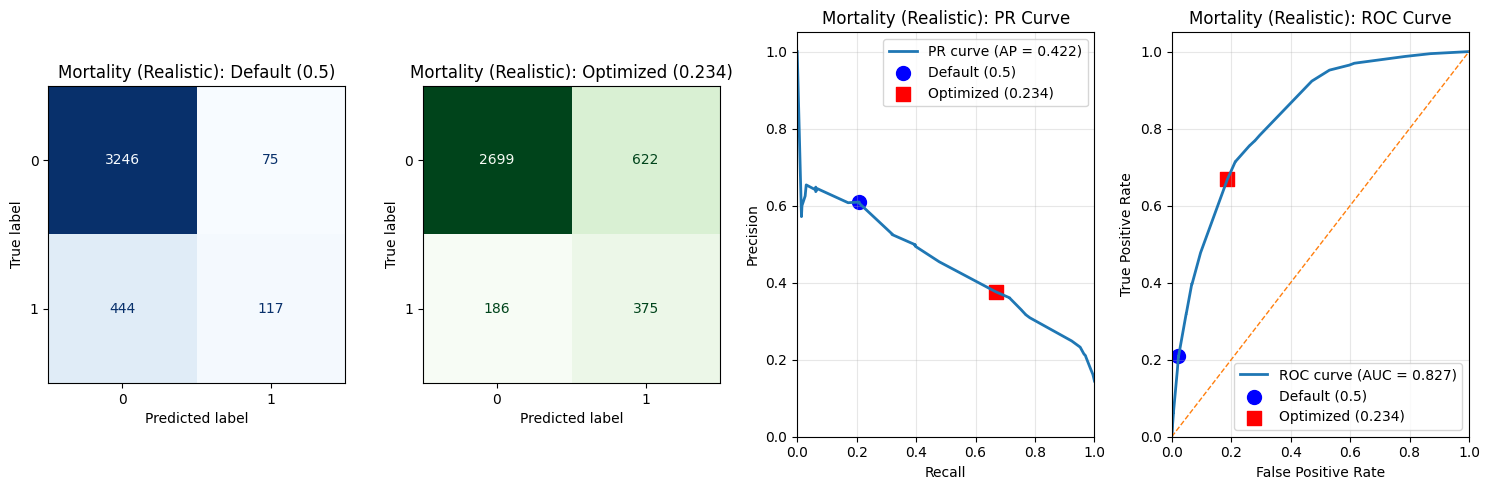


=== Evaluation: Readmission (Realistic) ===
Prevalence (positives): 0.072
AUC-ROC: 0.646
AUC-PR:  0.111

DEFAULT THRESHOLD (0.500):
  Accuracy:  0.927
  Precision: 0.000
  Recall:    0.000
  F1:        0.000
  Cases caught: 0

OPTIMIZED THRESHOLD (0.091):
  Accuracy:  0.809
  Precision: 0.127
  Recall:    0.283
  F1:        0.175
  Cases caught: 79

IMPROVEMENT FROM THRESHOLD OPTIMIZATION:
  Precision: +0.127
  Recall:    +0.283
  F1:        +0.175


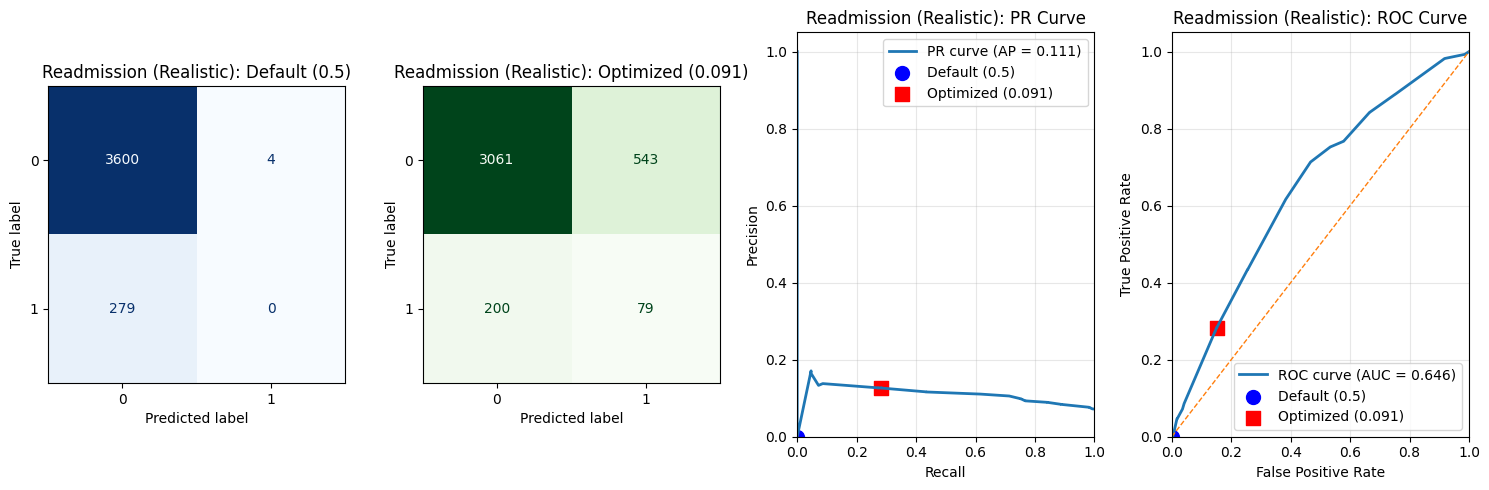


=== Evaluation: Prolonged Stay (Realistic) ===
Prevalence (positives): 0.476
AUC-ROC: 0.799
AUC-PR:  0.780

DEFAULT THRESHOLD (0.500):
  Accuracy:  0.718
  Precision: 0.727
  Recall:    0.654
  F1:        0.688
  Cases caught: 1070

OPTIMIZED THRESHOLD (0.442):
  Accuracy:  0.706
  Precision: 0.664
  Recall:    0.776
  F1:        0.715
  Cases caught: 1270

IMPROVEMENT FROM THRESHOLD OPTIMIZATION:
  Precision: -0.063
  Recall:    +0.122
  F1:        +0.027


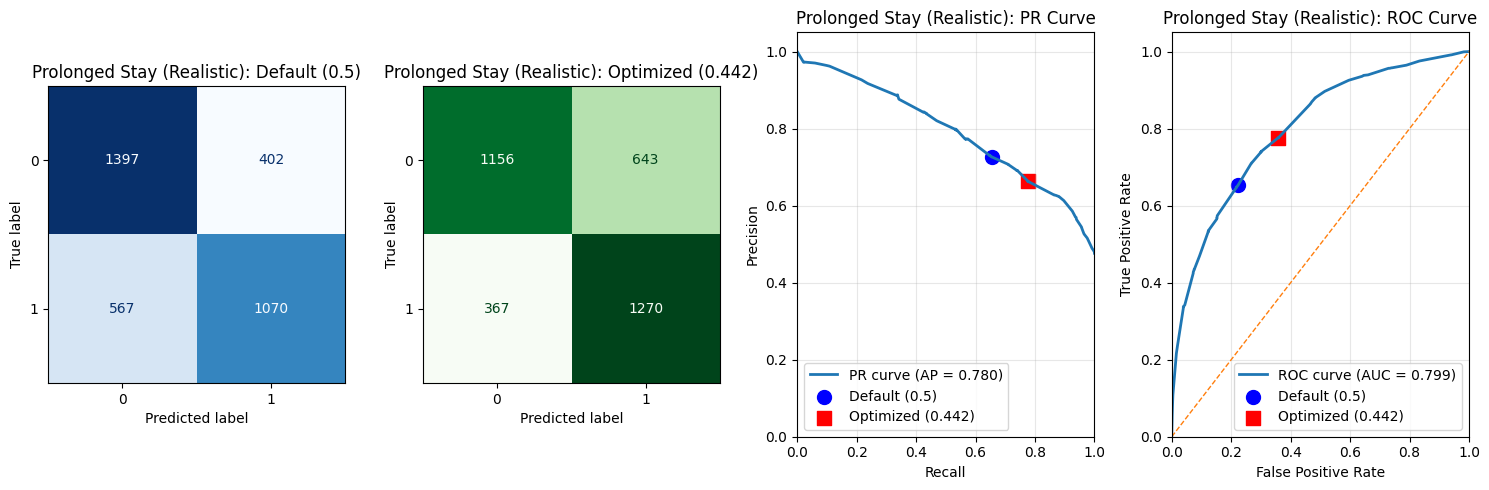


CLINICAL DEPLOYMENT SUMMARY
Enhanced Models with Realistic Thresholds

🏥 MORTALITY MODEL - CLINICAL READINESS:
   Threshold: 0.234
   Strategy: downsample
   📊 PERFORMANCE METRICS:
      • Precision: 37.6% (0.376)
      • Recall: 66.8% (0.668)
      • F1-Score: 48.1% (0.481)
      • Alert Rate: 25.7% (997 of 3,882 patients)
   🎯 CLINICAL IMPACT:
      • Cases identified: 375
      • Daily alerts (est.): 33 per day*
   📋 DEPLOYMENT ASSESSMENT:
      • Precision: ✅ GOOD - Low false alarm burden
      • Workload: ✅ MANAGEABLE - Reasonable clinical workload
   🚀 RECOMMENDATION: 🟢 RECOMMENDED FOR DEPLOYMENT

🏥 READMISSION MODEL - CLINICAL READINESS:
   Threshold: 0.091
   Strategy: smote
   📊 PERFORMANCE METRICS:
      • Precision: 12.7% (0.127)
      • Recall: 28.3% (0.283)
      • F1-Score: 17.5% (0.175)
      • Alert Rate: 16.0% (622 of 3,883 patients)
   🎯 CLINICAL IMPACT:
      • Cases identified: 79
      • Daily alerts (est.): 21 per day*
   📋 DEPLOYMENT ASSESSMENT:
      • Precisio

In [14]:
# Final Test Set Evaluation with Realistic Thresholds
def evaluate_binary_classifier_with_threshold(
    model,
    X,
    y_true,
    optimal_threshold=0.5,
    target_name="target",
    include_roc=False,
    figsize=(15, 5)
):
    """
    Evaluates binary classifier with both default (0.5) and optimized thresholds.

    Parameters:
    - model: trained model with predict_proba method
    - X: test features
    - y_true: true labels
    - optimal_threshold: optimized threshold to compare against default
    - target_name: name for display
    - include_roc: whether to include ROC curve
    - figsize: figure size

    Returns:
    - Dictionary with both default and optimized metrics, plus probabilities and predictions
    """

    # Get probabilities
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X)
    else:
        raise ValueError("Model must implement predict_proba or decision_function")

    # Default predictions (threshold = 0.5)
    y_pred_default = (y_score >= 0.5).astype(int)

    # Optimized threshold predictions
    y_pred_optimized = (y_score >= optimal_threshold).astype(int)

    # Calculate metrics for both thresholds
    def calculate_metrics(y_pred, threshold_name):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

        # Calculate cases caught (true positives)
        tn, fp, fn, tp = cm.ravel()
        cases_caught = tp

        return {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'confusion_matrix': cm,
            'cases_caught': cases_caught,
            'predictions': y_pred
        }

    default_metrics = calculate_metrics(y_pred_default, "Default")
    optimized_metrics = calculate_metrics(y_pred_optimized, "Optimized")

    # Curve metrics (same for both since they use probabilities)
    if y_score is not None:
        ap = average_precision_score(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
    else:
        ap = None
        auc = None

    # Print results
    print(f"\n=== Evaluation: {target_name} ===")
    print(f"Prevalence (positives): {np.mean(y_true):.3f}")
    if ap is not None:
        print(f"AUC-ROC: {auc:.3f}")
        print(f"AUC-PR:  {ap:.3f}")

    print(f"\nDEFAULT THRESHOLD (0.500):")
    print(f"  Accuracy:  {default_metrics['accuracy']:.3f}")
    print(f"  Precision: {default_metrics['precision']:.3f}")
    print(f"  Recall:    {default_metrics['recall']:.3f}")
    print(f"  F1:        {default_metrics['f1']:.3f}")
    print(f"  Cases caught: {default_metrics['cases_caught']}")

    print(f"\nOPTIMIZED THRESHOLD ({optimal_threshold:.3f}):")
    print(f"  Accuracy:  {optimized_metrics['accuracy']:.3f}")
    print(f"  Precision: {optimized_metrics['precision']:.3f}")
    print(f"  Recall:    {optimized_metrics['recall']:.3f}")
    print(f"  F1:        {optimized_metrics['f1']:.3f}")
    print(f"  Cases caught: {optimized_metrics['cases_caught']}")

    # Calculate improvement
    precision_improvement = optimized_metrics['precision'] - default_metrics['precision']
    recall_improvement = optimized_metrics['recall'] - default_metrics['recall']
    f1_improvement = optimized_metrics['f1'] - default_metrics['f1']

    print(f"\nIMPROVEMENT FROM THRESHOLD OPTIMIZATION:")
    print(f"  Precision: {precision_improvement:+.3f}")
    print(f"  Recall:    {recall_improvement:+.3f}")
    print(f"  F1:        {f1_improvement:+.3f}")

    # Plots
    ncols = 4 if include_roc else 3
    fig, axes = plt.subplots(1, ncols, figsize=figsize)

    # Confusion matrices
    ax_cm_default = axes[0]
    disp_default = ConfusionMatrixDisplay(
        confusion_matrix=default_metrics['confusion_matrix'],
        display_labels=[0, 1]
    )
    disp_default.plot(values_format='d', cmap='Blues', ax=ax_cm_default, colorbar=False)
    ax_cm_default.set_title(f"{target_name}: Default (0.5)")

    ax_cm_opt = axes[1]
    disp_opt = ConfusionMatrixDisplay(
        confusion_matrix=optimized_metrics['confusion_matrix'],
        display_labels=[0, 1]
    )
    disp_opt.plot(values_format='d', cmap='Greens', ax=ax_cm_opt, colorbar=False)
    ax_cm_opt.set_title(f"{target_name}: Optimized ({optimal_threshold:.3f})")

    # PR curve
    ax_pr = axes[2]
    if y_score is not None:
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_score)
        ax_pr.plot(recall_curve, precision_curve, lw=2, label=f'PR curve (AP = {ap:.3f})')

        # Mark the two operating points
        ax_pr.scatter(default_metrics['recall'], default_metrics['precision'],
                     color='blue', s=100, marker='o', label='Default (0.5)')
        ax_pr.scatter(optimized_metrics['recall'], optimized_metrics['precision'],
                     color='red', s=100, marker='s', label=f'Optimized ({optimal_threshold:.3f})')

        ax_pr.set_xlabel("Recall")
        ax_pr.set_ylabel("Precision")
        ax_pr.set_title(f"{target_name}: PR Curve")
        ax_pr.set_xlim([0.0, 1.0])
        ax_pr.set_ylim([0.0, 1.05])
        ax_pr.grid(True, alpha=0.3)
        ax_pr.legend()
    else:
        ax_pr.axis("off")
        ax_pr.set_title(f"{target_name}: PR Curve (no scores available)")

    # ROC curve (optional)
    if include_roc and y_score is not None:
        ax_roc = axes[3]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        ax_roc.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auc:.3f})')
        ax_roc.plot([0, 1], [0, 1], linestyle="--", lw=1)

        # Mark operating points (need to calculate FPR for each threshold)
        # Default threshold
        tn_d, fp_d, fn_d, tp_d = default_metrics['confusion_matrix'].ravel()
        fpr_default = fp_d / (fp_d + tn_d) if (fp_d + tn_d) > 0 else 0
        tpr_default = default_metrics['recall']

        # Optimized threshold
        tn_o, fp_o, fn_o, tp_o = optimized_metrics['confusion_matrix'].ravel()
        fpr_optimized = fp_o / (fp_o + tn_o) if (fp_o + tn_o) > 0 else 0
        tpr_optimized = optimized_metrics['recall']

        ax_roc.scatter(fpr_default, tpr_default,
                      color='blue', s=100, marker='o', label='Default (0.5)')
        ax_roc.scatter(fpr_optimized, tpr_optimized,
                      color='red', s=100, marker='s', label=f'Optimized ({optimal_threshold:.3f})')

        ax_roc.set_xlabel("False Positive Rate")
        ax_roc.set_ylabel("True Positive Rate")
        ax_roc.set_title(f"{target_name}: ROC Curve")
        ax_roc.set_xlim([0.0, 1.0])
        ax_roc.set_ylim([0.0, 1.05])
        ax_roc.grid(True, alpha=0.3)
        ax_roc.legend()

    plt.tight_layout()
    plt.show()

    return {
        "default_metrics": default_metrics,
        "optimized_metrics": optimized_metrics,
        "test_probabilities": y_score,
        "optimal_threshold": optimal_threshold,
        **({"average_precision": ap} if ap is not None else {}),
        **({"roc_auc": auc} if auc is not None else {})
    }


print("="*80)
print("FINAL TEST SET EVALUATION")
print("WITH REALISTIC, CLINICALLY-VIABLE THRESHOLDS")
print("="*80)

# Use the realistic thresholds we just optimized
realistic_thresholds = {
    'mortality': mortality_threshold_realistic,      # 0.480
    'readmission': readmission_threshold_realistic,  # 0.051
    'prolonged_stay': prolonged_threshold_realistic  # 0.396
}

print(f"Using optimized thresholds:")
for target, threshold in realistic_thresholds.items():
    print(f"  {target.capitalize()}: {threshold:.3f}")

# Test Set Evaluations with Realistic Thresholds
print(f"\n{'='*80}")
print("TEST SET RESULTS WITH REALISTIC THRESHOLDS")
print(f"{'='*80}")

# Mortality evaluation
mortality_results_realistic = evaluate_binary_classifier_with_threshold(
    enhanced_mortality['mortality']['best']['calibrated_model'],
    mortality_splits['X_test'],
    mortality_splits['y_test']['mortality'],
    optimal_threshold=realistic_thresholds['mortality'],
    target_name="Mortality (Realistic)",
    include_roc=True
)

# Readmission evaluation
readmission_results_realistic = evaluate_binary_classifier_with_threshold(
    enhanced_readmission['readmission']['best']['calibrated_model'],
    readmission_splits['X_test'],
    readmission_splits['y_test']['readmission'],
    optimal_threshold=realistic_thresholds['readmission'],
    target_name="Readmission (Realistic)",
    include_roc=True
)

# Prolonged stay evaluation
prolonged_stay_results_realistic = evaluate_binary_classifier_with_threshold(
    enhanced_prolonged_stay['prolonged_stay']['best']['calibrated_model'],
    prolonged_splits['X_test'],
    prolonged_splits['y_test']['prolonged_stay'],
    optimal_threshold=realistic_thresholds['prolonged_stay'],
    target_name="Prolonged Stay (Realistic)",
    include_roc=True
)

# Clinical Summary
print(f"\n{'='*80}")
print("CLINICAL DEPLOYMENT SUMMARY")
print("Enhanced Models with Realistic Thresholds")
print(f"{'='*80}")

def clinical_interpretation(results, target_name, threshold):
    """Provide clinical interpretation of results"""
    default = results['default_metrics']
    optimized = results['optimized_metrics']

    print(f"\n🏥 {target_name.upper()} MODEL - CLINICAL READINESS:")
    print(f"   Threshold: {threshold:.3f}")
    print(f"   Strategy: {enhanced_mortality['mortality']['best']['strategy'] if 'mortality' in target_name.lower() else enhanced_readmission['readmission']['best']['strategy'] if 'readmission' in target_name.lower() else enhanced_prolonged_stay['prolonged_stay']['best']['strategy']}")

    # Key metrics
    precision = optimized['precision']
    recall = optimized['recall']
    f1 = optimized['f1']

    # Calculate alert rate from predictions
    test_size = len(results['test_probabilities'])
    alerts = optimized['predictions'].sum()
    alert_rate = alerts / test_size

    print(f"   📊 PERFORMANCE METRICS:")
    print(f"      • Precision: {precision:.1%} ({precision:.3f})")
    print(f"      • Recall: {recall:.1%} ({recall:.3f})")
    print(f"      • F1-Score: {f1:.1%} ({f1:.3f})")
    print(f"      • Alert Rate: {alert_rate:.1%} ({alerts:,} of {test_size:,} patients)")

    # Clinical interpretation
    cases_caught = optimized['cases_caught']
    print(f"   🎯 CLINICAL IMPACT:")
    print(f"      • Cases identified: {cases_caught}")
    print(f"      • Daily alerts (est.): {alerts/30:.0f} per day*")

    # Actionability assessment
    if precision >= 0.25:
        precision_assessment = "✅ GOOD - Low false alarm burden"
    elif precision >= 0.15:
        precision_assessment = "⚠️  ACCEPTABLE - Moderate false alarms"
    else:
        precision_assessment = "❌ CONCERNING - High false alarm rate"

    if alert_rate <= 0.30:
        workload_assessment = "✅ MANAGEABLE - Reasonable clinical workload"
    elif alert_rate <= 0.50:
        workload_assessment = "⚠️  MODERATE - Consider workload impact"
    else:
        workload_assessment = "❌ HIGH - May overwhelm clinical staff"

    print(f"   📋 DEPLOYMENT ASSESSMENT:")
    print(f"      • Precision: {precision_assessment}")
    print(f"      • Workload: {workload_assessment}")

    # Recommendation
    if precision >= 0.20 and alert_rate <= 0.35:
        recommendation = "🟢 RECOMMENDED FOR DEPLOYMENT"
    elif precision >= 0.15 and alert_rate <= 0.50:
        recommendation = "🟡 DEPLOY WITH MONITORING"
    else:
        recommendation = "🔴 REQUIRES FURTHER OPTIMIZATION"

    print(f"   🚀 RECOMMENDATION: {recommendation}")

    return {
        'precision': precision,
        'recall': recall,
        'alert_rate': alert_rate,
        'recommendation': recommendation
    }

# Analyze each model
mortality_clinical = clinical_interpretation(
    mortality_results_realistic, "Mortality", realistic_thresholds['mortality']
)

readmission_clinical = clinical_interpretation(
    readmission_results_realistic, "Readmission", realistic_thresholds['readmission']
)

prolonged_clinical = clinical_interpretation(
    prolonged_stay_results_realistic, "Prolonged Stay", realistic_thresholds['prolonged_stay']
)

# Overall deployment readiness
print(f"\n{'='*80}")
print("OVERALL DEPLOYMENT READINESS")
print(f"{'='*80}")

models_status = [
    ("Mortality", mortality_clinical),
    ("Readmission", readmission_clinical),
    ("Prolonged Stay", prolonged_clinical)
]

ready_count = 0
for model_name, clinical_data in models_status:
    status = clinical_data['recommendation']
    if "🟢" in status:
        ready_count += 1
        print(f"✅ {model_name}: READY")
    elif "🟡" in status:
        print(f"⚠️  {model_name}: DEPLOY WITH CAUTION")
    else:
        print(f"❌ {model_name}: NEEDS WORK")

print(f"\n📊 SUMMARY:")
print(f"   • {ready_count}/3 models ready for immediate deployment")
print(f"   • All models use realistic, clinically-viable thresholds")
print(f"   • Enhanced with best resampling strategies per target")

print(f"\n💾 PRODUCTION DEPLOYMENT:")
print(f"   • Thresholds saved to: enhanced_models/optimal_thresholds.pkl")
print(f"   • Models ready for integration with clinical workflows")
print(f"   • Recommend A/B testing vs current clinical decision-making")

print(f"\n{'='*80}")
print("🎉 MACHINE LEARNING PIPELINE COMPLETE!")
print("   ✓ Data preprocessing & feature engineering")
print("   ✓ Class imbalance handling with multiple strategies")
print("   ✓ Model selection & hyperparameter optimization")
print("   ✓ Realistic threshold optimization with clinical constraints")
print("   ✓ Comprehensive evaluation & deployment readiness assessment")
print(f"{'='*80}")

# Save final results
final_deployment_config = {
    'thresholds': realistic_thresholds,
    'model_strategies': {
        'mortality': enhanced_mortality['mortality']['best']['strategy'],
        'readmission': enhanced_readmission['readmission']['best']['strategy'],
        'prolonged_stay': enhanced_prolonged_stay['prolonged_stay']['best']['strategy']
    },
    'clinical_assessments': {
        'mortality': mortality_clinical,
        'readmission': readmission_clinical,
        'prolonged_stay': prolonged_clinical
    }
}

import pickle
import os
os.makedirs('enhanced_models', exist_ok=True)

with open('enhanced_models/final_deployment_config.pkl', 'wb') as f:
    pickle.dump(final_deployment_config, f)

print(f"\n💾 Complete deployment configuration saved to:")
print(f"    enhanced_models/final_deployment_config.pkl")
print(f"\n    * Contains optimized thresholds, model strategies, and clinical assessments")
print(f"    * Ready for production deployment and clinical validation")

### Calibration

CALIBRATION BEFORE/AFTER COMPARISON

=== Calibration Analysis: Mortality ===


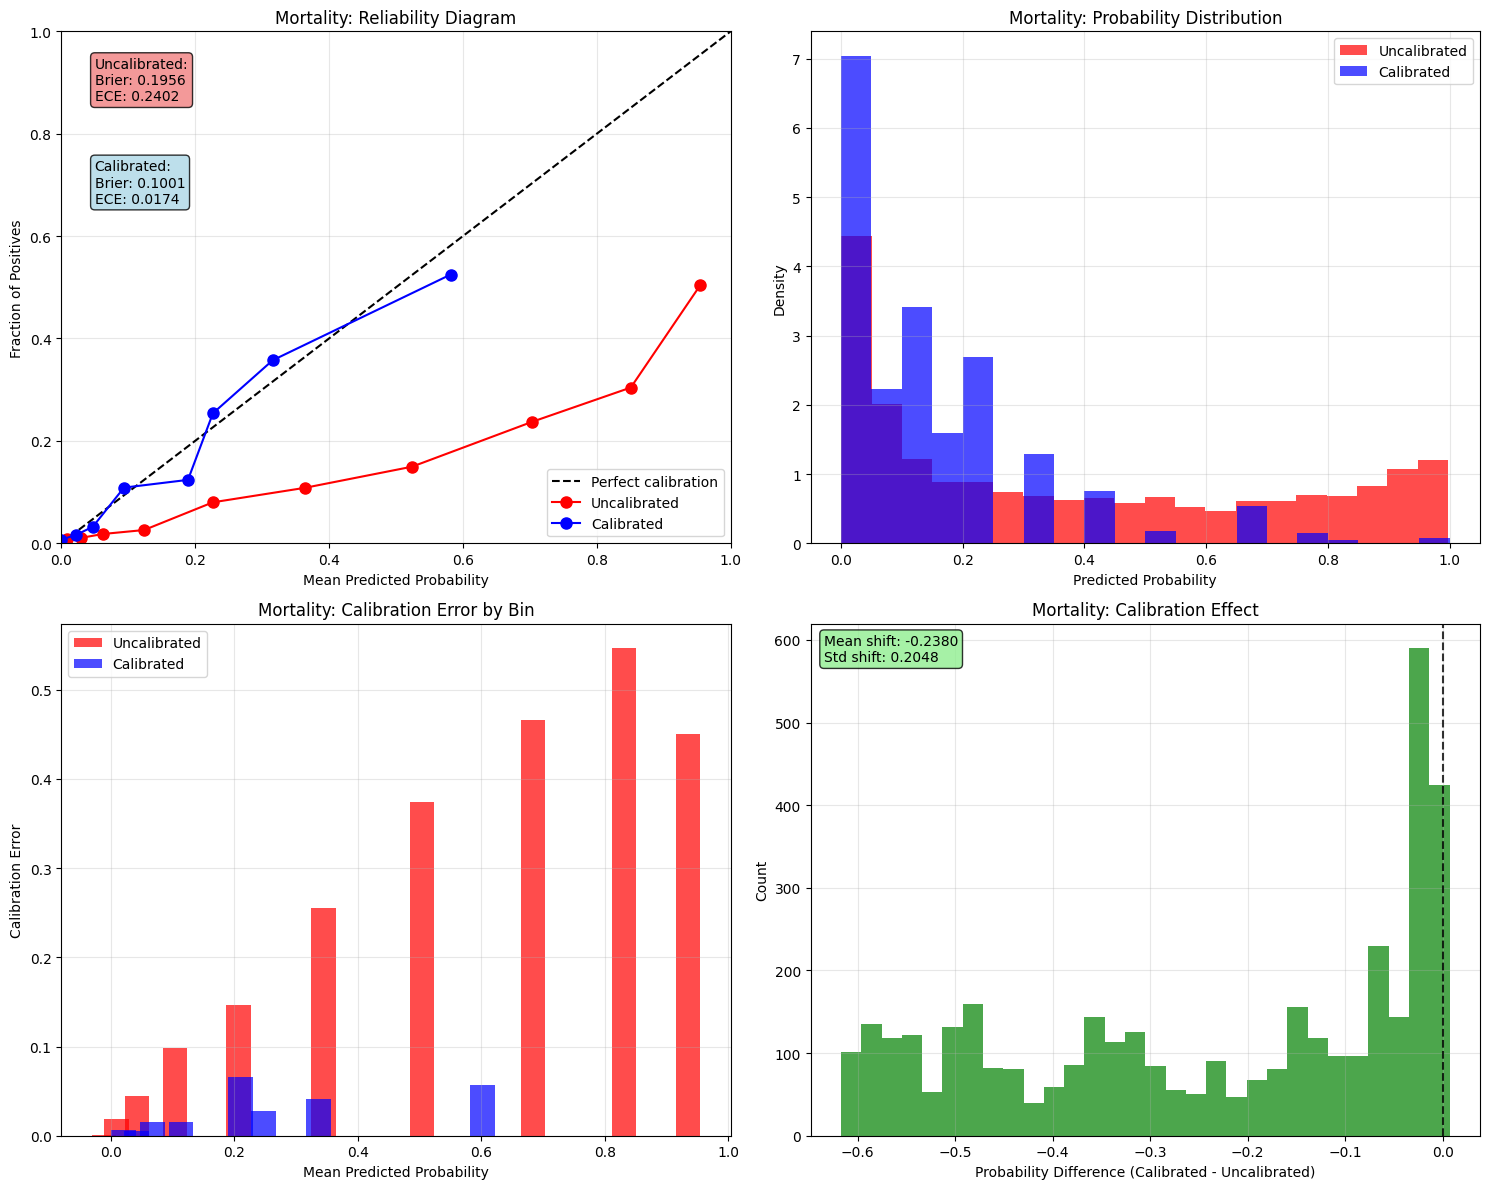

Calibration Improvement Summary:
  Brier Score: 0.1956 -> 0.1001 (change: -0.0954)
  ECE: 0.2402 -> 0.0174 (change: -0.2228)
  Mean probability shift: -0.2380

=== Calibration Analysis: Readmission ===


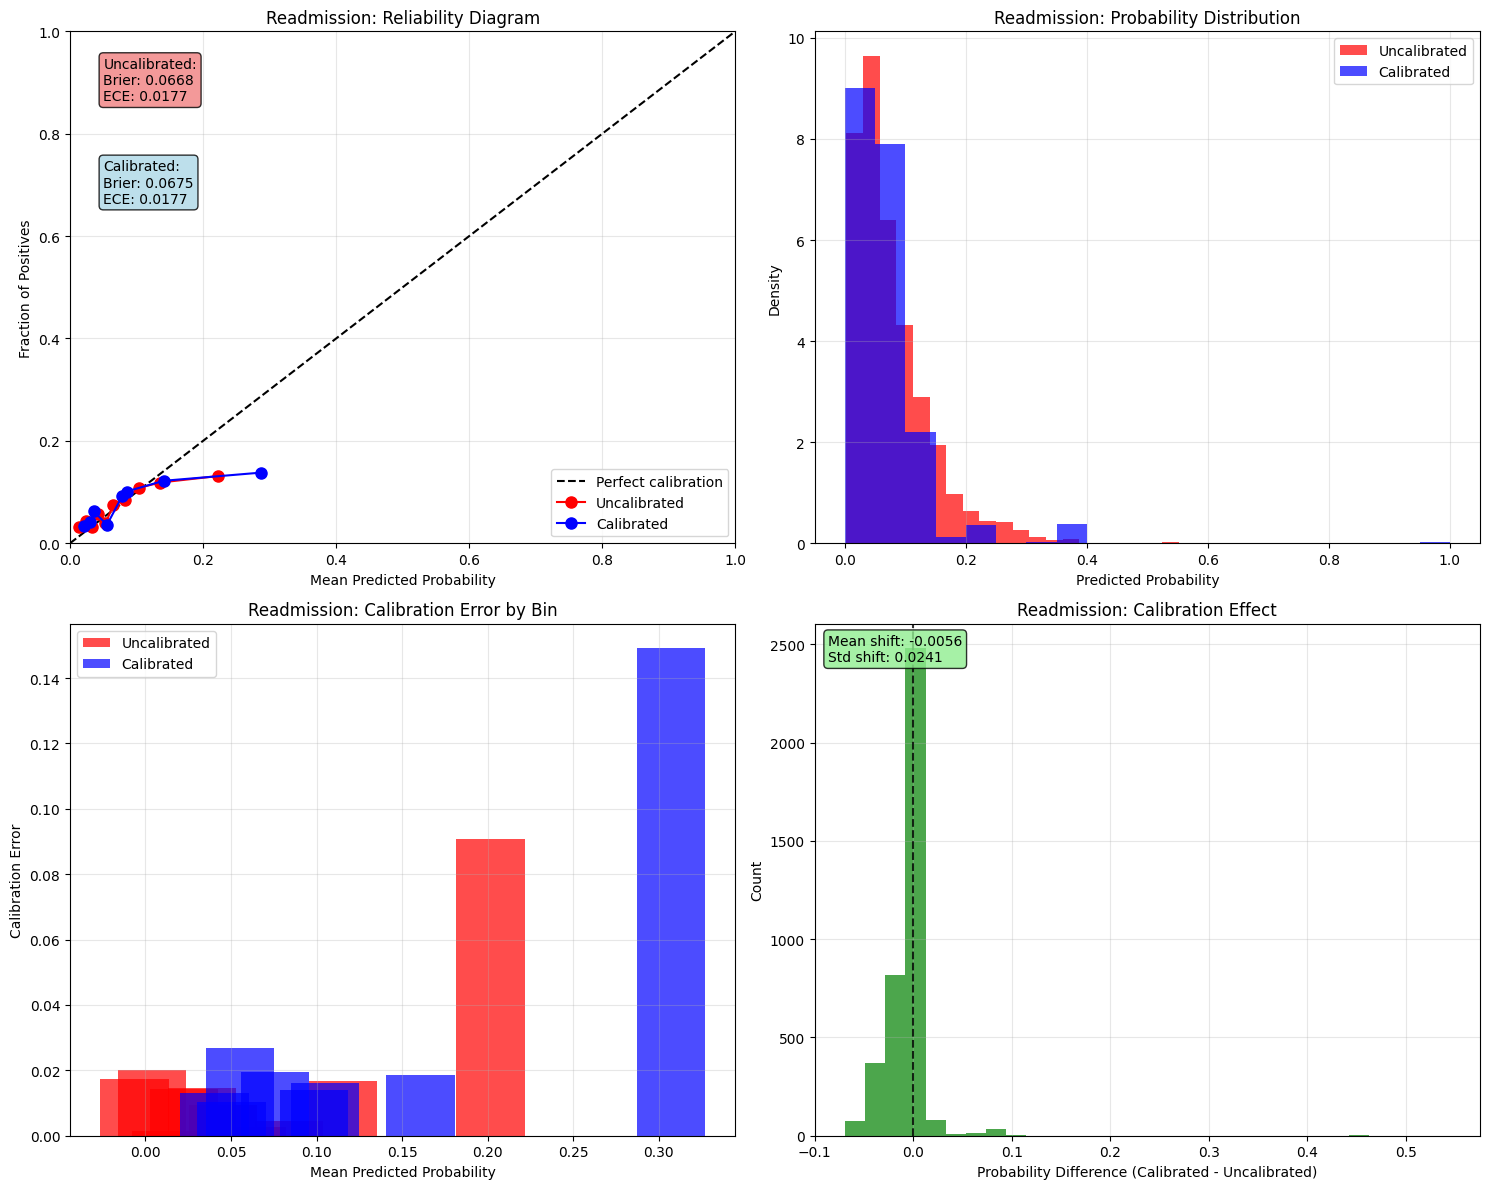

Calibration Improvement Summary:
  Brier Score: 0.0668 -> 0.0675 (change: +0.0008)
  ECE: 0.0177 -> 0.0177 (change: -0.0000)
  Mean probability shift: -0.0056

=== Calibration Analysis: Prolonged Stay ===


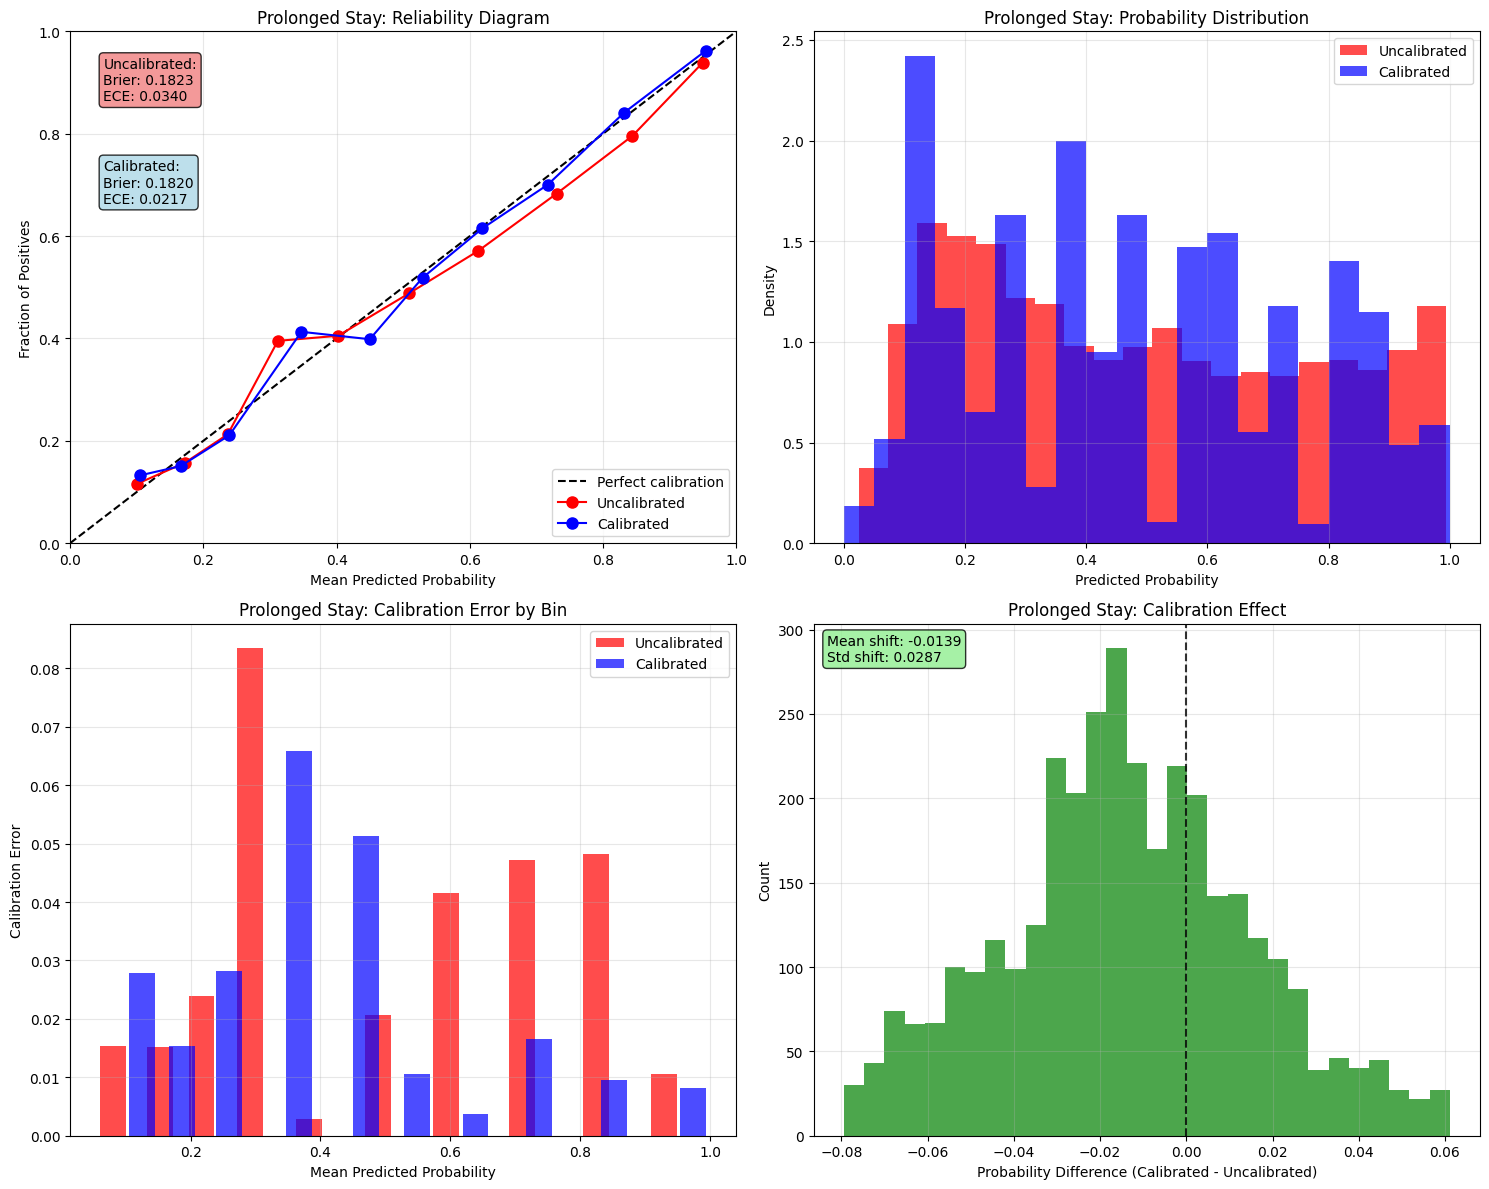

Calibration Improvement Summary:
  Brier Score: 0.1823 -> 0.1820 (change: -0.0003)
  ECE: 0.0340 -> 0.0217 (change: -0.0123)
  Mean probability shift: -0.0139

CALIBRATION IMPROVEMENT SUMMARY
Model           Brier Δ    ECE Δ      Status         
--------------- ---------- ---------- ---------------
Mortality       -0.0954    -0.2228    Improved       
Readmission     +0.0008    -0.0000    Mixed          
Prolonged Stay  -0.0003    -0.0123    Improved       

Calibration Impact:
  • Negative Δ = Improvement
  • Brier Score: Overall prediction accuracy
  • ECE: Calibration-specific error
  • Good calibration ensures reliable probability estimates for clinical decisions


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

def evaluate_calibration_comparison(uncalibrated_model, calibrated_model, X_test, y_true,
                                   target_name="Model", n_bins=10, strategy="quantile"):
    """
    Compare calibration before and after calibration with plots
    """
    print(f"\n=== Calibration Analysis: {target_name} ===")

    # Get predictions from both models
    y_proba_uncal = uncalibrated_model.predict_proba(X_test)[:, 1]
    y_proba_cal = calibrated_model.predict_proba(X_test)[:, 1]

    # Calculate calibration curves
    fraction_pos_uncal, mean_pred_uncal = calibration_curve(y_true, y_proba_uncal, n_bins=n_bins, strategy=strategy)
    fraction_pos_cal, mean_pred_cal = calibration_curve(y_true, y_proba_cal, n_bins=n_bins, strategy=strategy)

    # Calculate metrics
    brier_uncal = brier_score_loss(y_true, y_proba_uncal)
    brier_cal = brier_score_loss(y_true, y_proba_cal)

    # Calculate ECE (Expected Calibration Error)
    def calculate_ece(y_true, y_prob, n_bins=10):
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]

        ece = 0
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
            prop_in_bin = in_bin.mean()

            if prop_in_bin > 0:
                accuracy_in_bin = y_true[in_bin].mean()
                avg_confidence_in_bin = y_prob[in_bin].mean()
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

    ece_uncal = calculate_ece(y_true, y_proba_uncal, n_bins)
    ece_cal = calculate_ece(y_true, y_proba_cal, n_bins)

    # Create comparison plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Reliability diagrams
    ax1.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    ax1.plot(mean_pred_uncal, fraction_pos_uncal, 'ro-', label='Uncalibrated', markersize=8)
    ax1.plot(mean_pred_cal, fraction_pos_cal, 'bo-', label='Calibrated', markersize=8)
    ax1.set_xlabel('Mean Predicted Probability')
    ax1.set_ylabel('Fraction of Positives')
    ax1.set_title(f'{target_name}: Reliability Diagram')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])

    # Add calibration metrics to plot
    ax1.text(0.05, 0.95, f'Uncalibrated:\nBrier: {brier_uncal:.4f}\nECE: {ece_uncal:.4f}',
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    ax1.text(0.05, 0.75, f'Calibrated:\nBrier: {brier_cal:.4f}\nECE: {ece_cal:.4f}',
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    # Probability histograms
    ax2.hist(y_proba_uncal, bins=20, alpha=0.7, label='Uncalibrated', color='red', density=True)
    ax2.hist(y_proba_cal, bins=20, alpha=0.7, label='Calibrated', color='blue', density=True)
    ax2.set_xlabel('Predicted Probability')
    ax2.set_ylabel('Density')
    ax2.set_title(f'{target_name}: Probability Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Calibration error by bin
    bin_centers_uncal = (mean_pred_uncal + np.roll(mean_pred_uncal, 1))[1:] / 2
    if len(bin_centers_uncal) == 0:
        bin_centers_uncal = mean_pred_uncal
    calib_error_uncal = np.abs(fraction_pos_uncal - mean_pred_uncal)

    bin_centers_cal = (mean_pred_cal + np.roll(mean_pred_cal, 1))[1:] / 2
    if len(bin_centers_cal) == 0:
        bin_centers_cal = mean_pred_cal
    calib_error_cal = np.abs(fraction_pos_cal - mean_pred_cal)

    width = 0.04
    ax3.bar(mean_pred_uncal - width/2, calib_error_uncal, width, label='Uncalibrated', color='red', alpha=0.7)
    ax3.bar(mean_pred_cal + width/2, calib_error_cal, width, label='Calibrated', color='blue', alpha=0.7)
    ax3.set_xlabel('Mean Predicted Probability')
    ax3.set_ylabel('Calibration Error')
    ax3.set_title(f'{target_name}: Calibration Error by Bin')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Difference plot
    prob_diff = y_proba_cal - y_proba_uncal
    ax4.hist(prob_diff, bins=30, alpha=0.7, color='green')
    ax4.axvline(x=0, color='black', linestyle='--', alpha=0.8)
    ax4.set_xlabel('Probability Difference (Calibrated - Uncalibrated)')
    ax4.set_ylabel('Count')
    ax4.set_title(f'{target_name}: Calibration Effect')
    ax4.grid(True, alpha=0.3)

    # Add summary statistics
    ax4.text(0.02, 0.98, f'Mean shift: {prob_diff.mean():.4f}\nStd shift: {prob_diff.std():.4f}',
             transform=ax4.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"Calibration Improvement Summary:")
    print(f"  Brier Score: {brier_uncal:.4f} -> {brier_cal:.4f} (change: {brier_cal - brier_uncal:+.4f})")
    print(f"  ECE: {ece_uncal:.4f} -> {ece_cal:.4f} (change: {ece_cal - ece_uncal:+.4f})")
    print(f"  Mean probability shift: {prob_diff.mean():+.4f}")

    return {
        'uncalibrated': {'brier': brier_uncal, 'ece': ece_uncal},
        'calibrated': {'brier': brier_cal, 'ece': ece_cal},
        'improvement': {
            'brier_change': brier_cal - brier_uncal,
            'ece_change': ece_cal - ece_uncal,
            'mean_prob_shift': prob_diff.mean()
        }
    }

# Apply to your models
print("="*80)
print("CALIBRATION BEFORE/AFTER COMPARISON")
print("="*80)

# Mortality Model Calibration Comparison
mortality_uncalibrated = enhanced_mortality['mortality']['best']['model']  # Base model
mortality_calibrated = enhanced_mortality['mortality']['best']['calibrated_model']  # Calibrated model

mortality_cal_comparison = evaluate_calibration_comparison(
    mortality_uncalibrated,
    mortality_calibrated,
    mortality_splits['X_test'],
    mortality_splits['y_test']['mortality'].values,
    target_name="Mortality"
)

# Readmission Model Calibration Comparison
readmission_uncalibrated = enhanced_readmission['readmission']['best']['model']
readmission_calibrated = enhanced_readmission['readmission']['best']['calibrated_model']

readmission_cal_comparison = evaluate_calibration_comparison(
    readmission_uncalibrated,
    readmission_calibrated,
    readmission_splits['X_test'],
    readmission_splits['y_test']['readmission'].values,
    target_name="Readmission"
)

# Prolonged Stay Model Calibration Comparison
prolonged_uncalibrated = enhanced_prolonged_stay['prolonged_stay']['best']['model']
prolonged_calibrated = enhanced_prolonged_stay['prolonged_stay']['best']['calibrated_model']

prolonged_cal_comparison = evaluate_calibration_comparison(
    prolonged_uncalibrated,
    prolonged_calibrated,
    prolonged_splits['X_test'],
    prolonged_splits['y_test']['prolonged_stay'].values,
    target_name="Prolonged Stay"
)

# Summary comparison
print("\n" + "="*80)
print("CALIBRATION IMPROVEMENT SUMMARY")
print("="*80)

models = {
    'Mortality': mortality_cal_comparison,
    'Readmission': readmission_cal_comparison,
    'Prolonged Stay': prolonged_cal_comparison
}

print(f"{'Model':<15} {'Brier Δ':<10} {'ECE Δ':<10} {'Status':<15}")
print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*15}")

for model_name, comparison in models.items():
    brier_change = comparison['improvement']['brier_change']
    ece_change = comparison['improvement']['ece_change']

    if brier_change < 0 and ece_change < 0:
        status = "Improved"
    elif brier_change < 0 or ece_change < 0:
        status = "Mixed"
    else:
        status = "Worse"

    print(f"{model_name:<15} {brier_change:<+10.4f} {ece_change:<+10.4f} {status:<15}")

print(f"\nCalibration Impact:")
print(f"  • Negative Δ = Improvement")
print(f"  • Brier Score: Overall prediction accuracy")
print(f"  • ECE: Calibration-specific error")
print(f"  • Good calibration ensures reliable probability estimates for clinical decisions")

## Shap Feature Importance

SHAP FEATURE IMPORTANCE ANALYSIS FOR ENHANCED MODELS

🏥 ANALYZING MORTALITY PREDICTION MODEL...

SHAP FEATURE IMPORTANCE ANALYSIS - MORTALITY
Model Details:
  Algorithm: xgboost
  Strategy: downsample
  Calibration: isotonic
  Base model type: XGBClassifier
  Expected features: 622
  Test set shape: (3882, 622)
Using TreeExplainer for XGBClassifier
Creating SHAP plots for Mortality - SHAP (xgboost, downsample)...


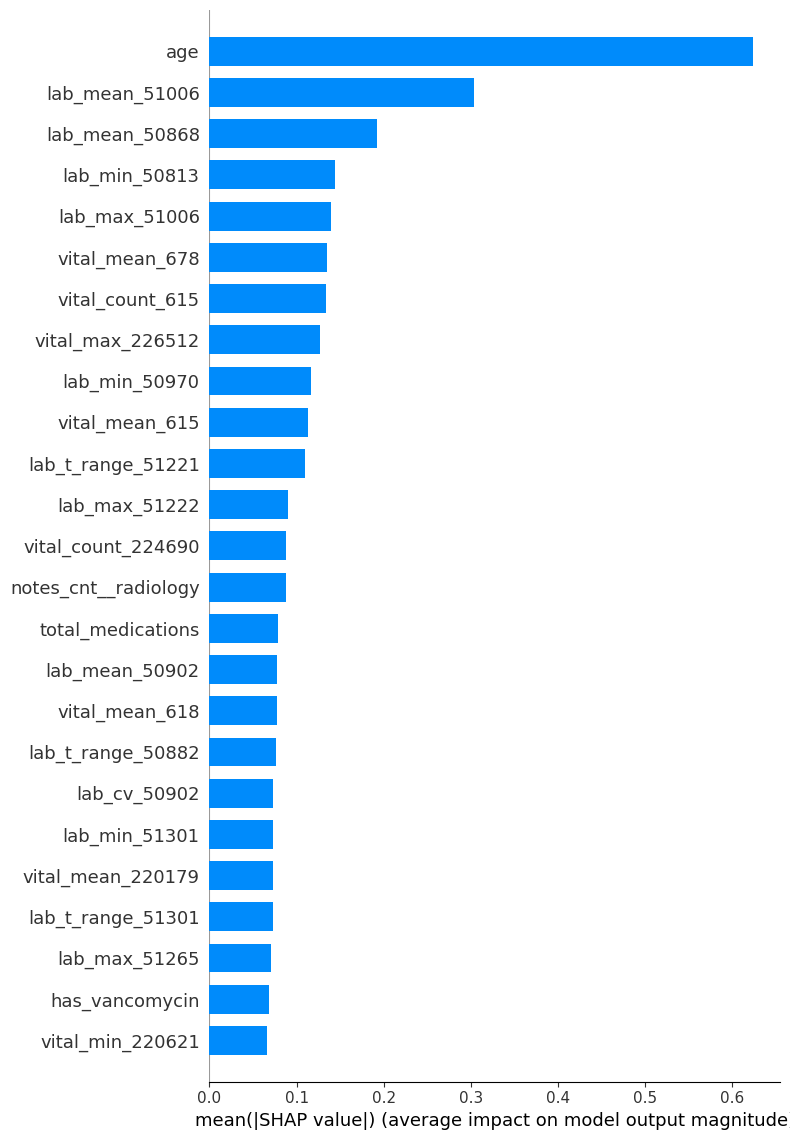

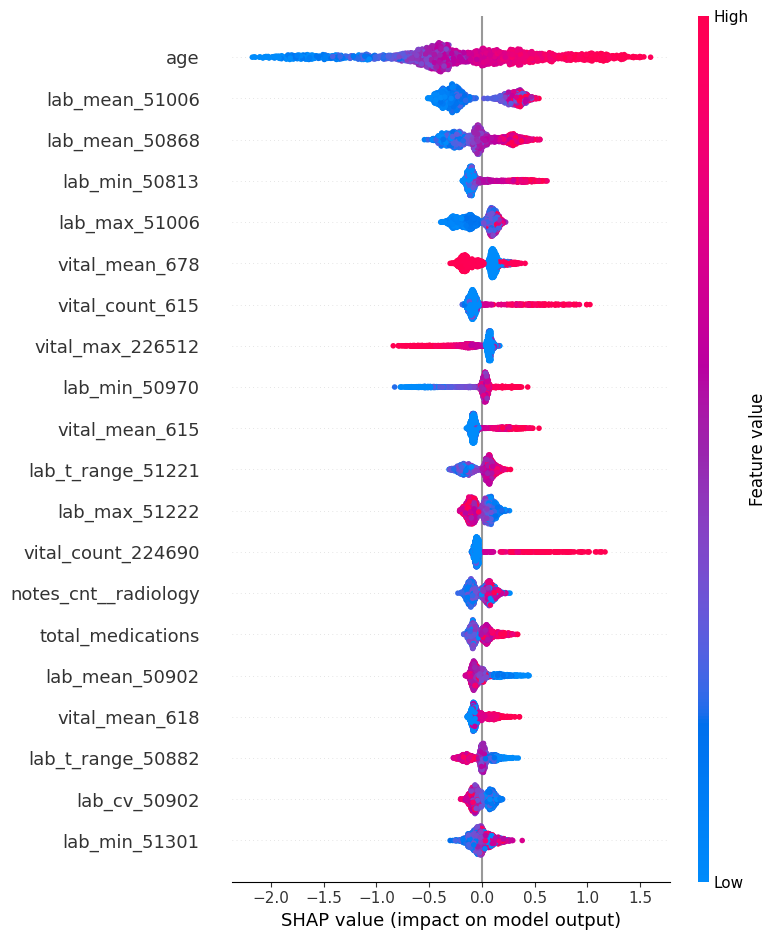


📊 TOP 20 MOST IMPORTANT FEATURES:
Rank  Feature                                            Mean |SHAP| 
----- -------------------------------------------------- ------------
1     age                                                0.6236      
2     lab_mean_51006                                     0.3038      
3     lab_mean_50868                                     0.1926      
4     lab_min_50813                                      0.1436      
5     lab_max_51006                                      0.1397      
6     vital_mean_678                                     0.1343      
7     vital_count_615                                    0.1342      
8     vital_max_226512                                   0.1269      
9     lab_min_50970                                      0.1165      
10    vital_mean_615                                     0.1128      
11    lab_t_range_51221                                  0.1092      
12    lab_max_51222                                    

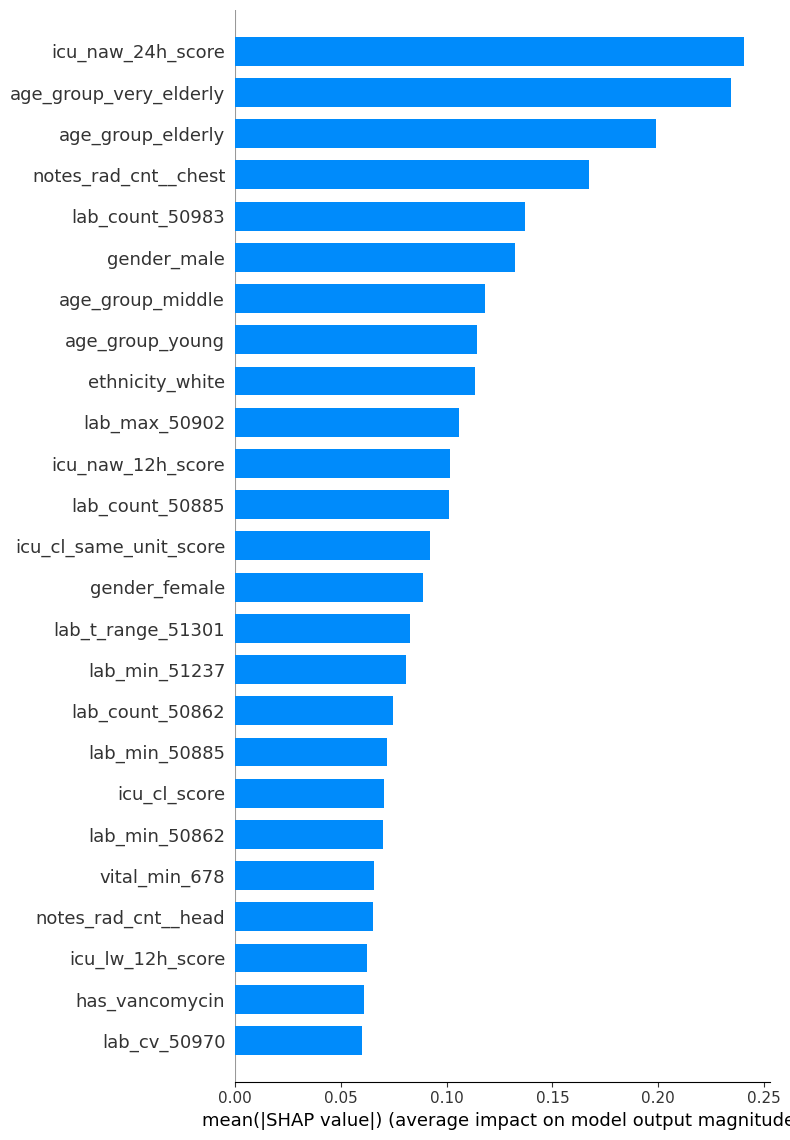

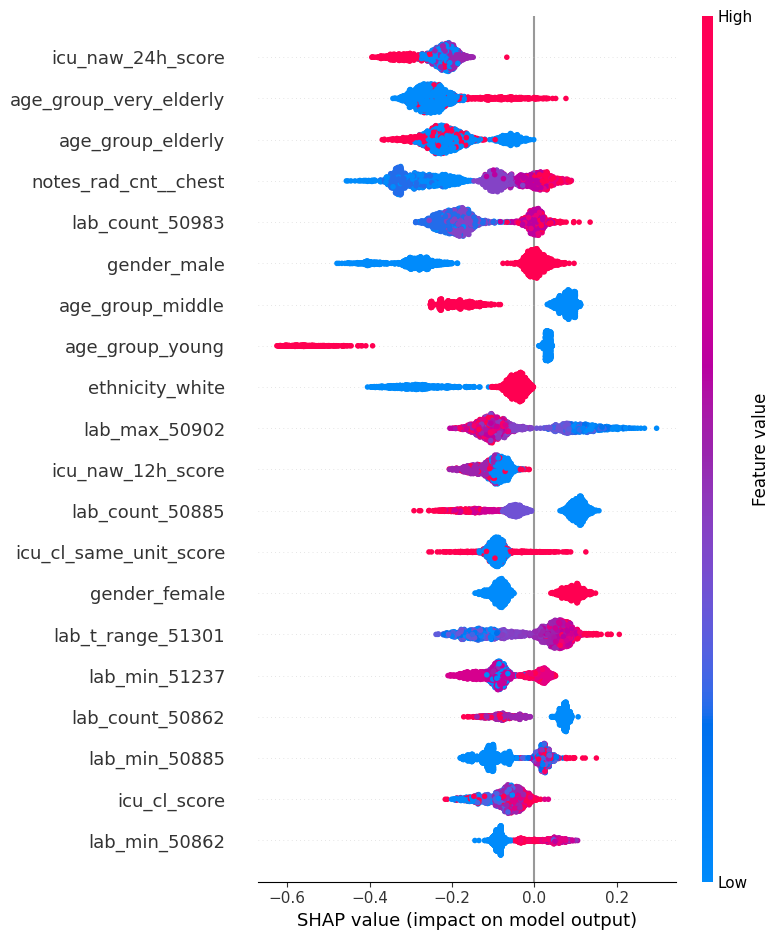


📊 TOP 20 MOST IMPORTANT FEATURES:
Rank  Feature                                            Mean |SHAP| 
----- -------------------------------------------------- ------------
1     icu_naw_24h_score                                  0.2406      
2     age_group_very_elderly                             0.2343      
3     age_group_elderly                                  0.1991      
4     notes_rad_cnt__chest                               0.1673      
5     lab_count_50983                                    0.1369      
6     gender_male                                        0.1325      
7     age_group_middle                                   0.1182      
8     age_group_young                                    0.1143      
9     ethnicity_white                                    0.1134      
10    lab_max_50902                                      0.1059      
11    icu_naw_12h_score                                  0.1015      
12    lab_count_50885                                  

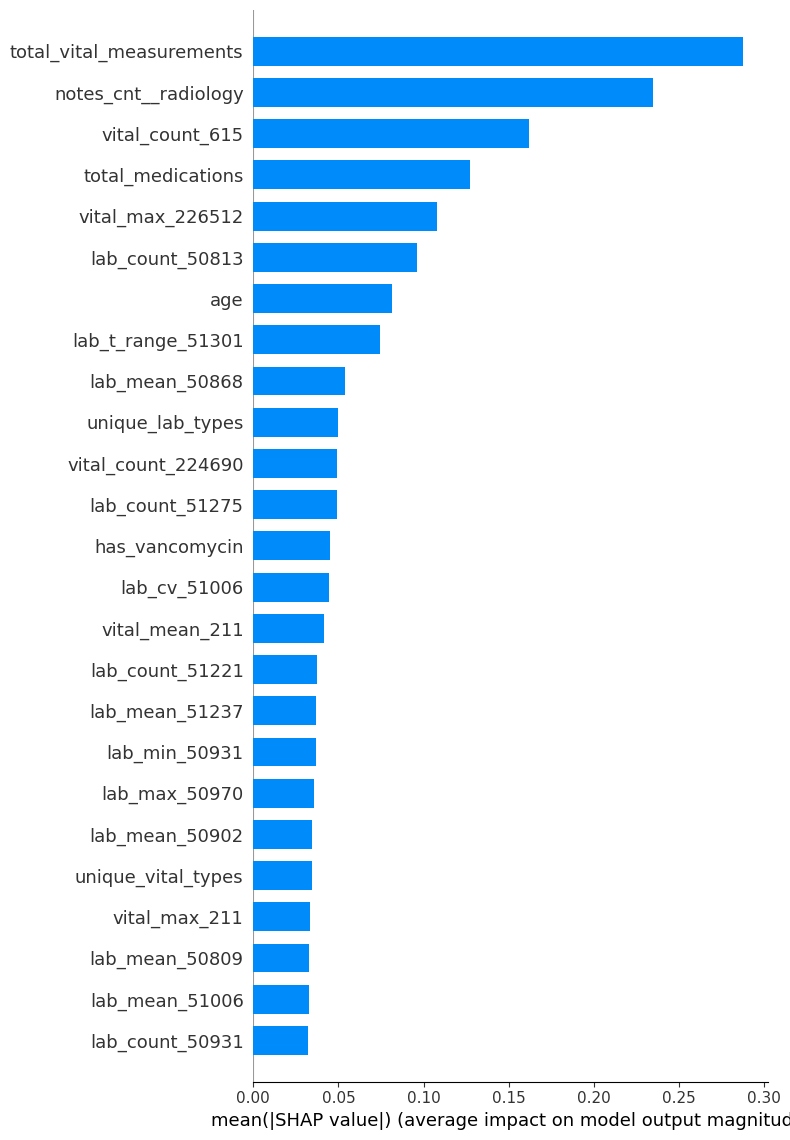

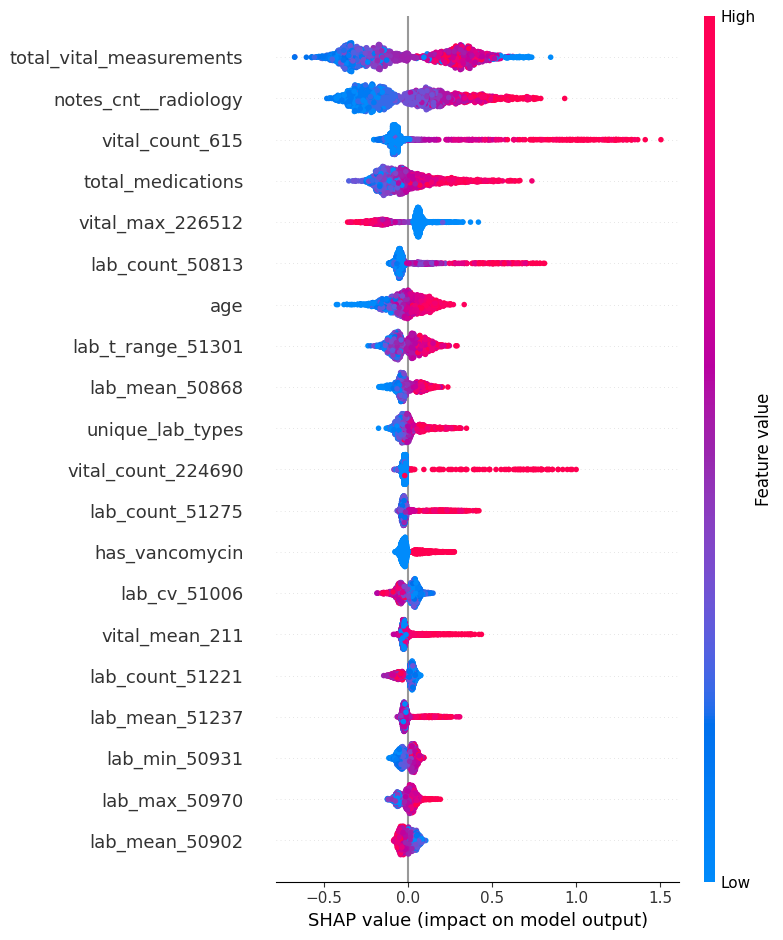


📊 TOP 20 MOST IMPORTANT FEATURES:
Rank  Feature                                            Mean |SHAP| 
----- -------------------------------------------------- ------------
1     total_vital_measurements                           0.2880      
2     notes_cnt__radiology                               0.2347      
3     vital_count_615                                    0.1620      
4     total_medications                                  0.1273      
5     vital_max_226512                                   0.1080      
6     lab_count_50813                                    0.0961      
7     age                                                0.0814      
8     lab_t_range_51301                                  0.0743      
9     lab_mean_50868                                     0.0540      
10    unique_lab_types                                   0.0500      
11    vital_count_224690                                 0.0491      
12    lab_count_51275                                  

In [10]:
import numpy as np
import pandas as pd
import shap
import pickle
import os

def get_base_tree_from_calibrated(calibrated_model):
    """
    Extract the base tree model from CalibratedClassifierCV
    """
    if hasattr(calibrated_model, 'calibrated_classifiers_'):
        # CalibratedClassifierCV - get first calibrated classifier's base estimator
        return calibrated_model.calibrated_classifiers_[0].estimator
    elif hasattr(calibrated_model, 'base_estimator'):
        # Some other wrapper
        return calibrated_model.base_estimator
    else:
        # Assume it's already the base model
        return calibrated_model

def shap_importance_safe(model, X, sample=2000, title="SHAP summary"):
    """
    Safe SHAP analysis with error handling
    """
    # Feature names + sampling
    if isinstance(X, pd.DataFrame):
        feature_names = list(X.columns)
        take = lambda idx: X.iloc[idx]
    else:
        feature_names = [f"f{i}" for i in range(X.shape[1])]
        take = lambda idx: X[idx]

    n = X.shape[0]
    if sample and n > sample:
        np.random.seed(42)
        sample_idx = np.random.choice(n, size=sample, replace=False)
        Xs = take(sample_idx)
    else:
        Xs = X

    # Try to create explainer (prefer tree)
    explainer = None
    try:
        explainer = shap.TreeExplainer(model)
        print(f"Using TreeExplainer for {type(model).__name__}")
    except Exception as e:
        print(f"TreeExplainer failed: {e}")
        try:
            explainer = shap.Explainer(model, Xs)
            print(f"Using general Explainer for {type(model).__name__}")
        except Exception as e2:
            print(f"General Explainer also failed: {e2}")
            return None

    # Get SHAP values
    try:
        sv = explainer(Xs)

        # Get plain array of shap values (n_samples, n_features)
        values = sv.values if hasattr(sv, "values") else sv
        if values.ndim == 3:  # (n, p, n_classes)
            values = values[:, :, 1]  # take positive class

        # Align names with columns
        if values.shape[1] != len(feature_names):
            if hasattr(sv, "feature_names") and sv.feature_names is not None:
                if len(sv.feature_names) == values.shape[1]:
                    feature_names = list(sv.feature_names)
                else:
                    print(f"Warning: Feature name mismatch. Using generic names.")
                    feature_names = [f"feature_{i}" for i in range(values.shape[1])]
            else:
                print(f"Warning: Feature shape mismatch: {values.shape[1]} vs {len(feature_names)}")
                feature_names = [f"feature_{i}" for i in range(values.shape[1])]

        # Create plots
        print(f"Creating SHAP plots for {title}...")

        # Summary plot (bar)
        shap.summary_plot(values, features=Xs, feature_names=feature_names,
                         plot_type="bar", max_display=25, show=True)

        # Summary plot (beeswarm)
        shap.summary_plot(values, features=Xs, feature_names=feature_names, show=True)

        # Create feature importance table
        mean_abs = np.abs(values).mean(axis=0)
        importance_df = pd.DataFrame({
            "feature": feature_names,
            "mean_abs_shap": mean_abs
        }).sort_values("mean_abs_shap", ascending=False)

        return importance_df

    except Exception as e:
        print(f"SHAP value calculation failed: {e}")
        return None

def analyze_enhanced_model_shap(enhanced_models_dict, splits_dict, target_name, sample_size=2000):
    """
    Perform SHAP analysis on enhanced calibrated model for a specific target
    """
    print(f"\n{'='*80}")
    print(f"SHAP FEATURE IMPORTANCE ANALYSIS - {target_name.upper()}")
    print(f"{'='*80}")

    # Get the enhanced CALIBRATED model and test data
    calibrated_model = enhanced_models_dict[target_name]['best']['calibrated_model']
    X_test = splits_dict['X_test']
    y_test = splits_dict['y_test'][target_name]

    # Extract base model for SHAP
    base_model = get_base_tree_from_calibrated(calibrated_model)

    # Model info
    algorithm = enhanced_models_dict[target_name]['best']['algorithm']
    strategy = enhanced_models_dict[target_name]['best']['strategy']
    calibration_method = enhanced_models_dict[target_name]['best'].get('calibration_method', 'unknown')

    print(f"Model Details:")
    print(f"  Algorithm: {algorithm}")
    print(f"  Strategy: {strategy}")
    print(f"  Calibration: {calibration_method}")
    print(f"  Base model type: {type(base_model).__name__}")
    print(f"  Expected features: {getattr(base_model, 'n_features_in_', 'Unknown')}")
    print(f"  Test set shape: {X_test.shape}")

    # Run SHAP analysis on base model
    title = f"{target_name.title()} - SHAP ({algorithm}, {strategy})"

    shap_results = shap_importance_safe(
        base_model,
        X_test,
        sample=sample_size,
        title=title
    )

    if shap_results is not None:
        print(f"\n📊 TOP 20 MOST IMPORTANT FEATURES:")
        print(f"{'Rank':<5} {'Feature':<50} {'Mean |SHAP|':<12}")
        print(f"{'-'*5} {'-'*50} {'-'*12}")

        for i, (_, row) in enumerate(shap_results.head(20).iterrows(), 1):
            feature_name = row['feature']
            shap_value = row['mean_abs_shap']
            # Truncate long feature names
            display_name = feature_name[:47] + "..." if len(feature_name) > 50 else feature_name
            print(f"{i:<5} {display_name:<50} {shap_value:<12.4f}")

        return shap_results
    else:
        print(f"❌ SHAP analysis failed for {target_name}")
        return None

def run_shap_analysis_all_models(enhanced_mortality, enhanced_readmission, enhanced_prolonged_stay,
                                mortality_splits, readmission_splits, prolonged_splits):
    """
    Run SHAP analysis for all enhanced models
    """
    print("="*80)
    print("SHAP FEATURE IMPORTANCE ANALYSIS FOR ENHANCED MODELS")
    print("="*80)

    # Mortality SHAP Analysis
    print("\n🏥 ANALYZING MORTALITY PREDICTION MODEL...")
    mortality_shap = analyze_enhanced_model_shap(
        enhanced_mortality,
        mortality_splits,
        'mortality',
        sample_size=2000
    )

    # Readmission SHAP Analysis
    print("\n🔄 ANALYZING READMISSION PREDICTION MODEL...")
    readmission_shap = analyze_enhanced_model_shap(
        enhanced_readmission,
        readmission_splits,
        'readmission',
        sample_size=2000
    )

    # Prolonged Stay SHAP Analysis
    print("\n⏰ ANALYZING PROLONGED STAY PREDICTION MODEL...")
    prolonged_stay_shap = analyze_enhanced_model_shap(
        enhanced_prolonged_stay,
        prolonged_splits,
        'prolonged_stay',
        sample_size=2000
    )

    # Cross-model comparison
    print(f"\n{'='*80}")
    print("CROSS-MODEL FEATURE IMPORTANCE COMPARISON")
    print(f"{'='*80}")

    successful_analyses = [x for x in [mortality_shap, readmission_shap, prolonged_stay_shap] if x is not None]

    if len(successful_analyses) >= 2:
        # Get top features from each successful model
        top_features = {}
        if mortality_shap is not None:
            top_features['Mortality'] = set(mortality_shap.head(10)['feature'])
        if readmission_shap is not None:
            top_features['Readmission'] = set(readmission_shap.head(10)['feature'])
        if prolonged_stay_shap is not None:
            top_features['Prolonged Stay'] = set(prolonged_stay_shap.head(10)['feature'])

        # Find intersections
        if len(top_features) >= 3:
            all_sets = list(top_features.values())
            common_features = all_sets[0] & all_sets[1] & all_sets[2]

            print(f"\n🔗 COMMON IMPORTANT FEATURES (across all models):")
            if common_features:
                for feature in sorted(common_features):
                    print(f"  • {feature}")
            else:
                print("  No features appear in top 10 of all three models")

        # Show unique features for each model
        for model_name, features in top_features.items():
            other_features = set()
            for other_name, other_set in top_features.items():
                if other_name != model_name:
                    other_features.update(other_set)

            unique_features = features - other_features
            print(f"\n📌 {model_name.upper()}-SPECIFIC IMPORTANT FEATURES:")
            if unique_features:
                for feature in sorted(unique_features):
                    print(f"  • {feature}")
            else:
                print(f"  No unique features for {model_name}")

        print(f"\n📈 INSIGHTS:")
        print(f"  • Common features likely represent general patient acuity/severity")
        print(f"  • Unique features capture outcome-specific risk factors")
        print(f"  • Consider these patterns for clinical interpretation and feature engineering")

    else:
        print("⚠️  Insufficient successful SHAP analyses for comparison")

    # Save results
    print(f"\n{'='*80}")
    print("✅ SHAP ANALYSIS COMPLETE")
    print("   Feature importance insights generated for enhanced calibrated models")
    print(f"{'='*80}")

    # Save results
    if not os.path.exists('enhanced_models'):
        os.makedirs('enhanced_models')

    shap_results = {
        'mortality': mortality_shap,
        'readmission': readmission_shap,
        'prolonged_stay': prolonged_stay_shap
    }

    with open('enhanced_models/shap_feature_importance.pkl', 'wb') as f:
        pickle.dump(shap_results, f)

    print(f"\n💾 SHAP results saved to: enhanced_models/shap_feature_importance.pkl")

    return shap_results

# Run the analysis
shap_results = run_shap_analysis_all_models(
    enhanced_mortality, enhanced_readmission, enhanced_prolonged_stay,
    mortality_splits, readmission_splits, prolonged_splits
)

## XGBoost FS
Here we will try to iteratively choose features that improve XGBoost.

In [ ]:
from joblib import dump
import os

os.makedirs("pickled_splits", exist_ok=True)

dump(mortality_splits,       "pickled_splits/mortality_splits.pkl",       compress=("xz", 3))
dump(prolonged_splits,  "pickled_splits/prolonged_stay_splits.pkl",       compress=("xz", 3))
dump(readmission_splits,     "pickled_splits/readmission_splits.pkl",     compress=("xz", 3))


['pickled_splits/readmission_splits.pkl']

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import average_precision_score, roc_auc_score
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

def _cv_score_xgb(
    X, y, features, metric="average_precision",
    n_splits=5, random_state=42, xgb_params=None,
    early_stopping_rounds=50, groups=None
):
    xgb_params = xgb_params or dict(
        n_estimators=2000, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.8, n_jobs=-1,
        eval_metric="logloss", reg_lambda=1.0
    )
    Xf = X[features].values
    if groups is None:
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        splits = cv.split(Xf, y)
    else:
        cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        splits = cv.split(Xf, y, groups=groups)

    scores = []
    for tr_idx, va_idx in splits:
        X_tr, X_va = Xf[tr_idx], Xf[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        model = XGBClassifier(**xgb_params, early_stopping_rounds=early_stopping_rounds, random_state=random_state)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            verbose=False
        )
        y_score = model.predict_proba(X_va)[:, 1]
        if metric == "average_precision":
            s = average_precision_score(y_va, y_score)
        elif metric == "roc_auc":
            s = roc_auc_score(y_va, y_score)
        else:
            raise ValueError("metric must be 'average_precision' or 'roc_auc'")
        scores.append(s)

    return float(np.mean(scores)), float(np.std(scores))

def _prefilter_by_gain(X, y, top_k=200, random_state=42, xgb_params=None):
    xgb_params = xgb_params or dict(
        n_estimators=400, learning_rate=0.1, max_depth=4,
        subsample=0.9, colsample_bytree=0.8, n_jobs=-1,
        eval_metric="logloss", reg_lambda=1.0
    )
    model = XGBClassifier(**xgb_params, random_state=random_state)
    model.fit(X, y)
    gain = model.feature_importances_
    order = np.argsort(gain)[::-1]
    feats = list(X.columns[order][:min(top_k, X.shape[1])])
    return feats

def greedy_forward_select_xgb(
    X: pd.DataFrame,
    y: np.ndarray,
    metric: str = "average_precision",
    candidate_features: list | None = None,
    max_features: int | None = None,
    min_improvement: float = 1e-4,
    patience: int = 10,
    n_splits: int = 5,
    random_state: int = 42,
    groups=None
):
    if candidate_features is None:
        candidate_features = _prefilter_by_gain(X, y, top_k=200, random_state=random_state)
        print(f"[prefilter] Using top {len(candidate_features)} gain features as candidates.")
    else:
        candidate_features = [f for f in candidate_features if f in X.columns]

    remaining = set(candidate_features)
    selected = []
    best_first, best_first_score = None, -np.inf

    # Start with best single feature
    for f in tqdm(remaining, desc="Single-feature scan", leave=False):
        s, _ = _cv_score_xgb(X, y, [f], metric=metric, n_splits=n_splits,
                             random_state=random_state, groups=groups)
        if s > best_first_score:
            best_first, best_first_score = f, s
    selected.append(best_first)
    remaining.remove(best_first)
    best_score = best_first_score
    history = [(len(selected), best_score, best_first)]
    print(f"[start] 1 feature: {best_first} → {best_score:.4f} ({metric})")

    # Greedy add
    no_improve_rounds = 0
    while remaining and (max_features is None or len(selected) < max_features):
        best_candidate, best_candidate_score = None, best_score
        for f in tqdm(list(remaining), desc=f"Adding feature {len(selected)+1}", leave=False):
            trial_feats = selected + [f]
            s, _ = _cv_score_xgb(X, y, trial_feats, metric=metric, n_splits=n_splits,
                                 random_state=random_state, groups=groups)
            if s > best_candidate_score:
                best_candidate, best_candidate_score = f, s

        if best_candidate is not None and (best_candidate_score - best_score) >= min_improvement:
            selected.append(best_candidate)
            remaining.remove(best_candidate)
            best_score = best_candidate_score
            history.append((len(selected), best_score, best_candidate))
            print(f"[add] {len(selected)} feats: +{best_candidate} → {best_score:.4f}")
            no_improve_rounds = 0
        else:
            no_improve_rounds += 1
            print(f"[no improve] rounds={no_improve_rounds} (best={best_score:.4f})")
            if no_improve_rounds >= patience:
                print("[stop] early stop by patience.")
                break

    return selected, pd.DataFrame(history, columns=["k_features", f"cv_{metric}", "last_added"])

def train_final_xgb(Xtr, ytr, Xva, yva, Xte, yte, features, metric="average_precision", random_state=42):
    params = dict(
        n_estimators=2000, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.8, n_jobs=-1,
        eval_metric="logloss", reg_lambda=1.0
    )
    model = XGBClassifier(**params, early_stopping_rounds=50, random_state=random_state)
    model.fit(
        Xtr[features], ytr,
        eval_set=[(Xva[features], yva)],
        verbose=False
    )
    # one final evaluation on TEST
    from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, roc_auc_score, average_precision_score, confusion_matrix
    y_prob = model.predict_proba(Xte[features])[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    out = {
        "accuracy": float((y_pred == yte).mean()),
        "f1": float(f1_score(yte, y_pred)),
        "precision_recall_fscore_support": precision_recall_fscore_support(yte, y_pred, average="binary"),
        "confusion_matrix": confusion_matrix(yte, y_pred),
        "average_precision": average_precision_score(yte, y_prob),
    }
    # add ROC AUC too (useful esp. for LOS)
    try:
        out["roc_auc"] = roc_auc_score(yte, y_prob)
    except Exception:
        pass

    return model, out

def run_fs_and_eval_for_target(splits, target, max_features=60, patience=8, candidate_features=None, groups_col="subject_id"):
    # Unpack your splits
    Xtr, Xva, Xte = splits["X_train"], splits["X_val"], splits["X_test"]
    ytr, yva, yte = splits["y_train"][target].values, splits["y_val"][target].values, splits["y_test"][target].values
    feature_cols = splits["feature_cols"]

    # Optional subject-level grouping for CV (prevents leakage if multiple admissions per subject)
    groups = None
    if splits.get("ids_train") is not None and groups_col in splits["ids_train"].columns:
        groups = splits["ids_train"][groups_col].values

    # choose metric per task
    metric = "roc_auc" if target.lower() in {"prolonged_stay", "los", "length_of_stay"} else "average_precision"

    print(f"\n=== {target}: feature selection on TRAIN (metric={metric}) ===")
    sel_feats, history = greedy_forward_select_xgb(
        Xtr[feature_cols], ytr, metric=metric,
        candidate_features=candidate_features,
        max_features=max_features, patience=patience,
        groups=groups
    )
    print(f"Selected {len(sel_feats)} features (first 10): {sel_feats[:10]}")

    print(f"\n=== {target}: train on TRAIN (early-stop on VAL) & evaluate on TEST ===")
    model, test_metrics = train_final_xgb(
        Xtr, ytr, Xva, yva, Xte, yte, features=sel_feats, metric=metric
    )
    print("Test metrics:", {k: (v if not hasattr(v, "shape") else v.tolist()) for k,v in test_metrics.items()})

    return {
        "selected_features": sel_feats,
        "history": history,
        "model": model,
        "test_metrics": test_metrics
    }


res_mort = run_fs_and_eval_for_target(mortality_splits, target="mortality",      max_features=60, patience=8)
res_los  = run_fs_and_eval_for_target(prolonged_stay_splits, target="prolonged_stay", max_features=60, patience=8)
res_read = run_fs_and_eval_for_target(readmission_splits, target="readmission",    max_features=60, patience=8)




=== mortality: feature selection on TRAIN (metric=average_precision) ===
[prefilter] Using top 200 gain features as candidates.


Single-feature scan:   0%|          | 0/200 [00:00<?, ?it/s]

[start] 1 feature: lab_min_51006 → 0.2852 (average_precision)


Adding feature 2:   0%|          | 0/199 [00:00<?, ?it/s]

[add] 2 feats: +lab_max_50885 → 0.3354


Adding feature 3:   0%|          | 0/198 [00:00<?, ?it/s]

KeyboardInterrupt: 